<center><span style="font-size:28px; font-weight:bold;">Implementez un modèle de scoring</span><center>

<center><span style="font-size:28px; font-weight:bold;">2 - Modélisation</span><center>

L'objectif de ce notebook est de développer un modèle de **scoring crédit** capable de prédire la probabilité de défaut de paiement des clients. Ce projet suit une approche complète de bout en bout, de la modélisation initiale à la mise en production, en passant par l'évaluation des impacts métiers.

La première étape consiste à **modéliser les données avec un déséquilibre de classe** en utilisant différents algorithmes, dont un **Dummy Classifier** comme baseline, suivi d'une **régression logistique** et des modèles de **Gradient Boosting**. Après cette première phase, le **SMOTE** est appliqué pour rééquilibrer les classes et améliorer la représentativité des clients défaillants, suivie d'une nouvelle phase d'entraînement et d'évaluation.

Pour aller plus loin, une **optimisation des hyperparamètres** est réalisée sur les modèles **LGBM** et **XGBoost** afin de maximiser leurs performances. En parallèle, l'ajout d'un **score métier** permet de mieux prendre en compte l'impact des erreurs de prédiction sur l'entreprise, en particulier les **faux négatifs**, qui peuvent être coûteux pour une banque.

Le notebook poursuit avec l'analyse de **l'importance des caractéristiques** au niveau global et local à l'aide de **SHAP**. Cela permet de comprendre les variables qui influencent le plus la décision du modèle, tout en offrant une interprétation des prédictions pour chaque client.

Ensuite, nous explorons les aspects **Data Drift** pour assurer la stabilité du modèle au fil du temps, puis nous passons à la phase de **déploiement**. L'API du modèle est construite avec **FastAPI**, conteneurisée avec **Docker**, et déployée sur un service cloud. Une interface **Streamlit** a également été mise en place sur Streamlit Cloud pour tester le modèle de manière interactive.

# Sommaire

1. [Importation des librairies et des données](#1)
2. [Première modélisation : avec déséquilibre de classe](#2)
   - [Dummy Classifier](#2.1)
   - [Régression logistique](#2.2)
   - [Gradient Boosting](#2.3)
3. [Deuxième modélisation : après SMOTE](#3)
   - [Application du SMOTE](#3.1)
   - [Entraînement des modèles](#3.2)
   - [Évaluation du modèle](#3.3)
4. [Recherche des meilleurs hyperparamètres](#4)
   - [LGBM Classifier](#4.1)
   - [XGBoost Classifier](#4.2)
5. [Ajout d'un score métier](#5)
   - [Création du score métier](#5.1)
   - [Evaluation du score métier](#5.2)
   - [Essais empiriques pour ajuster cost_fn et cost_fp](#5.3)
6. [Modèle final optimisé](#6)
   - [Analyse des différents seuils et coûts](#6.1)
   - [Meilleures configurations en fonction du contexte](#6.2)
   - [Analyse de ces différentes configurations](#6.3)
7. [Features importance](#7)
8. [Datadrift](#8)
9. [Déploiement](#9)
10. [Conclusion](#10)

# 1 - Importation des librairies et des données

## 1.1 - Importation des différentes librairies

In [31]:
# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# File system management
import os
import time
from io import BytesIO
import io
from IPython.display import Image, display
import base64

# Data manipulation
import numpy as np
import pandas as pd 

# Graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning et data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    cross_validate, train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Resampling
from imblearn.over_sampling import SMOTE

# ML Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# SHAP
import shap

# Outils MLOps
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Drift et monitoring
from evidently.report import Report
from evidently.metrics import DataDriftTable
from IPython.display import IFrame

# Pipeline de features engineering
import pipeline_features_eng

In [3]:
# On va démarrer le chronomètre
start = time.time()

## 1.2 - Configuration de Mlflow

**MLflow** est une plateforme open source conçue pour gérer le cycle de vie des modèles de machine learning. Il permet de suivre les expérimentations, de versionner les modèles et de faciliter leur déploiement. 

Dans notre projet, **MLflow** est utilisé pour :

- **Suivre les runs** et les résultats des expérimentations.
- **Enregistrer les paramètres, métriques et artefacts** liés aux différents modèles.
- **Versionner les modèles optimisés** pour un futur déploiement.

**A - Les runs dans MLflow**

Un **run** dans MLflow correspond à une exécution de code qui est suivie, enregistrant des informations pertinentes telles que :

- Les **paramètres** d'entraînement utilisés (par exemple, les hyperparamètres comme le taux d'apprentissage ou le nombre d'estimations).
- Les **métriques** calculées (AUC, précision, temps d'exécution, etc.).
- Les **artefacts** produits (graphiques, modèles enregistrés, etc.).
- La **signature des données** (la structure des entrées et sorties du modèle).

**B - Enregistrement des modèles dans MLflow**

MLflow permet d’enregistrer les modèles pour une future utilisation via l'API **`mlflow.log_model()`**. Les modèles peuvent être :

- **Versionnés** et **stockés** avec les artefacts.
- **Récupérés** et **chargés** plus tard pour faire des prédictions ou les déployer dans des pipelines de production.

**C - Suivi des résultats avec MLflow**

Grâce à MLflow, nous pouvons consulter toutes nos expérimentations, comparer les runs, et identifier les meilleurs modèles en fonction des métriques enregistrées. MLflow permet également de visualiser des graphiques et de suivre les versions des modèles pour garder un historique détaillé des itérations de notre travail.

Par exemple, dans le **UI de MLflow**, nous pouvons facilement :

- **Comparer plusieurs runs** côte à côte pour voir quelle configuration a donné les meilleurs résultats.
- **Visualiser les métriques** pour chaque run et ajuster nos modèles en conséquence.

**D - Versioning des modèles**

MLflow offre également la possibilité de **versionner** les modèles grâce à un modèle registry. Chaque modèle enregistré dans le **Model Registry** peut être associé à une version, ce qui facilite le déploiement et la gestion continue des versions en production.

In [4]:
# On va configurer l'URI du serveur MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Remplacer par l'URI de notre serveur si nécessaire

Le code `mlflow.set_tracking_uri("http://localhost:5000")` sert à configurer l'URI du serveur de tracking MLflow.

   - L'URI spécifie où se trouve le serveur MLflow. Par défaut, MLflow utilise un serveur local en mémoire, ce qui signifie que les données ne seront pas conservées après l'arrêt de la session.
   - En définissant l'URI, nous pouvons nous connecter à un serveur MLflow qui stocke les résultats des expérimentations de manière persistante, ce qui permet d'accéder aux résultats ultérieurement.

## 1.3 - Importation des données

In [5]:
# chemins racine possibles
root_directory = [
    os.path.abspath("./Projet+Mise+en+prod+-+home-credit-default-risk"),
    os.path.abspath("./P7_implementer_modele_scoring")
]

def load_csv(file_name, root_dirs, **kwargs):
    # Parcourir chaque chemin racine possible
    for root_dir in root_dirs:
        # Chemin direct si le fichier est à la racine du projet
        file_path_root = os.path.join(root_dir, file_name)
        
        # Vérifier si le fichier est à la racine
        if os.path.exists(file_path_root):
            print(f"Loading {file_name} from root directory: {file_path_root}")
            return pd.read_csv(file_path_root, **kwargs)
        
        # Recherche dans les sous-répertoires si le fichier n'est pas dans le dossier racine
        for dirpath, _, filenames in os.walk(root_dir):
            if file_name in filenames:
                file_path = os.path.join(dirpath, file_name)
                print(f"Loading {file_name} from {file_path}")
                return pd.read_csv(file_path, **kwargs)
    
    # Message si le fichier n'est pas trouvé
    print(f"{file_name} not found in any of the specified directories or subdirectories.")
    return None

In [6]:
# Chargement des fichiers en utilisant les chemins potentiels
df_data_6 = load_csv('df_data_6.csv', root_directory)
df_application_train = load_csv('application_train.csv', root_directory)
df_application_test = load_csv('application_test.csv', root_directory)

Loading df_data_6.csv from root directory: C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\Projet+Mise+en+prod+-+home-credit-default-risk\df_data_6.csv
Loading application_train.csv from root directory: C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\Projet+Mise+en+prod+-+home-credit-default-risk\application_train.csv
Loading application_test.csv from root directory: C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\Projet+Mise+en+prod+-+home-credit-default-risk\application_test.csv


In [7]:
df_data_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 333 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(333)
memory usage: 905.1 MB


Dans notre cas, l'ensemble de test (`TEST`) ne contient pas la variable cible (`TARGET`). Par conséquent, nous ne pouvons pas évaluer directement les performances de nos modèles sur cet ensemble. Pour contourner ce problème et garantir une évaluation fiable, nous séparons l'ensemble d'entraînement (`TRAIN`) en deux sous-ensembles : un sous-ensemble d'entraînement et un sous-ensemble de validation.

Cette séparation nous permet de :
1. **Entraîner les Modèles** : Utiliser le sous-ensemble d'entraînement pour ajuster les paramètres du modèle.
2. **Évaluer les Modèles** : Utiliser le sous-ensemble de validation, qui contient les labels de la variable cible, pour évaluer les performances du modèle avant de le tester sur l'ensemble de test. 

Cela assure que le modèle est bien évalué et validé même si l'ensemble de test ne fournit pas de `TARGET`, nous permettant ainsi de juger de la performance et de la robustesse du modèle de manière fiable.

Cette séparation de `df_data_6` en `df_train` et `df_test` en fonction de la colonne `SK_ID_CURR` est une manière de réassocier les données prétraitées (dans `df_data_6`) avec les ensembles originaux de *train* et *test* (`df_application_train` et `df_application_test`).

In [8]:
# Séparation de df_data_4 en train et test
df_train = df_data_6[df_data_6['SK_ID_CURR'].isin(df_application_train['SK_ID_CURR'])]
df_test = df_data_6[df_data_6['SK_ID_CURR'].isin(df_application_test['SK_ID_CURR'])]

Afin de préparer les données pour les étapes d'entraînement de notre modèle, nous allons procéder à la standardisation. La standardisation permet de mettre à l'échelle toutes les variables sur une même plage de valeurs, ici entre 0 et 1, ce qui est particulièrement utile lorsque les données présentent des gammes de valeurs très différentes. Une échelle uniforme aide à améliorer la convergence des algorithmes d'apprentissage et leur performance générale.

Pour ce faire, nous allons utiliser le `MinMaxScaler` de la bibliothèque scikit-learn, un outil qui redimensionne les données en fonction d'une plage spécifique. Nous allons choisir une plage de valeurs allant de 0 à 1. Le `MinMaxScaler` fonctionne en ajustant les valeurs des caractéristiques de manière à ce que la valeur minimale de chaque caractéristique devienne 0 et la valeur maximale devienne 1.

In [9]:
# Identifiants et cible à exclure de la standardisation
exclude_cols = ['SK_ID_CURR', 'TARGET']

# Séparer les colonnes à standardiser de celles à exclure
cols_to_scale = [col for col in df_train.columns if col not in exclude_cols]
df_train_to_scale = df_train[cols_to_scale]
df_train_excluded = df_train[exclude_cols]

# Création du scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustement et transformation
df_train_scaled = scaler.fit_transform(df_train_to_scale)

# Recréer un DataFrame avec les colonnes standardisées
df_train_scaled_df = pd.DataFrame(df_train_scaled, columns=cols_to_scale)

# Ajouter les colonnes exclues
train = pd.concat([df_train_scaled_df, df_train_excluded.reset_index(drop=True)], axis=1)

print('Standardization complete.')
print('Data shape after scaling: ', train.shape)

Standardization complete.
Data shape after scaling:  (307511, 333)


In [10]:
# Séparation des features (X) et de la target (y)
X_train = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)  # Retirer SK_ID_CURR
y_train = train['TARGET']

In [11]:
print('Training Features shape with categorical columns: ', df_application_train.shape)
print('Testing Features shape with categorical columns: ', df_application_test.shape)

Training Features shape with categorical columns:  (307511, 122)
Testing Features shape with categorical columns:  (48744, 121)


In [12]:
# Vérifier les valeurs uniques de SK_ID_CURR dans df_application_test et df_data_4
print("Unique SK_ID_CURR in df_application_test:", df_application_test['SK_ID_CURR'].nunique())
print("Unique SK_ID_CURR in df_data_4:", df_data_6['SK_ID_CURR'].nunique())

Unique SK_ID_CURR in df_application_test: 48744
Unique SK_ID_CURR in df_data_4: 356255


In [13]:
# On va séparer l'ensemble d'entraînement en un ensemble d'entraînement et un ensemble de validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

La séparation de l’ensemble d’entraînement en deux parties – un sous-ensemble d’entraînement et un ensemble de validation – permet de mieux évaluer la performance d’un modèle avant son application finale.

In [14]:
# Affichage des tailles des datasets
print(f"Taille de X_train_split : {X_train_split.shape}")
print(f"Taille de y_train_split : {y_train_split.shape}")
print(f"Taille de X_val : {X_val.shape}")
print(f"Taille de y_val : {y_val.shape}")

Taille de X_train_split : (215257, 331)
Taille de y_train_split : (215257,)
Taille de X_val : (92254, 331)
Taille de y_val : (92254,)


## 1.4 - Définition des fonctions

La fonction `evaluate_models_with_cross_validation` évalue les modèles via validation croisée et logue les résultats dans MLflow si demandé.
    
Parametres :
    
    - models (dict): Dictionnaire contenant les noms et instances des modèles à évaluer.
    - X_train_split (pd.DataFrame): Données d'entraînement.
    - y_train_split (pd.Series): Cibles d'entraînement.
    - log_to_mlflow (bool): Si True, enregistre les résultats dans MLflow.

In [14]:
def evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True):
    # Initialisation d'un DataFrame pour stocker les résultats
    results_df = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

    for name, model in models.items():
        if log_to_mlflow:
            # Nom de la run MLflow avec le nom du modèle
            mlflow_run_name = f"{name}"

            # Démarre une nouvelle run MLflow
            with mlflow.start_run(run_name=mlflow_run_name):
                # Mesurer le temps de fitting
                start_fit_time = time.time()
                
                # Évaluation via cross-validation avec prédictions
                y_pred = cross_val_predict(model, X_train_split, y_train_split, cv=5, method='predict_proba', n_jobs=-1)
                
                end_fit_time = time.time()
                fit_time_mean = end_fit_time - start_fit_time

                # Calcul des scores
                auc_mean = roc_auc_score(y_train_split, y_pred[:, 1])
                accuracy_mean = accuracy_score(y_train_split, (y_pred[:, 1] >= 0.5).astype(int))

                # Mesurer le temps de scoring
                start_score_time = time.time()
                model.fit(X_train_split, y_train_split)  # Fit le modèle pour le scoring
                end_score_time = time.time()
                score_time_mean = end_score_time - start_score_time

                # Logging dans MLFlow
                mlflow.log_param("Model", name)
                mlflow.log_metric("AUC", auc_mean)
                mlflow.log_metric("Accuracy", accuracy_mean)
                mlflow.log_metric("Fit_time_mean", fit_time_mean)
                mlflow.log_metric("Score_time_mean", score_time_mean)

                # Générer la signature du modèle (entrées/sorties)
                signature = infer_signature(X_train_split, (y_pred[:, 1] >= 0.5).astype(int))

                # Enregistrement du modèle dans MLFlow et Model Registry avec versioning
                mlflow.sklearn.log_model(
                    model,
                    artifact_path="model",
                    signature=signature,
                    registered_model_name=f"{name}-classification-model"  # Enregistrement avec nom et versioning
                )

        else:
            # Évaluation via cross-validation sans logging
            y_pred = cross_val_predict(model, X_train_split, y_train_split, cv=5, method='predict_proba', n_jobs=-1)
            auc_mean = roc_auc_score(y_train_split, y_pred[:, 1])
            accuracy_mean = accuracy_score(y_train_split, (y_pred[:, 1] >= 0.5).astype(int))

        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean if log_to_mlflow else None],
            'Score_time_mean': [score_time_mean if log_to_mlflow else None],
        })
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

Cette fonction `evaluate_model` est conçue pour évaluer les performances d'un modèle de classification sur un ensemble de validation et enregistrer les métriques et les graphiques dans MLflow si nécessaire.

- **Structure générale de la fonction**

Vérification de `log_to_mlflow` : 
   - Si `log_to_mlflow=True`, une exécution (*run*) MLflow est créée, et toutes les métriques et le modèle seront logués dans MLflow.
   - Si `log_to_mlflow=False`, les métriques sont affichées dans la console sans enregistrement dans MLflow.

Nom de la *run* MLflow : Le nom inclut `test_set`, pour indiquer qu’il s’agit d’évaluations sur un ensemble de validation ou test.

Entraînement conditionnel du modèle :
   - Si `retrain=True`, le modèle est réentraîné sur `X_train_split` et `y_train_split`. Cela peut être utile si le modèle a été précédemment ajusté, mais on veut s’assurer qu’il est à jour avant l’évaluation.

**Évaluation des performances**

Prédictions et mesures de temps :
   - Les prédictions de classe (`y_pred`) et les probabilités pour la classe positive (`y_pred_proba`) sont calculées pour l’ensemble de validation `X_val`.
   - Le temps de prédiction est également mesuré et logué comme métrique (`Score_time`), ce qui permet de quantifier le temps nécessaire pour générer les prédictions.

Calcul des métriques de classification :
   - **Accuracy** : mesure la proportion de prédictions correctes sur l'ensemble de validation.
   - **AUC (ROC AUC)** : score de l’aire sous la courbe ROC, qui reflète la capacité du modèle à différencier les classes.
   - **Precision** : proportion de prédictions positives correctes, utile pour éviter les faux positifs (par exemple, accorder des crédits à des clients risqués).
   - **Recall (Sensibilité)** : proportion de vrais positifs parmi les cas réellement positifs, crucial pour éviter les faux négatifs (manquer les clients à risque).
   - **F1-score** : moyenne harmonique entre la précision et le rappel, essentielle lorsque le modèle doit équilibrer les faux positifs et les faux négatifs dans un contexte de déséquilibre de classes.
   - **Confusion Matrix** : matrice qui montre les vraies et fausses classifications dans chaque catégorie (prédictions correctes et incorrectes).

- **Enregistrement dans MLflow**

Log des métriques et du modèle : Toutes les métriques calculées sont loguées dans MLflow pour suivre les performances du modèle sur cet ensemble de validation.
Affichage et enregistrement des graphiques : 
   - La fonction `plot_confusion_matrix_and_roc` crée et affiche la matrice de confusion et la courbe ROC.
   - Cette figure est ensuite enregistrée dans MLflow pour référence ultérieure.

En somme, cette fonction permet d'évaluer un modèle de manière flexible, avec ou sans enregistrement des résultats dans MLflow.

In [15]:
def evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=False, log_to_mlflow=True):
    # Si l'enregistrement dans MLflow est activé
    if log_to_mlflow:
        # Nom de la run MLflow avec le suffixe "TEST"
        mlflow_run_name = f"{model_name} test_set"

        # Démarre une nouvelle run MLflow
        with mlflow.start_run(run_name=mlflow_run_name):
            if retrain:
                model.fit(X_train_split, y_train_split)

            # Fait les prédictions
            start_time = time.time()
            y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe positive
            y_pred = model.predict(X_val)
            prediction_time = time.time() - start_time

            # Calcule les métriques
            accuracy = accuracy_score(y_val, y_pred)
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            precision = precision_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            cm = confusion_matrix(y_val, y_pred)

            # Logue les métriques dans MLflow
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("AUC", roc_auc)
            mlflow.log_metric("Precision", precision)
            mlflow.log_metric("Recall", recall)
            mlflow.log_metric("F1-score", f1)
            mlflow.log_metric("Score_time", prediction_time)

            # Enregistre le modèle dans MLflow
            mlflow.sklearn.log_model(model, "model")

            # Affiche les graphiques
            plot_confusion_matrix_and_roc(cm, y_val, y_pred_proba, roc_auc)

            # Enregistre les graphiques dans MLflow
            fig = plt.gcf()  # Récupérer la figure actuelle
            mlflow.log_figure(fig, "confusion_matrix_and_roc_curve.png")

    else:
        # Si l'enregistrement dans MLflow est désactivé
        if retrain:
            model.fit(X_train_split, y_train_split)

        # Fait les prédictions
        start_time = time.time()
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)
        prediction_time = time.time() - start_time

        # Calcule les métriques
        accuracy = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)

        # Affiche les résultats sans MLflow
        print(f'Accuracy: {accuracy:.4f}')
        print(f'AUC: {roc_auc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-score: {f1:.4f}')
        print("\nMatrice de confusion :")
        print(pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive']))

        # Affiche les graphiques
        plot_confusion_matrix_and_roc(cm, y_val, y_pred_proba, roc_auc)

La fonction `plot_confusion_matrix_and_roc` affiche une matrice de confusion ainsi que la courbe AUC-ROC.

La **matrice de confusion** est un tableau qui permet de visualiser les performances d'un modèle de classification. Elle présente les comparaisons entre les vraies valeurs et les valeurs prédites par le modèle. Les quatre composantes de la matrice sont les suivantes :
- **Vrais Positifs (TP)** : Nombre de prédictions positives correctes (le modèle prédit que l'événement se produit et c'est effectivement le cas).
- **Faux Positifs (FP)** : Nombre de prédictions positives incorrectes (le modèle prédit que l'événement se produit, mais ce n'est pas le cas).
- **Vrais Négatifs (TN)** : Nombre de prédictions négatives correctes (le modèle prédit que l'événement ne se produit pas et c'est effectivement le cas).
- **Faux Négatifs (FN)** : Nombre de prédictions négatives incorrectes (le modèle prédit que l'événement ne se produit pas, mais il se produit en réalité).

Cette matrice est utile pour calculer des métriques telles que la **précision** (accuracy), la **précision** (precision), le **rappel** (recall), et le **F1-score**, qui sont des indicateurs clés de la performance globale du modèle.

La **courbe ROC (Receiver Operating Characteristic)** est un graphique qui évalue la capacité d'un modèle à distinguer entre les classes positives et négatives à différents seuils de décision. Chaque point de la courbe correspond à un certain seuil de classification. La courbe est tracée en fonction des axes suivants :
- **Axe des X (False Positive Rate, FPR)** : Taux de faux positifs, calculé comme le ratio entre les faux positifs et l'ensemble des réels négatifs (FP / (FP + TN)).
- **Axe des Y (True Positive Rate, TPR)** : Taux de vrais positifs (ou sensibilité), calculé comme le ratio entre les vrais positifs et l'ensemble des réels positifs (TP / (TP + FN)).

Un modèle parfait aurait une courbe ROC qui passe par le coin supérieur gauche du graphique, ce qui signifierait un taux de vrais positifs de 1 et un taux de faux positifs de 0.

L'**aire sous la courbe ROC (AUC)** est une mesure globale de la performance du modèle. Elle indique dans quelle mesure le modèle est capable de distinguer correctement les classes. L'aire sous la courbe varie entre 0 et 1 :
- **AUC = 1** : Le modèle est parfait.
- **AUC = 0.5** : Le modèle n'est pas meilleur qu'un classificateur aléatoire.
- **AUC < 0.5** : Le modèle se comporte pire qu'un classificateur aléatoire, indiquant une mauvaise classification des classes.

Une **AUC élevée** indique que le modèle fait bien la distinction entre les classes positives et négatives, même à différents seuils de classification.

In [16]:
def plot_confusion_matrix_and_roc(cm, y_val, y_pred_proba, roc_auc):
    # Fonction pour tracer la matrice de confusion et la courbe ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

    # Affiche les deux graphiques côte à côte
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], annot_kws={"size": 16})
    ax[0].set_xlabel('Predicted', fontsize=14)
    ax[0].set_ylabel('True', fontsize=14)
    ax[0].set_title('Matrice de confusion', fontsize=16)

    # Courbe ROC
    ax[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate', fontsize=14)
    ax[1].set_ylabel('True Positive Rate', fontsize=14)
    ax[1].set_title('Courbe ROC', fontsize=16)
    ax[1].legend(loc='lower right', fontsize=12)

    plt.tight_layout()
    plt.show()

# 2 - Première modélisation : avec déséquilibre de classe

Dans **MLflow**, il est recommandé de faire la distinction entre **expérimentations** et **runs** :

1. **Expérimentations** :
   - Une **expérimentation** est un groupe de runs associés à un même objectif.
   - En initialisant l'expérimentation avec `mlflow.set_experiment("Home Credit Default Risk - Modelisation 1")`, nous créons un contexte pour toutes les runs que nous allons effectuer pour cet objectif.

2. **Runs** :
   - Un **run** représente une exécution d'un modèle. Chaque fois que nus allons entraîner un modèle, explorer une nouvelle méthode, ou modifier des hyperparamètres, nous allons créer une nouvelle run.
   - Cela va nous permettre de suivre les métriques, les paramètres, et les artefacts (comme les modèles entraînés) pour chaque exécution de manière isolée.

In [17]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("1 - Première modélisation : avec déséquilibre de classe")

<Experiment: artifact_location='mlflow-artifacts:/530820720891640535', creation_time=1729160122033, experiment_id='530820720891640535', last_update_time=1729160122033, lifecycle_stage='active', name='1 - Première modélisation : avec déséquilibre de classe', tags={}>

## 2.1 - Dummy Classifier

Le **Dummy Classifier** est un modèle de référence (ou "baseline") utilisé dans le domaine du machine learning pour fournir un point de comparaison simple lorsque l'on évalue les performances d'un modèle plus complexe. Contrairement aux modèles traditionnels qui tentent de trouver des patterns significatifs dans les données pour effectuer des prédictions, le Dummy Classifier adopte des stratégies très simples pour effectuer ses prédictions, sans essayer de modéliser la relation entre les caractéristiques et la cible.

L'objectif principal du Dummy Classifier est de servir de référence minimale. En l'utilisant, on peut mesurer à quel point un modèle plus sophistiqué surpasse une méthode naïve. Il est particulièrement utile dans les cas où les données sont déséquilibrées, car il permet de voir à quel point un modèle avancé est capable de capturer des patterns qui surpassent une stratégie simple.

Le Dummy Classifier peut utiliser différentes stratégies pour faire ses prédictions :
1. **"stratified"** : Les prédictions sont générées en respectant les proportions des différentes classes dans les données d'entraînement.
2. **"most_frequent"** : Le classificateur prédit toujours la classe la plus fréquente dans les données d'entraînement. C'est utile pour voir comment un modèle sophistiqué surperforme par rapport à cette simple stratégie.
3. **"uniform"** : Le classificateur effectue des prédictions au hasard, en tirant les classes de manière uniforme.

Dans notre cas de données déséquilibrées, la stratégie **Most Frequent** serait souvent utilisée pour représenter la baseline la plus simple et pertinente.

In [18]:
# On va définir le/les modèle(s)
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent')
}

Ces stratégies ne nécessitent pas d'optimisation, car elles ne dépendent pas de l'apprentissage des données. L'idée est simplement de fournir un niveau de performance minimal avec lequel nous pouvons comparer nos modèles plus complexes.

In [19]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

Registered model 'Dummy Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/25 15:20:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Dummy Classifier-classification-model, version 3
Created version '3' of model 'Dummy Classifier-classification-model'.
2024/10/25 15:20:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/530820720891640535/runs/c542efaab2b042daae4a305e83f27076.
2024/10/25 15:20:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/530820720891640535.


,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Dummy Classifier,0.5,0.919111,1.919497,0.007998


Évaluation du modèle: Dummy Classifier
Accuracy: 0.9196
AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84841                   0
True Positive                7413                   0


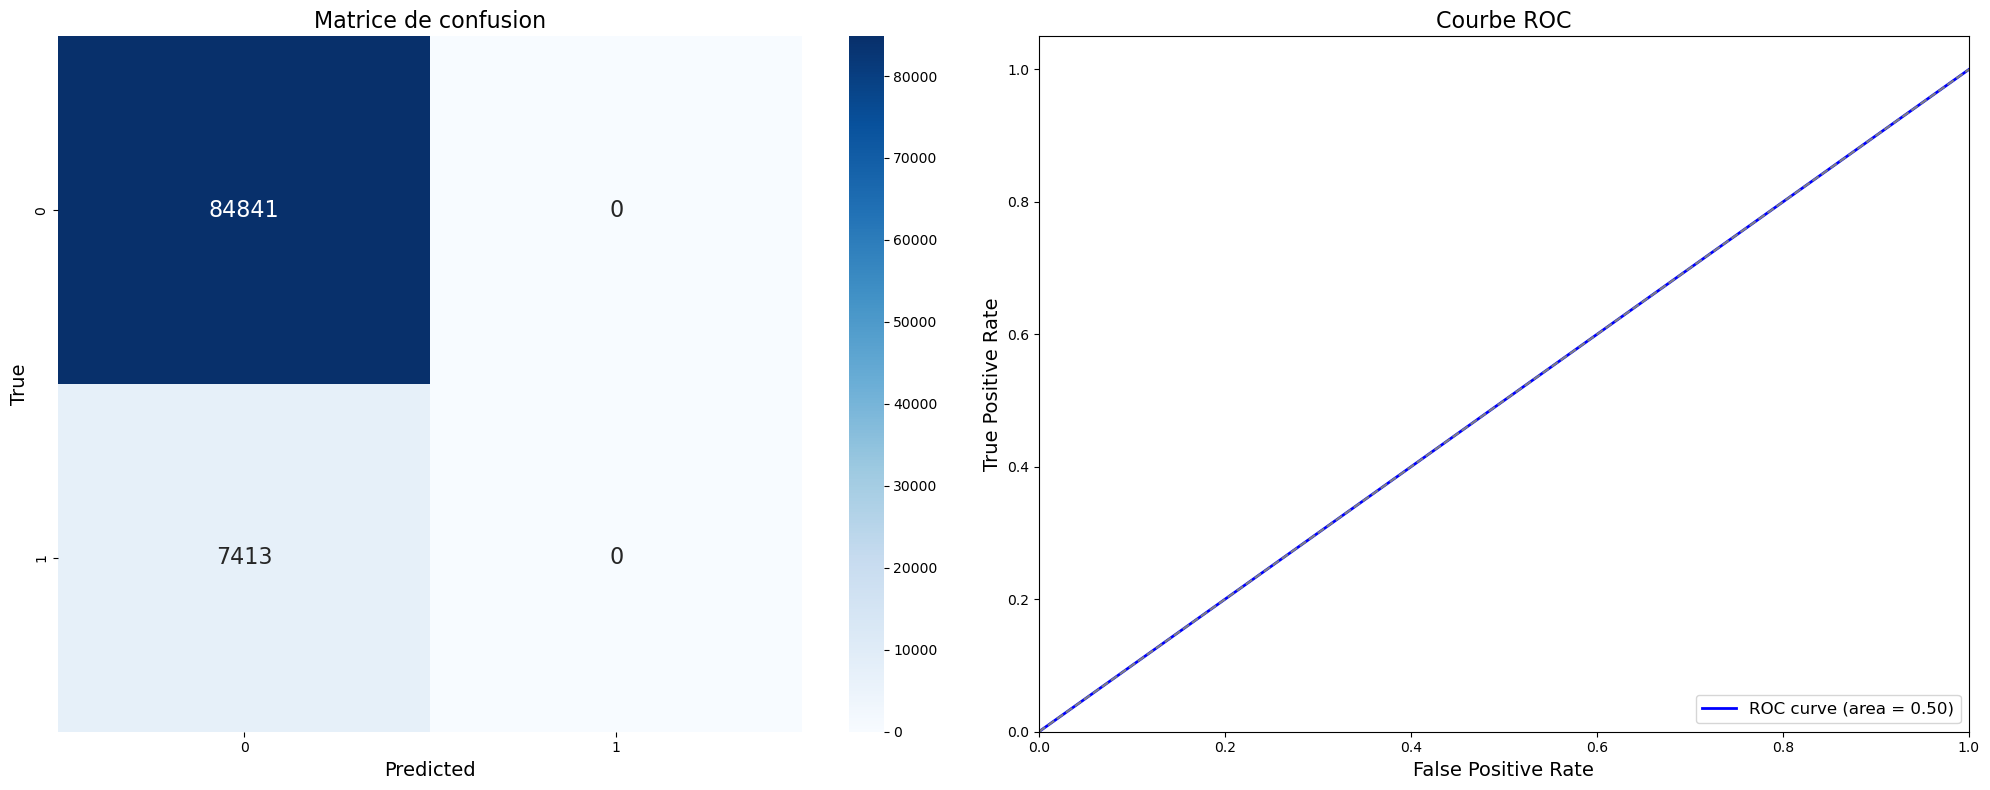

In [20]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

- **AUC_mean** : 0.5  
  Cela indique que le modèle a une performance au niveau du hasard pour la classification binaire. Une AUC de 0.5 signifie que le modèle ne distingue pas mieux entre les classes que si les prédictions étaient aléatoires.

- **Accuracy_mean**
  
  L'accuracy semble élevée, mais pour un `Dummy Classifier` utilisant la stratégie `most_frequent`, ce score élevé pourrait indiquer que la classe majoritaire occupe une proportion importante dans les données. Cela signifie que le modèle prédit la classe la plus fréquente, ce qui peut donner une apparence trompeusement bonne de performance dans des cas de déséquilibre des classes.

- **Fit_time_mean**   
  Le temps moyen nécessaire pour entraîner le modèle est assez faible, ce qui est attendu car le `Dummy Classifier` est très simple.

- **Score_time_mean**   
  Le temps moyen pour faire des prédictions est aussi très faible, ce qui est normal pour ce type de modèle.

Ces résultats montrent que le `Dummy Classifier` est utile comme point de référence. Un modèle plus sophistiqué devrait idéalement obtenir une AUC plus élevée et être capable de mieux distinguer entre les classes. Les prochaines étapes consisteront probablement à comparer ces résultats avec ceux des modèles plus complexes pour évaluer leur performance relative.

## 2.2 - Régression logistique

La régression logistique est un modèle statistique utilisé principalement pour des tâches de classification binaire. Contrairement à une régression linéaire qui prédit une valeur continue, la régression logistique prédit la probabilité qu'un échantillon appartienne à une classe donnée. En sortie, elle donne des probabilités comprises entre 0 et 1, qui peuvent être ensuite converties en classes (0 ou 1) en fonction d'un seuil.

En tant que premier modèle de base, la régression logistique nous permettra d'établir une baseline pour prédire la probabilité de défaut de paiement. En testant le modèle avant et après l'application de SMOTE, nous allons comparer l'impact du rééquilibrage des classes sur les performances du modèle.
L'application de SMOTE avant l'entraînement d'une régression logistique peut potentiellement améliorer les performances, notamment sur des données déséquilibrées, car elle crée de nouveaux échantillons dans la classe minoritaire.

Pour un réglage simple et rapide des hyperparamètres de notre régression logistique, nous allons utiliser `GridSearchCV` avec un espace de recherche limité.
Ce réglage simple vous permettra de trouver rapidement des hyperparamètres qui améliorent le modèle sans passer trop de temps à la recherche.

In [22]:
# Définir le modèle
model = LogisticRegression(random_state=42)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Effectuer la recherche
grid_search.fit(X_train_split, y_train_split)

# Afficher les meilleurs paramètres
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Meilleurs paramètres : {'C': 1, 'penalty': 'l2'}


Le paramètre `n_jobs` est couramment utilisé dans scikit-learn pour spécifier combien de cœurs de processeur doivent être utilisés pour exécuter les opérations en parallèle. Voici un guide sur comment utiliser `n_jobs` pour accélérer l'entraînement de vos modèles :

- **`n_jobs=-1`** : Utilise **tous** les cœurs disponibles sur votre machine. Cela maximise la parallélisation et peut réduire le temps d'entraînement, surtout si vous travaillez avec de grands ensembles de données.
- **`n_jobs=1`** (ou ne pas spécifier) : Utilise un seul cœur (c'est le comportement par défaut).
- **`n_jobs=N`** : Utilise exactement **N** cœurs de processeur. Par exemple, `n_jobs=4` utilisera 4 cœurs.

In [23]:
# On va définir le/les modèle(s)
models = {
    'Régression Logistique': LogisticRegression(C=1, penalty='l2', max_iter=1000, n_jobs=-1, random_state=42)
}

In [24]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

Registered model 'Régression Logistique-classification-model' already exists. Creating a new version of this model...
2024/10/25 15:38:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Régression Logistique-classification-model, version 3
Created version '3' of model 'Régression Logistique-classification-model'.
2024/10/25 15:38:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Régression Logistique at: http://localhost:5000/#/experiments/530820720891640535/runs/0a7c6ac25cac4a87b7a72d476698aca4.
2024/10/25 15:38:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/530820720891640535.


,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Régression Logistique,0.757946,0.919269,26.498932,16.948612


Évaluation du modèle: Régression Logistique
Accuracy: 0.9202
AUC: 0.7598
Precision: 0.5851
Recall: 0.0223
F1-score: 0.0429

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84724                 117
True Positive                7248                 165


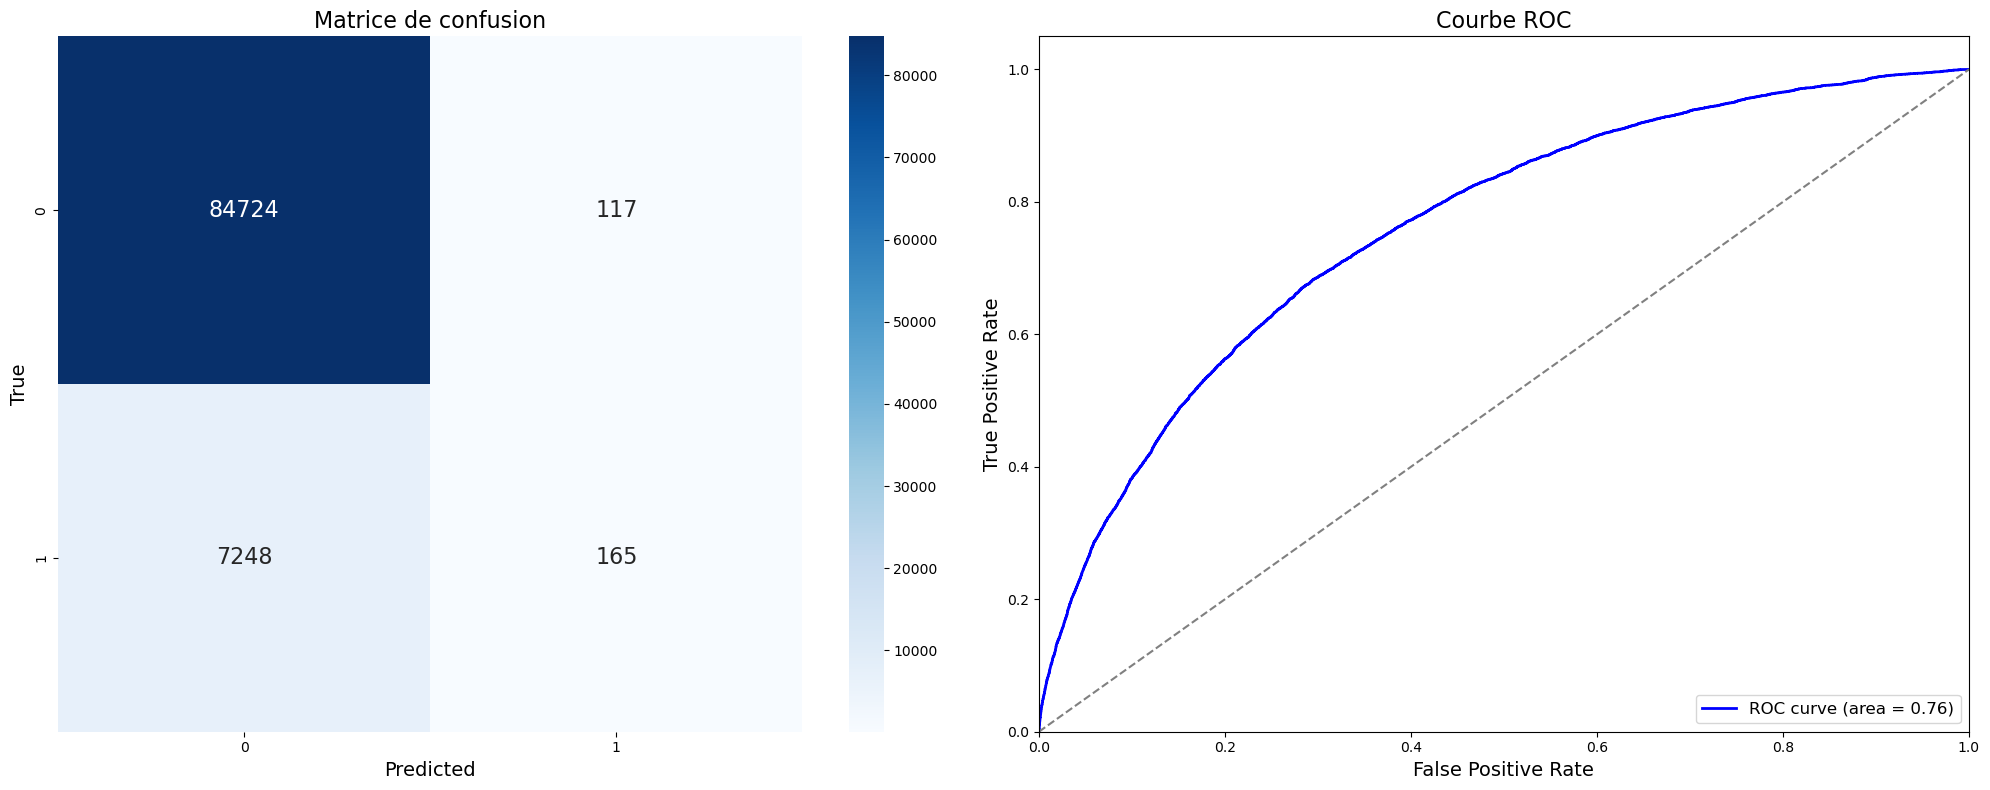

In [25]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

Les résultats de la régression logistique avant l'application de SMOTE montrent des performances satisfaisantes mais trompeuses :

- **AUC_mean** : 0.75 — Cela signifie que le modèle parvient à différencier les classes positives et négatives avec une bonne précision.
- **Accuracy** : 92 % — Le modèle est capable de prédire correctement environ 92 % des exemples.
- **Matrice de confusion** :
  - **True Negative** : Le modèle prédit correctement que 84 730 échantillons n'appartiennent pas à la classe positive.
  - **True Positive** : Seulement 165 échantillons de la classe positive sont correctement prédits.
  - **False Negative** : Il y a un nombre significatif d'échantillons de la classe positive qui sont incorrectement classés comme négatifs.

Nous pouvons analyser cela de la manière suivante :
- **AUC** : le modèle parvient à bien capturer les relations dans les données, mais il pourrait encore être amélioré.
- **Matrice de confusion** : Le nombre élevé de faux négatifs par rapport au nombre relativement faible de vrais positifs est un signe que le modèle a du mal à identifier correctement la classe minoritaire (les défauts de paiement).

Après SMOTE, nous pourrons comparer ces résultats pour évaluer si le rééquilibrage des classes améliore la capacité du modèle à prédire la classe minoritaire. Il serait intéressant de voir si le nombre de vrais positifs augmente après SMOTE, tout en maintenant un bon compromis avec le nombre de faux positifs et la précision globale.

## 2.3 - Random Forest

**Random Forest** est un algorithme d'apprentissage automatique puissant et polyvalent utilisé pour des tâches de classification et de régression. Il fonctionne en construisant un ensemble d'arbres de décision, chacun entraîné sur un sous-ensemble aléatoire des données d'entraînement. La décision finale est obtenue par le vote majoritaire des arbres (dans le cas de la classification) ou par la moyenne des prédictions (dans le cas de la régression). 

L'un des principaux avantages de Random Forest est sa capacité à gérer des ensembles de données de grande taille avec un grand nombre de caractéristiques, tout en réduisant le risque de surajustement grâce à l'agrégation des résultats. Il est également robuste face aux valeurs manquantes et aux données bruitées. 

Les hyperparamètres tels que le nombre d'arbres (`n_estimators`) et la profondeur maximale des arbres (`max_depth`) peuvent être ajustés pour améliorer les performances. Random Forest est souvent utilisé comme une méthode de référence en raison de sa performance élevée et de sa simplicité d'utilisation.

In [26]:
# Définir les paramètres à tester
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
}

# Configuration de GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Entraînement sur l'ensemble d'entraînement
grid_search.fit(X_train_split, y_train_split)

# Affichage des meilleurs paramètres
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Meilleurs paramètres : {'max_depth': 10, 'n_estimators': 100}


In [27]:
# On va définir le/les modèle(s)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

In [28]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

Registered model 'Random Forest-classification-model' already exists. Creating a new version of this model...
2024/10/25 15:51:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest-classification-model, version 3
Created version '3' of model 'Random Forest-classification-model'.
2024/10/25 15:51:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest at: http://localhost:5000/#/experiments/530820720891640535/runs/7fb8c2783bf34692ad54dd83f8579b32.
2024/10/25 15:51:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/530820720891640535.


,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Random Forest,0.740938,0.919157,33.648273,8.870498


Évaluation du modèle: Random Forest
Accuracy: 0.9197
AUC: 0.7420
Precision: 0.6500
Recall: 0.0018
F1-score: 0.0035

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84834                   7
True Positive                7400                  13


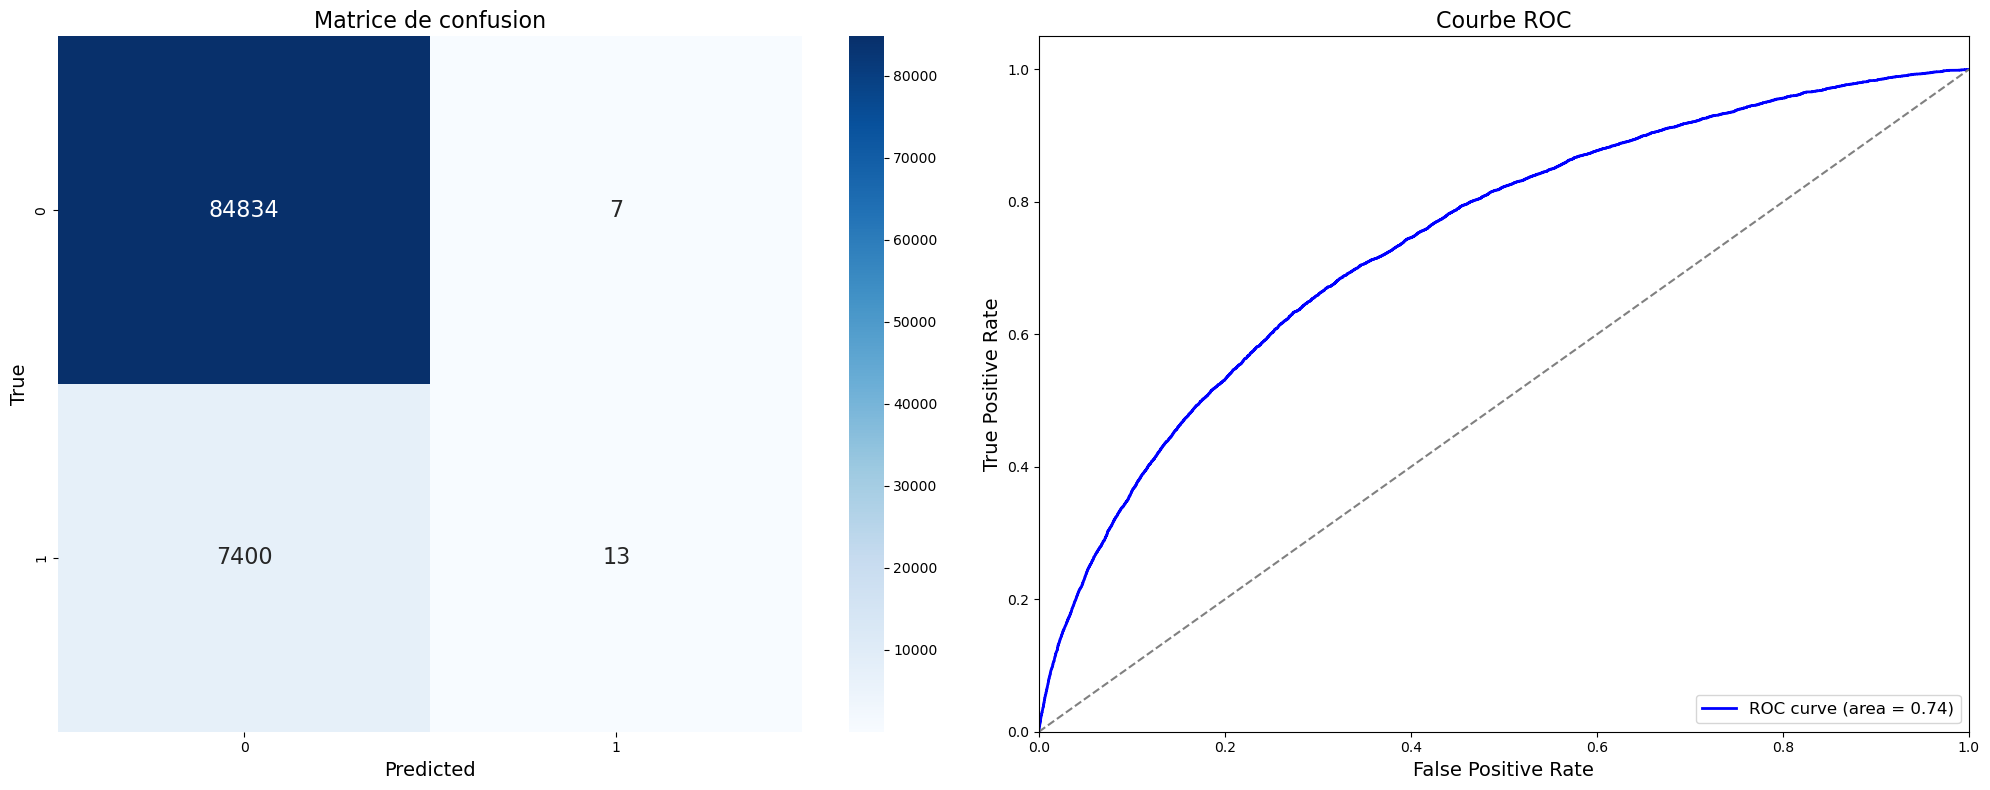

In [29]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

L'accuracy peut être trompeuse dans des cas de déséquilibre de classes, comme c'est le cas ici. Bien que l'AUC soit acceptable, elle est relativement basse, surtout pour un problème de classification binaire.

La précision est de 65 %, ce qui signifie que parmi toutes les prédictions positives faites par le modèle, 65 % sont effectivement correctes. Cela suggère que le modèle fait quelques erreurs, mais que lorsqu'il prédit un positif, il est souvent correct.

Le rappel est extrêmement faible à 0,18 %. Cela signifie que le modèle n'identifie presque pas les vrais positifs (c'est-à-dire les clients qui font défaut). Cela indique un problème significatif, surtout dans un modèle de scoring crédit, où manquer des clients à risque (faux négatifs) peut avoir des conséquences coûteuses.

Le F1-score est très bas, ce qui reflète l'inefficacité du modèle à équilibrer la précision et le rappel. Une faible valeur indique que le modèle est mauvais pour prédire les classes positives. Un F1-score aussi bas suggère que le modèle a des performances très médiocres, surtout pour la classe minoritaire (défaut).

## 2.4 - Gradient Boosting

Le **Gradient Boosting** est une technique de machine learning supervisée utilisée principalement pour les tâches de classification et de régression. Il repose sur l'idée de combiner plusieurs modèles simples (généralement des arbres de décision) pour former un modèle plus performant. Le principe clé du Gradient Boosting est de construire ces modèles séquentiellement, où chaque modèle essaie de corriger les erreurs commises par les modèles précédents. 

Le modèle final est donc une combinaison pondérée de ces modèles faibles, où les modèles successifs "boostent" les performances des précédents en se concentrant sur les observations mal prédictes.

Le **Gradient Boosting** peut être coûteux en termes de calcul et de temps d'entraînement, car il construit les arbres de manière séquentielle. Pour répondre à ce problème, deux algorithmes populaires, **XGBoost** et **LGBM**, ont été développés pour optimiser cette approche.

1. **XGBoost (Extreme Gradient Boosting)**

**XGBoost** est une implémentation optimisée de l'algorithme de Gradient Boosting qui est particulièrement efficace pour les grandes bases de données. Il se distingue par sa rapidité et son efficacité, grâce à plusieurs optimisations importantes :
- **Traitement parallèle** : Contrairement au Gradient Boosting classique qui construit les arbres séquentiellement, XGBoost permet d'entraîner les arbres en parallèle, ce qui réduit considérablement le temps d'exécution.
- **Régularisation** : XGBoost intègre des termes de régularisation (L1 et L2) pour éviter le surapprentissage, en forçant le modèle à être plus simple.
- **Gestion des valeurs manquantes** : XGBoost gère naturellement les données manquantes en apprenant des chemins optimaux pour les valeurs manquantes dans les arbres de décision.


2. **LGBM (LightGBM)**

**LightGBM** est une autre implémentation optimisée du Gradient Boosting, développée par Microsoft. **LGBM** se distingue par sa capacité à traiter de très grands volumes de données de manière encore plus rapide que XGBoost grâce à une approche de construction d'arbres appelée **Leaf-wise Tree Growth** :
- **Growth Leaf-Wise** : Contrairement à XGBoost qui ajoute des niveaux à chaque arbre (Level-wise), LGBM choisit d'ajouter des feuilles uniquement aux branches qui réduisent le plus l'erreur. Cela permet d'obtenir des arbres plus profonds et plus efficaces sans augmenter significativement le coût de calcul.
- **Gestion des grandes bases de données** : LGBM est particulièrement efficace pour des datasets volumineux ou très dimensionnels.
- **Optimisation de la mémoire** : LGBM a été conçu pour être plus économe en mémoire que XGBoost, ce qui est un avantage pour des tâches de grande échelle.

In [30]:
# Nettoyage des noms de colonnes en supprimant les caractères spéciaux
X_train_split.columns = X_train_split.columns.str.replace(r'[^\w]', '_', regex=True)
#X_train_split_smote.columns = X_train_split_smote.columns.str.replace(r'[^\w]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^\w]', '_', regex=True)

In [31]:
# Définir les paramètres à tester pour LGBM
param_grid_lgb = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1]
}

# Définir les paramètres à tester pour XGBoost
param_grid_xgb = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Création du GridSearch pour LGBM
grid_lgb = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42, device='gpu'),
                         param_grid=param_grid_lgb,
                         scoring='roc_auc',
                         cv=3, n_jobs=-1)

# Entraînement
grid_lgb.fit(X_train_split, y_train_split)

# Affichage des meilleurs paramètres et du score
print(f"Meilleurs paramètres LGBM : {grid_lgb.best_params_}")
print(f"Meilleur score AUC LGBM : {grid_lgb.best_score_}")

# Création du GridSearch pour XGBoost
grid_xgb = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, tree_method='gpu_hist'),
                         param_grid=param_grid_xgb,
                         scoring='roc_auc',
                         cv=3, n_jobs=-1)

# Entraînement
grid_xgb.fit(X_train_split, y_train_split)

# Affichage des meilleurs paramètres et du score
print(f"Meilleurs paramètres XGBoost : {grid_xgb.best_params_}")
print(f"Meilleur score AUC XGBoost : {grid_xgb.best_score_}")

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35598
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 320
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 126 dense feature groups (26.28 MB) transferred to GPU in 0.009962 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
Meilleurs paramètres LGBM : {'learning_rate': 0.1, 'num_leaves': 31}
Meilleur score AUC LGBM : 0.7713584514324007
Meilleurs paramètres XGBoost : {'learning_rate': 0.1, 'max_depth': 5}
Meilleur score AUC XGBoost : 0.7716500266644651


In [32]:
# On va définir le/les modèle(s) avec les meilleurs hyperparamètres
models = {
    'LGBM Classifier': lgb.LGBMClassifier(
        learning_rate=0.1, 
        num_leaves=31, 
        random_state=42, 
        device='gpu'
    ),
    'XGBoost': xgb.XGBClassifier(
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42, 
        tree_method='gpu_hist'
    )
}

In [33]:
# Vérification GPU (XGBoost)
print(f"XGBoost GPU status: {xgb.XGBClassifier(tree_method='gpu_hist').get_xgb_params()}")

XGBoost GPU status: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


In [34]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35598
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 320
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 126 dense feature groups (26.28 MB) transferred to GPU in 0.008146 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324


Registered model 'LGBM Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/25 16:06:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM Classifier-classification-model, version 4
Created version '4' of model 'LGBM Classifier-classification-model'.
2024/10/25 16:06:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM Classifier at: http://localhost:5000/#/experiments/530820720891640535/runs/188665ee23fd4b55a8c171c2672198c3.
2024/10/25 16:06:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/530820720891640535.
Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/25 16:06:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 16

,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,LGBM Classifier,0.773913,0.919538,8.233779,2.317797
1,XGBoost,0.772661,0.919640,10.343730,1.558867


Évaluation du modèle: LGBM Classifier
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35598
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 320
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 126 dense feature groups (26.28 MB) transferred to GPU in 0.010159 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
Accuracy: 0.9200
AUC: 0.7760
Precision: 0.5423
Recall: 0.0294
F1-score: 0.0558

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84657                 184
True Positive

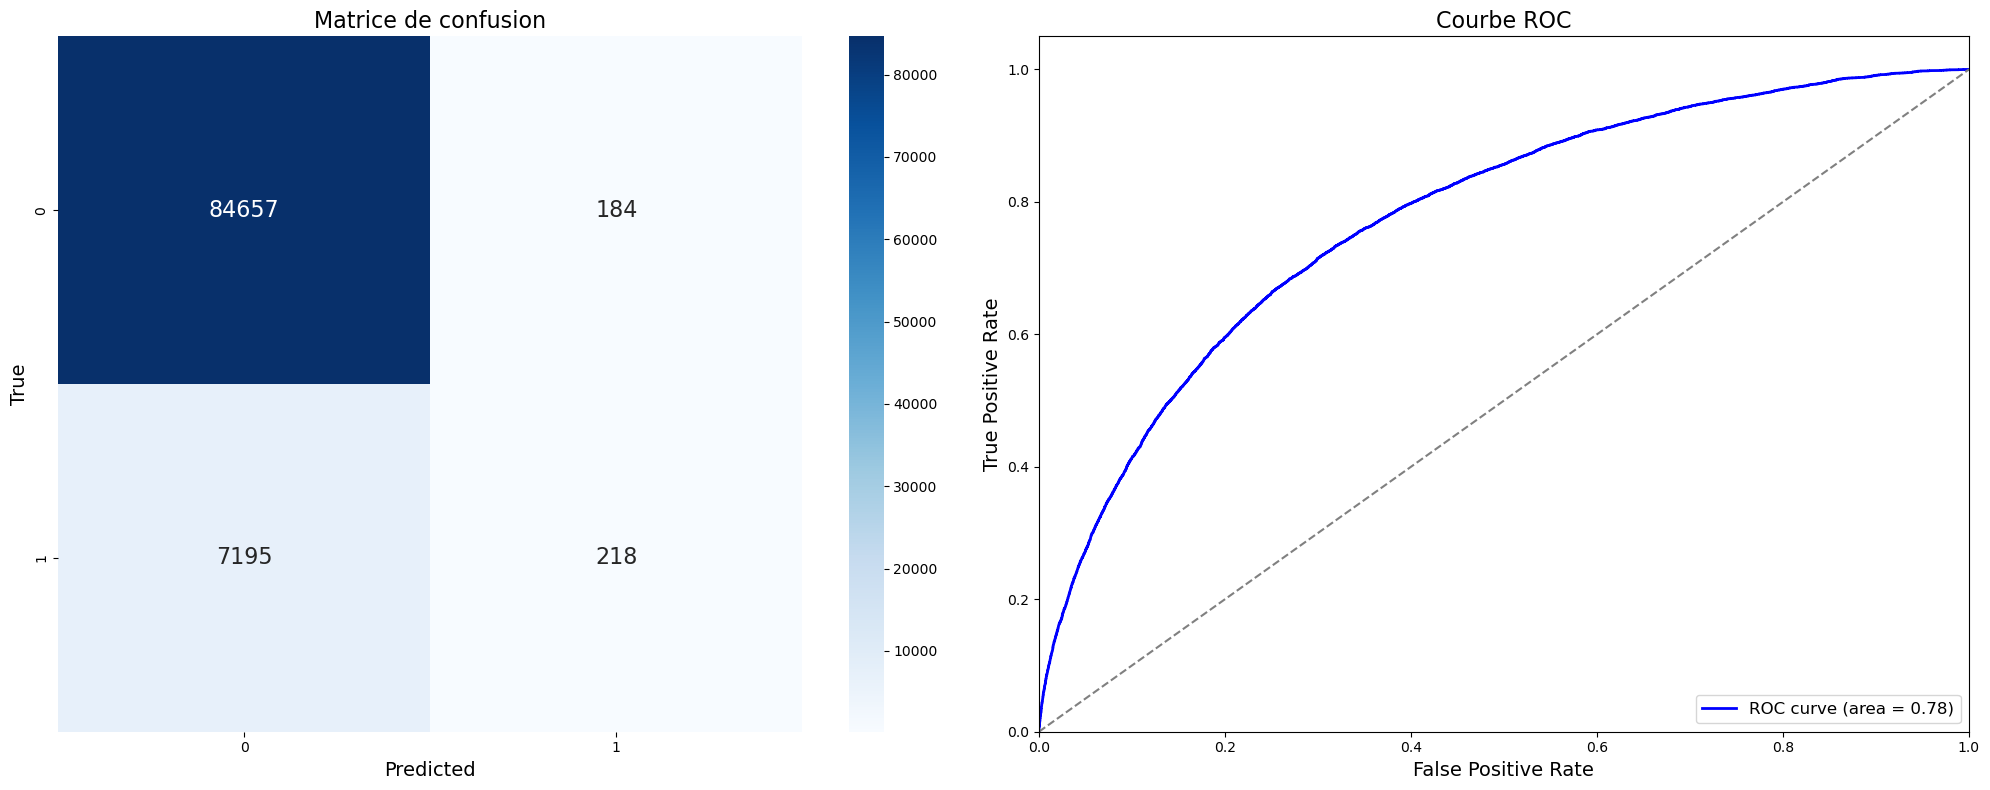

Évaluation du modèle: XGBoost
Accuracy: 0.9200
AUC: 0.7731
Precision: 0.5833
Recall: 0.0170
F1-score: 0.0330

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84751                  90
True Positive                7287                 126


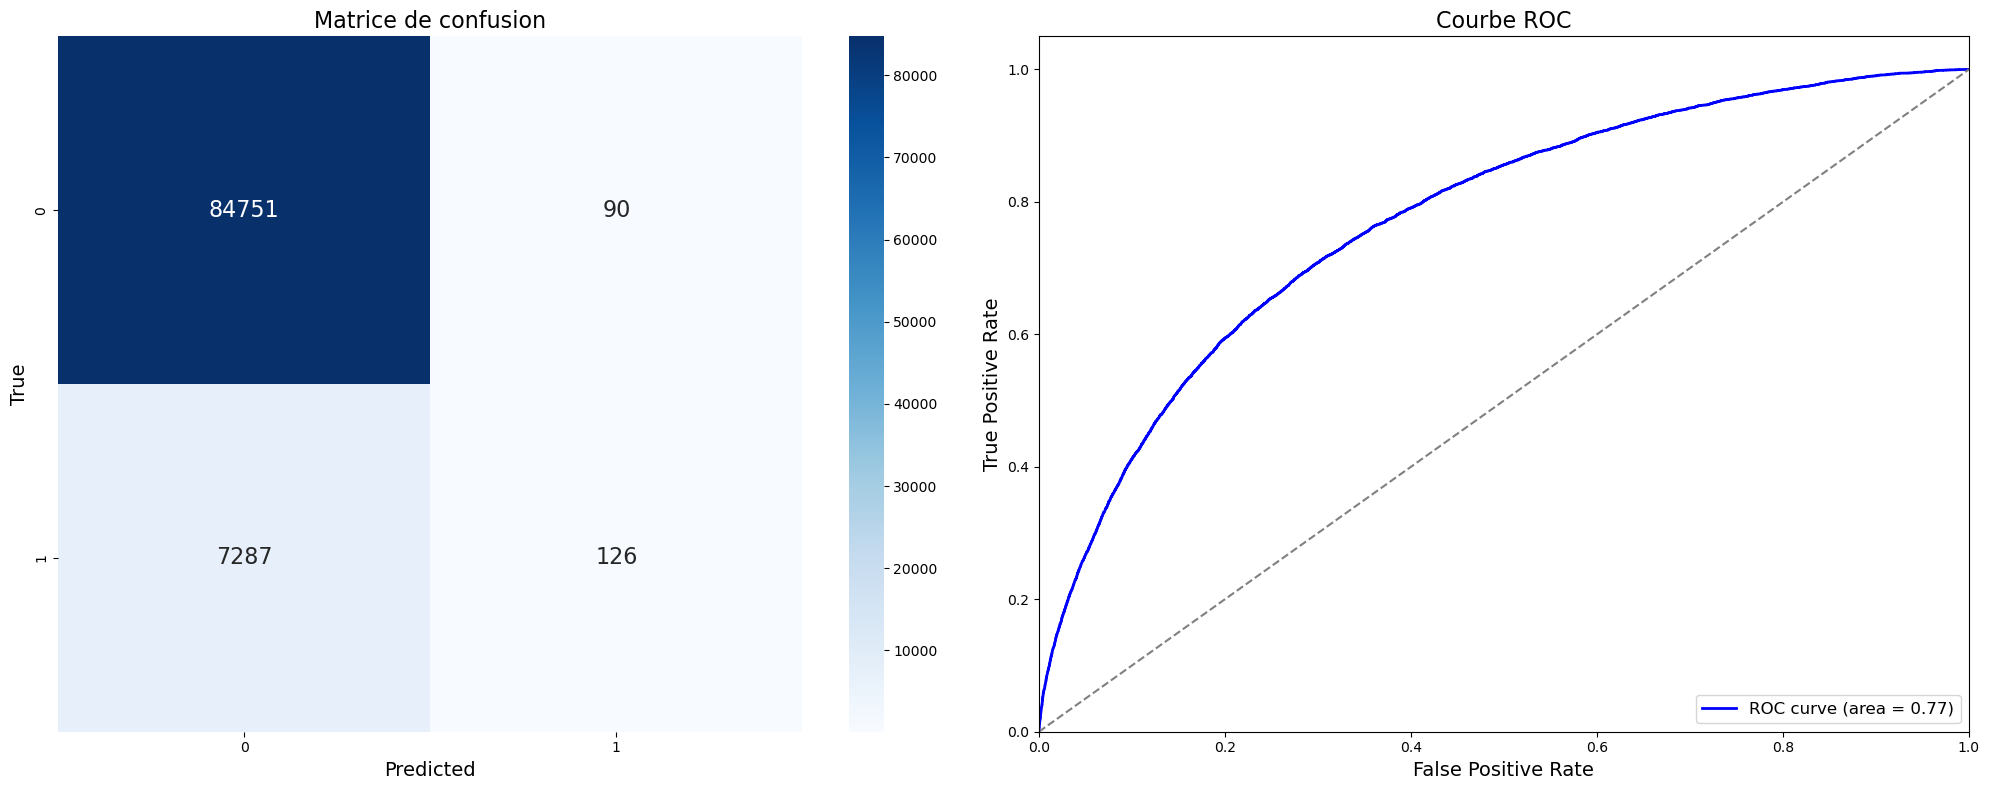

In [35]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

Voici une analyse rapide des résultats obtenus avant l'application de **SMOTE** pour les deux modèles **LGBM Classifier** et **XGBoost** :

**LGBM Classifier :**
- **AUC_mean** : 0.77 – Un score AUC qui montre une bonne capacité de discrimination. Cela indique que le modèle parvient à bien différencier entre les classes positives (clients en défaut) et négatives (clients non en défaut).
- **Accuracy_mean** : 0.91 – Le modèle atteint une très bonne précision, ce qui reflète la proportion de prédictions correctes.
- **Fit_time_mean** : 8.98 secondes – L'entraînement du modèle est assez rapide.
- **Score_time_mean** : 0.1820 seconde – Le temps pour réaliser les prédictions est également très court, ce qui est un atout pour les systèmes de scoring en temps réel.

**XGBoost :**
- **AUC_mean** : 0.76 – Légèrement inférieur à celui de LGBM, mais reste un score solide qui montre une bonne capacité de discrimination.
- **Accuracy_mean** : 0.91 – Un peu plus bas que LGBM, mais reste très élevé et performant.
- **Fit_time_mean** : 13.12 secondes – L'entraînement de XGBoost est un peu plus long que celui de LGBM, ce qui est habituel étant donné l'approche plus intensive de XGBoost.
- **Score_time_mean** : 0.4146 seconde – Le temps de prédiction est environ deux fois plus long que LGBM, mais reste raisonnable pour des systèmes de production.

**Comparaison globale :**
- **Performance** : LGBM affiche de meilleures performances en termes de score AUC et de précision, bien que les deux modèles soient assez proches.
- **Temps d'exécution** : LGBM est plus rapide à l'entraînement et pour la prédiction, ce qui peut en faire un candidat plus efficace dans des contextes où la rapidité est cruciale.

# 3 - Deuxième modélisation : après SMOTE

L'utilisation de **SMOTE** (*Synthetic Minority Over-sampling Technique*) est particulièrement utile lorsque l'on travaille avec des ensembles de données déséquilibrés. En data science, un ensemble de données est dit déséquilibré lorsque la répartition des classes dans la variable cible n'est pas équilibrée, c'est-à-dire que l'une des classes (par exemple, les cas de défaut de paiement) est beaucoup moins représentée que l'autre (les non-défauts).

**Pourquoi utiliser SMOTE ?**

1. **Déséquilibre des classes** : Lorsque les classes sont déséquilibrées, les algorithmes de machine learning ont tendance à biaiser leurs prédictions en faveur de la classe majoritaire. Par exemple, dans le cas d’un modèle de scoring de crédit, si les défauts de paiement (classe minoritaire) représentent seulement 5 % des observations, un modèle pourrait simplement prédire que tout le monde remboursera son prêt pour obtenir une haute précision (en ignorant totalement les 5 % de défauts).
   
2. **SMOTE pour rééquilibrer les classes** : SMOTE génère de nouvelles observations synthétiques pour la classe minoritaire en combinant plusieurs exemples existants proches dans l’espace des caractéristiques. Cela permet de rééquilibrer le jeu de données sans simplement dupliquer les observations, ce qui pourrait mener à de l'overfitting.

3. **Amélioration des performances du modèle** :
   **Meilleure sensibilité aux classes minoritaires** : Grâce à SMOTE, notre modèle pourra mieux identifier les cas appartenant à la classe minoritaire (dans notre cas, les clients à risque de défaut de paiement).
   **Précision des prédictions** : Cela évite au modèle de donner une précision trompeuse en prédisant principalement la classe majoritaire. L'utilisation de métriques comme l'**AUC-ROC** ou le **F1-Score** devient également plus pertinente car elles tiennent compte des performances sur les deux classes.
 
4. **Limitation du biais du modèle** : Sans une correction comme SMOTE, le modèle risque de négliger la classe minoritaire et de mal gérer les faux négatifs (prédire qu'un client remboursera alors qu'il va faire défaut). Dans le contexte d'un modèle de scoring crédit, cela peut avoir des conséquences importantes sur le coût métier.

**Comment fonctionne SMOTE ?**

SMOTE fonctionne en trois étapes :
1. **Sélection des points de la classe minoritaire**.
2. **Création des observations synthétiques** : Pour chaque point de la classe minoritaire, SMOTE sélectionne les k plus proches voisins (en général 5). Ensuite, il génère un point synthétique sur la ligne qui relie l'exemple de la classe minoritaire sélectionné et l'un de ses voisins.
3. **Ajout des nouvelles données au jeu d'entraînement** : Les observations synthétiques sont ajoutées au jeu d'entraînement, augmentant la proportion de la classe minoritaire.

In [36]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("2 - Deuxième modélisation : après SMOTE")

<Experiment: artifact_location='mlflow-artifacts:/352735968331881952', creation_time=1729160566917, experiment_id='352735968331881952', last_update_time=1729160566917, lifecycle_stage='active', name='2 - Deuxième modélisation : après SMOTE', tags={}>

## 3.1 - Application du SMOTE

In [37]:
# Avant SMOTE
print("Répartition des classes avant SMOTE :")
print(pd.Series(y_train_split).value_counts())

# Application de SMOTE
smote = SMOTE(random_state=42)
X_train_split_smote, y_train_split_smote = smote.fit_resample(X_train_split, y_train_split)

# Après SMOTE
print("\nRépartition des classes après SMOTE :")
print(pd.Series(y_train_split_smote).value_counts())

Répartition des classes avant SMOTE :
TARGET
0.0    197845
1.0     17412
Name: count, dtype: int64

Répartition des classes après SMOTE :
TARGET
0.0    197845
1.0    197845
Name: count, dtype: int64


## 3.2 - Entraînement des modèles

Nous allons tester les 4 modèles précédents après application de SMOTE puis comparer nos résultats.

Tester un Dummy Classifier après avoir appliqué SMOTE peut être intéressant dans certains cas, mais il faut garder à l’esprit que cela n'a pas de réel sens pratique dans un projet de modélisation. Pourquoi ?

- **SMOTE** est une méthode utilisée pour équilibrer les classes dans les jeux de données déséquilibrés en générant des échantillons synthétiques pour la classe minoritaire.
- Le **Dummy Classifier**, en revanche, est un modèle très basique qui fait des prédictions triviales (par exemple, prédire la classe majoritaire ou une prédiction aléatoire).

Ce qui pourrait arriver ?
- Après SMOTE, notre jeu de données d'entraînement sera équilibré, mais un Dummy Classifier qui utilise la stratégie "Most Frequent" ne fera que prédire les classes en fonction de la distribution originale. Si les classes sont équilibrées, ce classifieur pourrait prédire aléatoirement.
- **Résultat attendu** : Le Dummy Classifier après SMOTE pourrait avoir un score AUC ou une accuracy proches de 0.5, car il ferait des prédictions quasi-aléatoires dans un contexte où les classes sont équilibrées.

Pourquoi le tester ?
Tester un Dummy Classifier après SMOTE permet d’avoir un repère pour vérifier si les modèles plus avancés (comme ceux basés sur des algorithmes de boosting ou de régression logistique) apportent une réelle valeur ajoutée par rapport à un modèle trivial.

In [38]:
# On va définir le/les modèle(s)
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Régression Logistique': LogisticRegression(C=1, penalty='l2', max_iter=1000, n_jobs=-1, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'LGBM Classifier': lgb.LGBMClassifier(learning_rate=0.1, num_leaves=31, random_state=42, device='gpu'),
    'XGBoost': xgb.XGBClassifier(learning_rate=0.1, max_depth=5, random_state=42, tree_method='gpu_hist')
}

In [39]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split_smote, y_train_split_smote, log_to_mlflow=True)

Registered model 'Dummy Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/25 16:12:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Dummy Classifier-classification-model, version 4
Created version '4' of model 'Dummy Classifier-classification-model'.
2024/10/25 16:12:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/352735968331881952/runs/e14c23e12dee40988d8883aeec2bca88.
2024/10/25 16:12:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/352735968331881952.
Registered model 'Régression Logistique-classification-model' already exists. Creating a new version of this model...
2024/10/25 16:16:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Régression Logistique-

[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 72628
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 323
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 141 dense feature groups (54.34 MB) transferred to GPU in 0.018141 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Registered model 'LGBM Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/25 16:21:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM Classifier-classification-model, version 5
Created version '5' of model 'LGBM Classifier-classification-model'.
2024/10/25 16:21:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM Classifier at: http://localhost:5000/#/experiments/352735968331881952/runs/e882121268d342268d4a535550d71f19.
2024/10/25 16:21:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/352735968331881952.
Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/25 16:22:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 17

,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Dummy Classifier,0.500000,0.500000,2.518527,0.008000
1,Régression Logistique,0.794288,0.724272,121.982538,81.653724
2,Random Forest,0.925012,0.845255,83.695665,21.767673
3,LGBM Classifier,0.925455,0.953572,15.872367,4.329237
4,XGBoost,0.952354,0.949690,18.392580,3.472537


## 3.3 - Evaluation du modèle

Évaluation du modèle: Dummy Classifier
Accuracy: 0.9196
AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84841                   0
True Positive                7413                   0


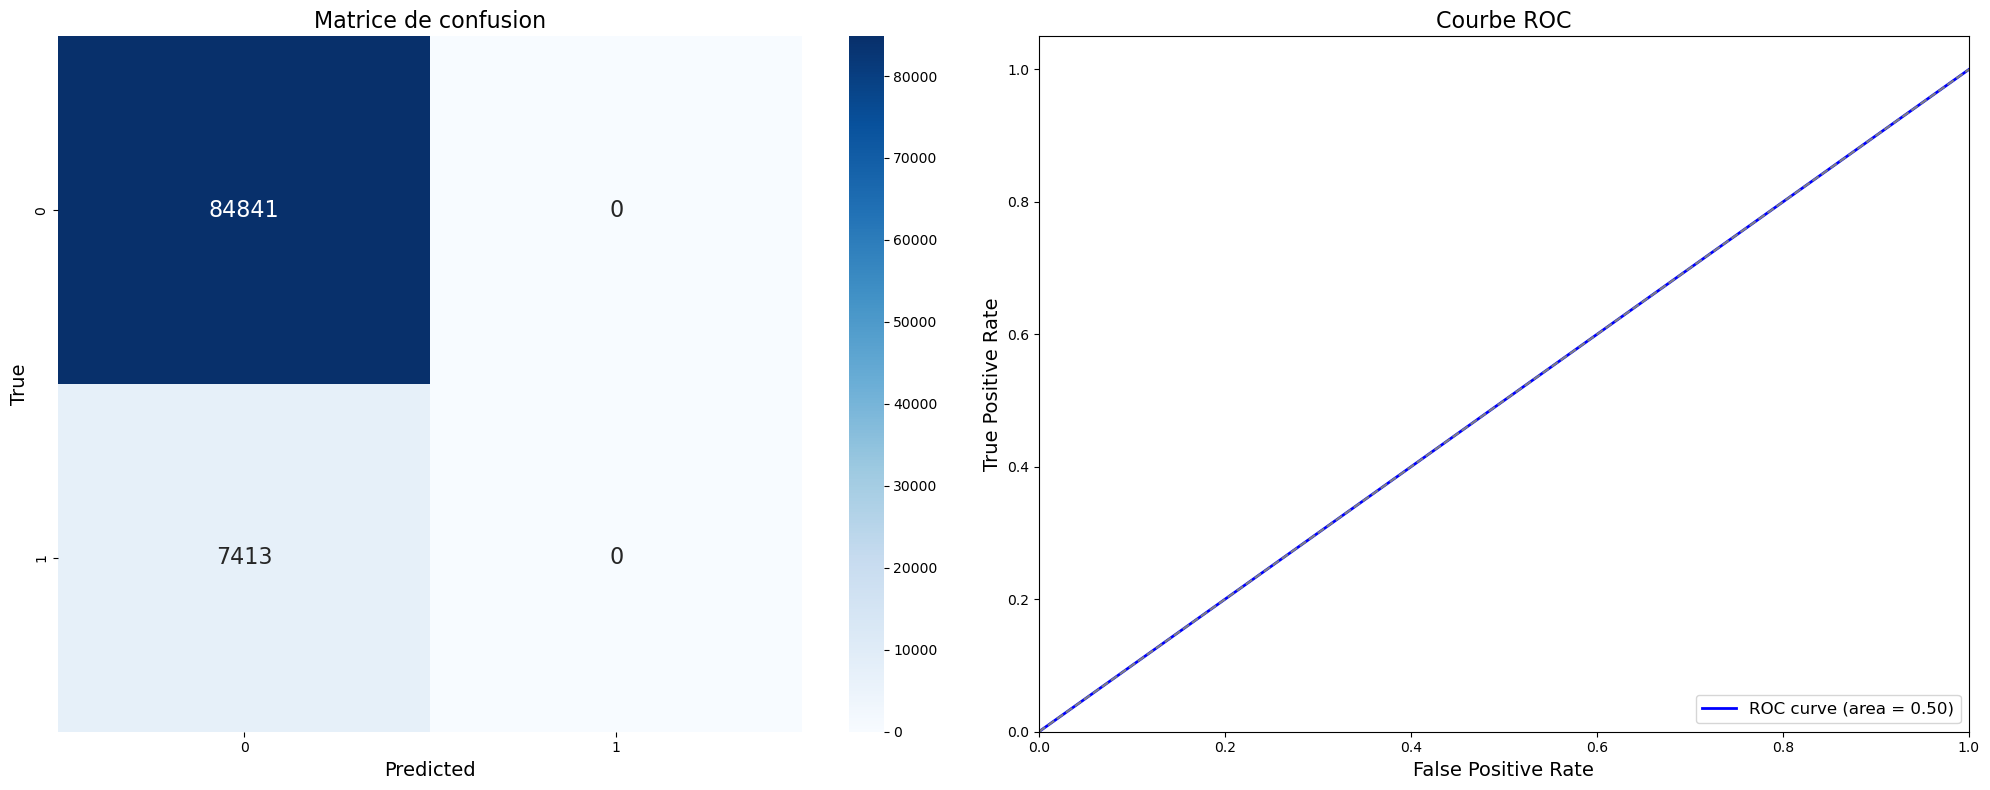

Évaluation du modèle: Régression Logistique
Accuracy: 0.7069
AUC: 0.7523
Precision: 0.1670
Recall: 0.6637
F1-score: 0.2668

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               60294               24547
True Positive                2493                4920


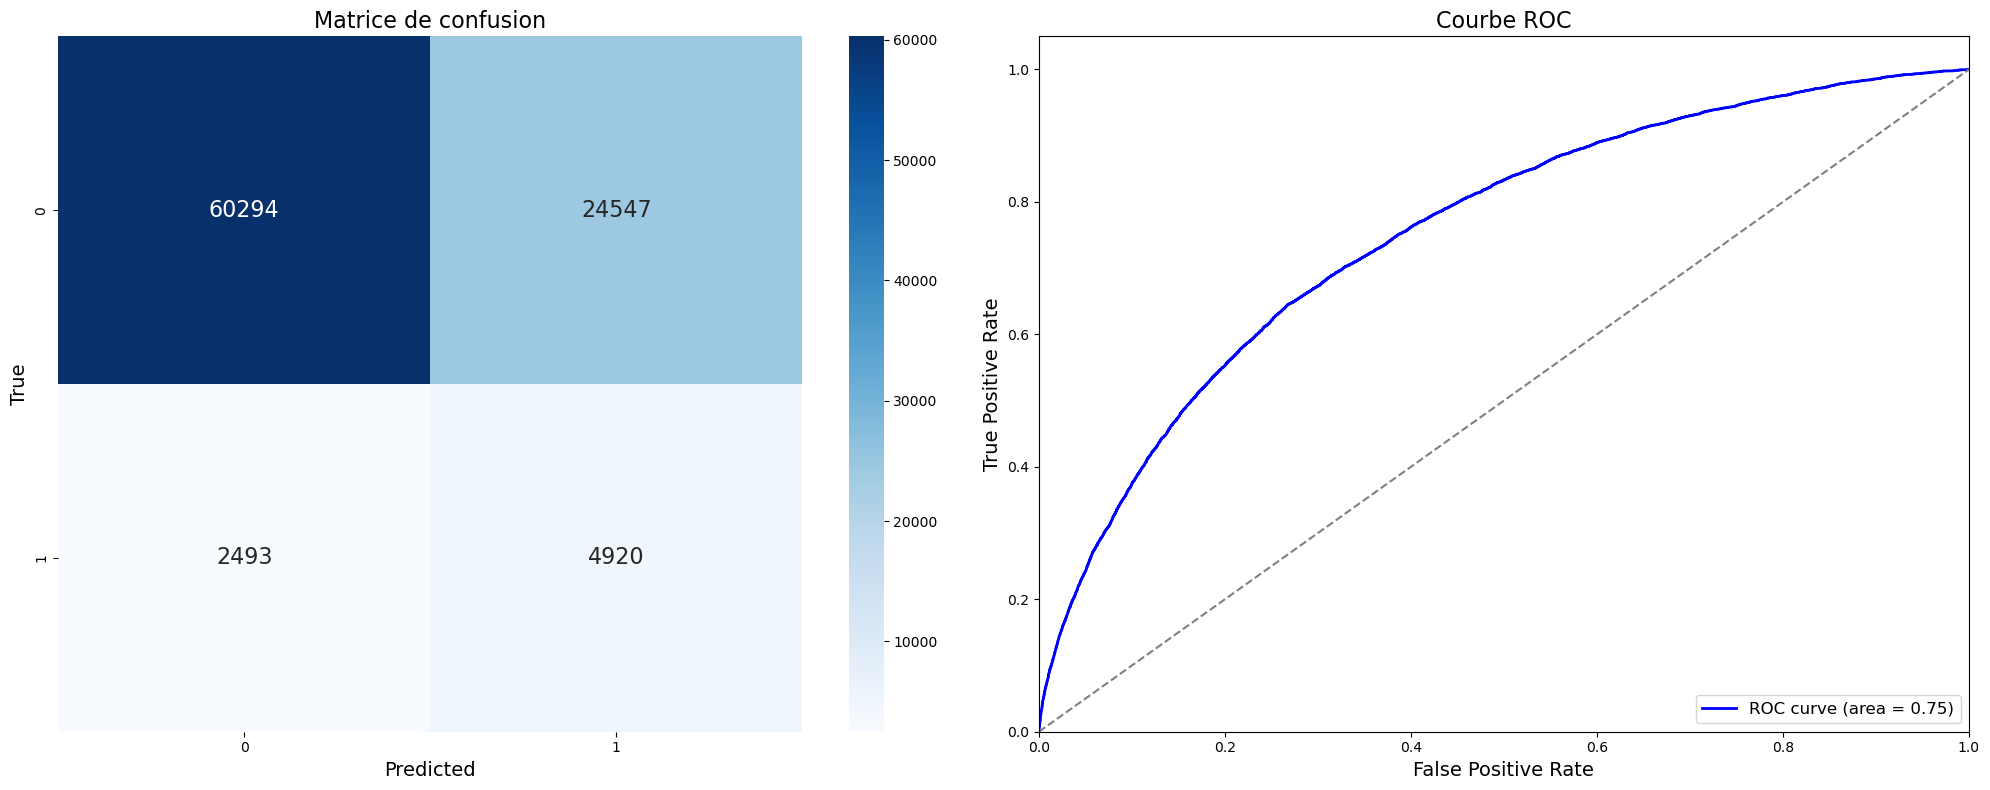

Évaluation du modèle: Random Forest
Accuracy: 0.8029
AUC: 0.7047
Precision: 0.1756
Recall: 0.3931
F1-score: 0.2427

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               71156               13685
True Positive                4499                2914


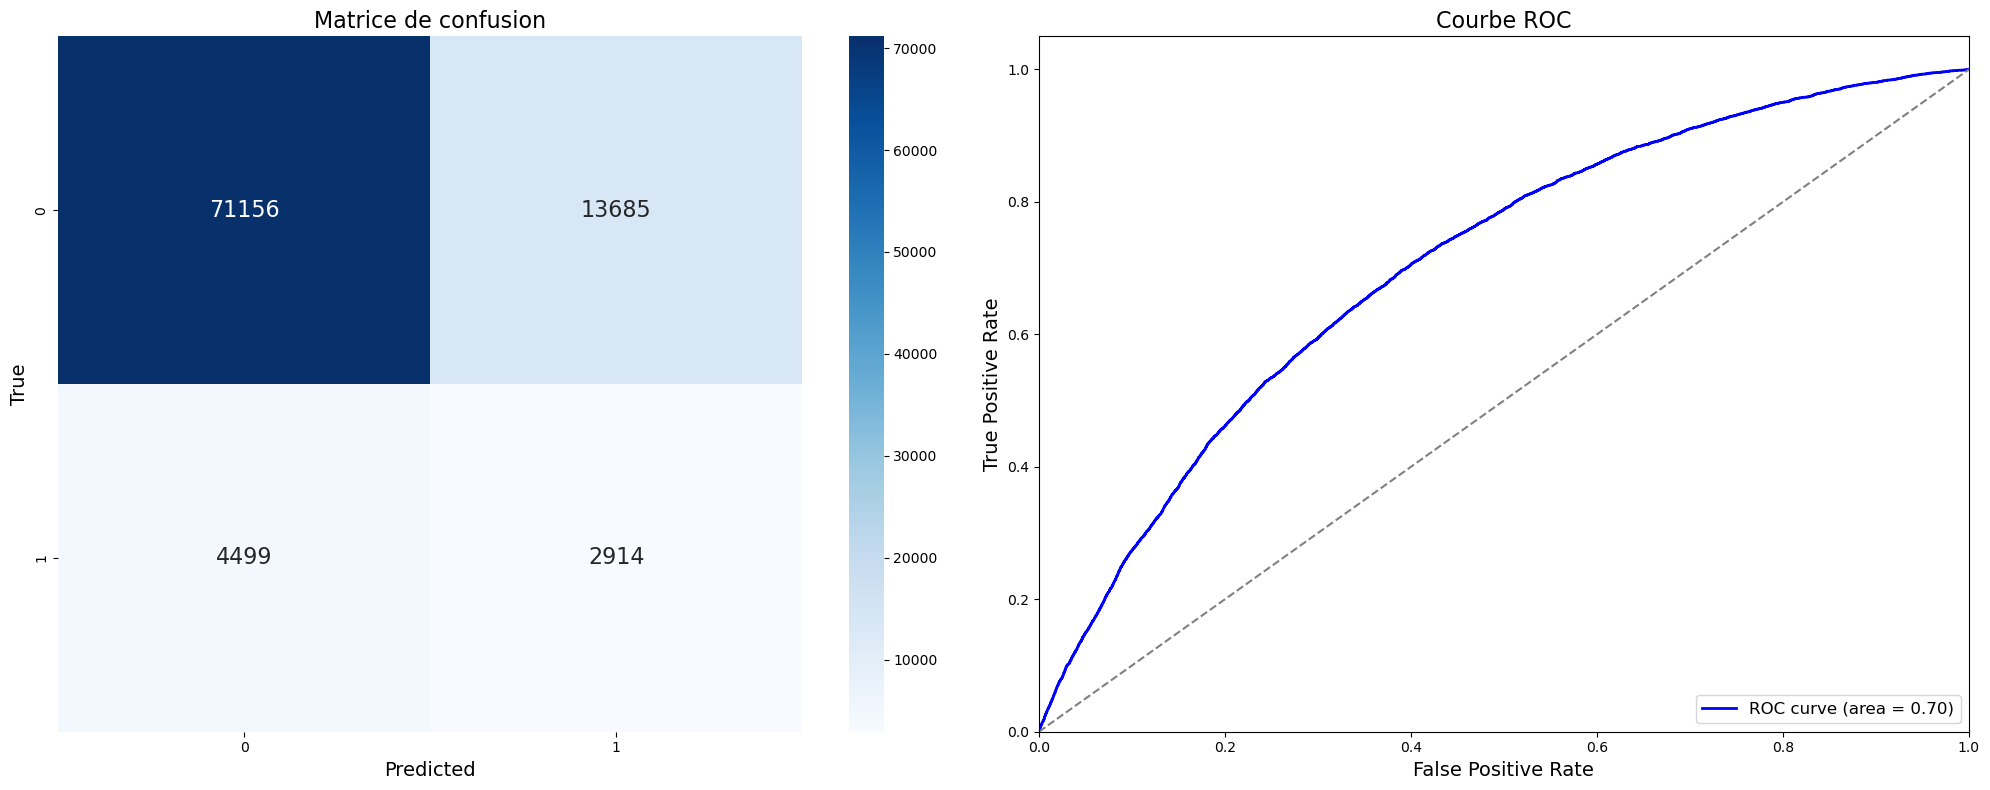

Évaluation du modèle: LGBM Classifier
[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 72628
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 323
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 141 dense feature groups (54.34 MB) transferred to GPU in 0.022393 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.9192
AUC: 0.7583
Precision: 0.4300
Recall: 0.0174
F1-score: 0.0335

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84670                 171
True Positive                7284                 129


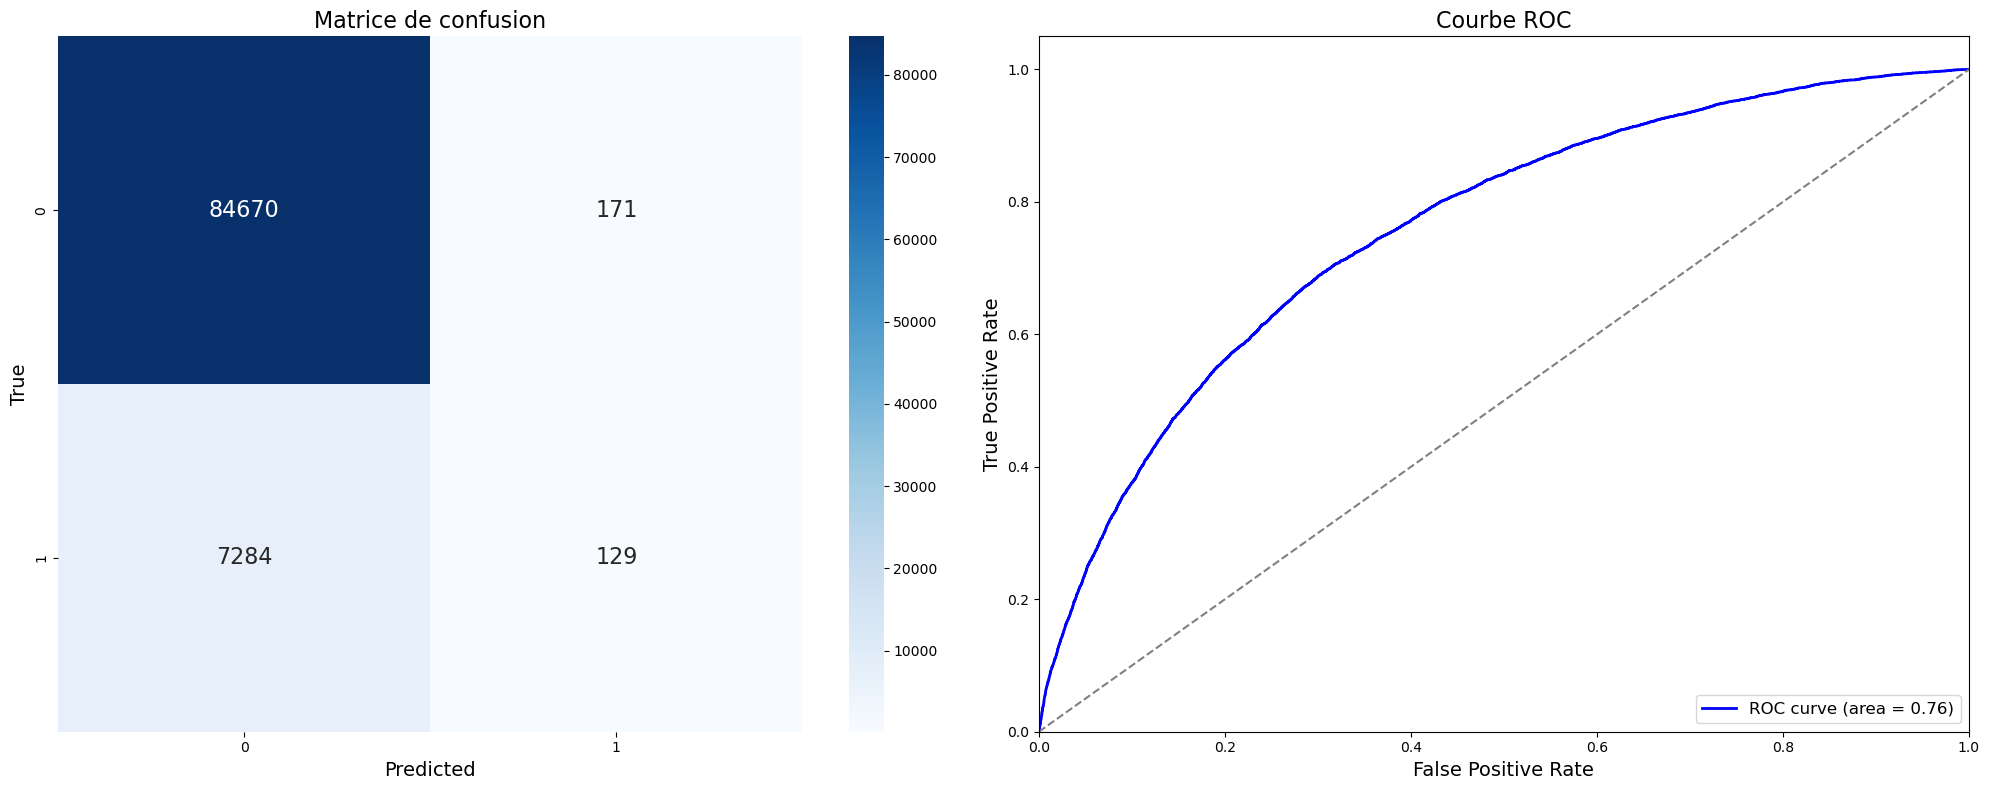

Évaluation du modèle: XGBoost
Accuracy: 0.9176
AUC: 0.7335
Precision: 0.3285
Recall: 0.0246
F1-score: 0.0457

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84469                 372
True Positive                7231                 182


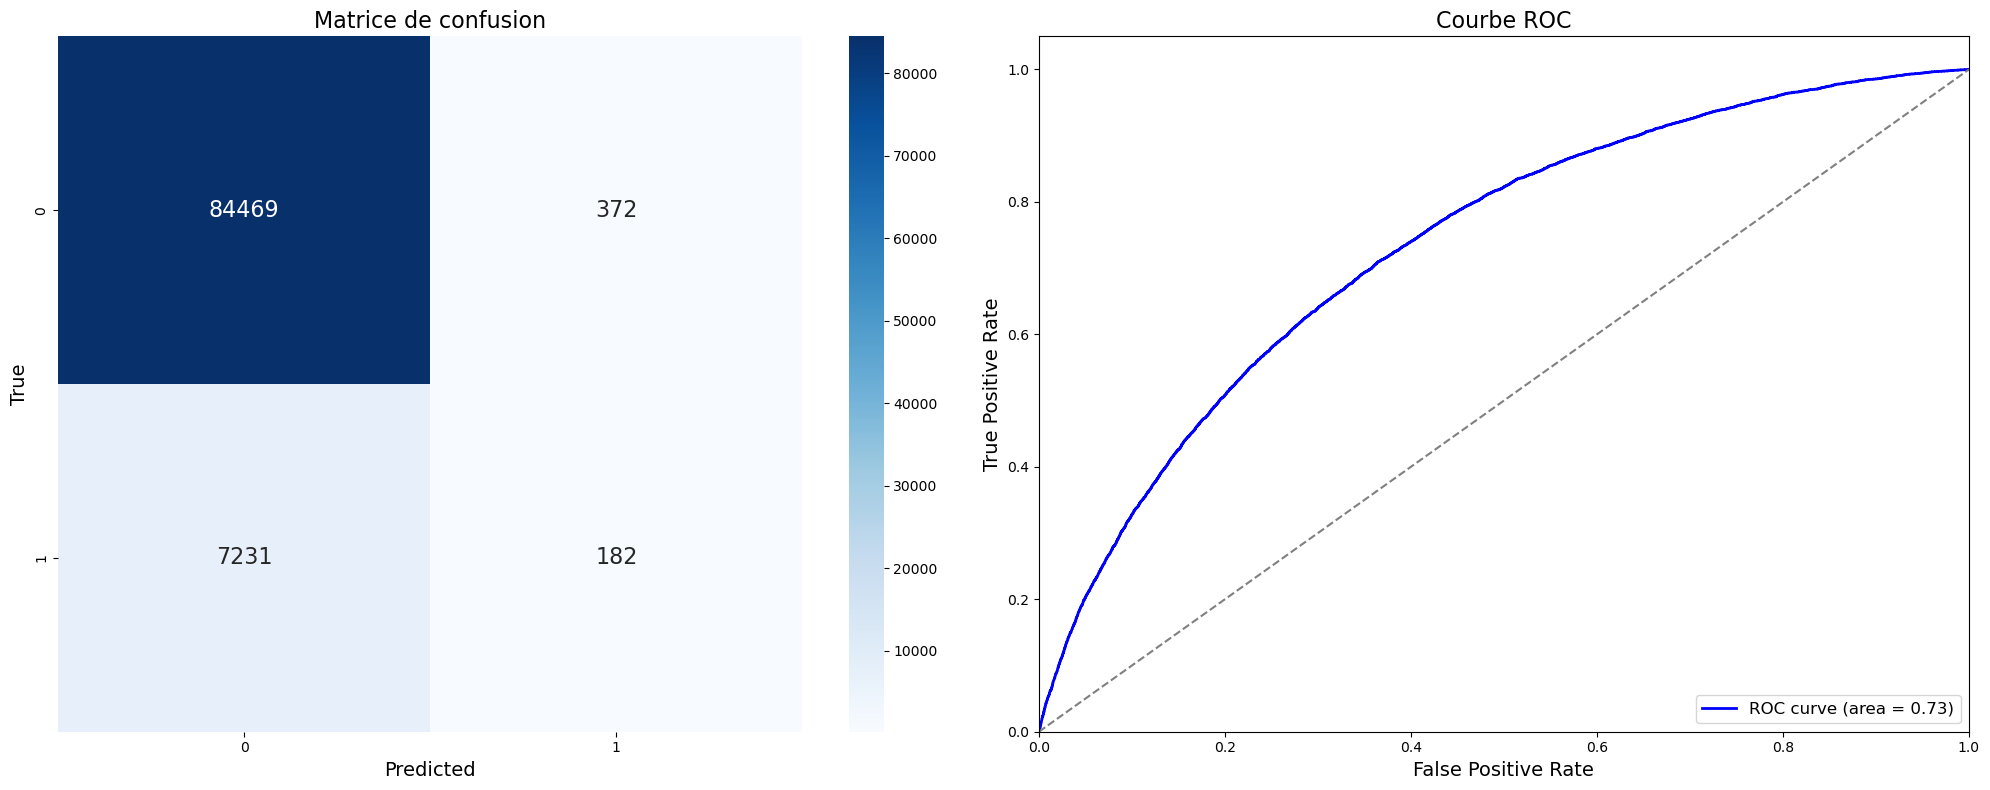

In [40]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split_smote, y_train_split_smote, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

**Analyse Globale**

- Problèmes de Déséquilibre: Tous les modèles montrent un rappel faible, ce qui suggère que même après SMOTE, les modèles peinent à détecter la classe minoritaire (les défauts de paiement). Cela est préoccupant et indique que le modèle pourrait ne pas être fiable pour prédire les défauts de paiement.

- AUC et Performance: Bien que l'accuracy semble élevée, il est crucial de se concentrer sur les métriques de précision, de rappel et d'AUC. Un modèle performant doit être capable de détecter les cas positifs tout en maintenant une précision acceptable. 

- Overfitting: Étant donné que certains modèles ont des performances bien meilleures sur l'ensemble d'entraînement par rapport à l'ensemble de validation, cela peut être un signe d'overfitting. L'utilisation de méthodes comme la validation croisée peut aider à évaluer la robustesse des modèles.

Continuer avec les modèles de gradient boosting sans utiliser SMOTE peut être une approche judicieuse, surtout dans le contexte de notre projet de scoring crédit.

**Raisons de Continuer sans SMOTE**

1. Complexité Ajoutée : SMOTE peut introduire du bruit dans les données, ce qui pourrait nuire à la performance de modèles complexes comme le gradient boosting. Si les modèles ne gèrent pas bien les données synthétiques, cela peut entraîner une détérioration des performances.

2. Évaluation Réaliste : En utilisant des données non équilibrées, nous obtiendrons une évaluation plus réaliste de la performance de nos modèles en production. Cela peut aider à éviter des surprises lorsque nous déployerons le modèle dans un environnement réel.

3. Focalisation sur les Hyperparamètres : L'optimisation des hyperparamètres des modèles de gradient boosting sans SMOTE pourrait conduire à de meilleures performances. Ces modèles, comme LGBM et XGBoost, sont souvent très sensibles aux hyperparamètres.

4. Score Métier : La création d'un score métier peut également être plus pertinente lorsque nous utilisons les données originales, car cela permettra d'adapter le modèle aux réalités de l'entreprise. Cela peut inclure la prise en compte des coûts associés aux faux positifs et faux négatifs.

# 4 - Recherche des meilleurs hyperparamètres

L'objectif principal maintenant est d'optimiser les performances des modèles choisis via le **réglage des hyperparamètres**. Pour ce faire, il serait plus efficace de procéder à une **recherche d'hyperparamètres (Grid Search ou Random Search)** combinée avec une validation croisée.

- **Pourquoi faire une validation croisée ici ?**
  - La validation croisée (CV) lors du réglage des hyperparamètres garantit l'évaluation des performances du modèle sur différentes portions du dataset, limitant ainsi les risques de surapprentissage (overfitting) sur une seule partition des données.
  - Cela est surtout important pour éviter que le modèle soit trop optimisé pour une seule division du train-test split.

Une fois que nous aurons les **meilleurs hyperparamètres** pour notre modèle, nous pourrons passer à l'étape d'élaboration du **score métier**. Cette étape peut se faire après le réglage des hyperparamètres et sur une seule division de train-test (sans validation croisée répétée), car nous nous focaliserons sur l'évaluation des **coûts associés aux erreurs de prédiction** (faux positifs et faux négatifs), en fonction des besoins spécifiques du métier.

In [41]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("3 - Hyperparameter Tuning")

<Experiment: artifact_location='mlflow-artifacts:/186178980085294922', creation_time=1729161494029, experiment_id='186178980085294922', last_update_time=1729161494029, lifecycle_stage='active', name='3 - Hyperparameter Tuning', tags={}>

## 4.1 - LGBM Classifier

Dans cette section, nous procédons à l'optimisation des hyperparamètres de notre modèle de LightGBM afin d'améliorer ses performances. L'optimisation des hyperparamètres est une étape importante dans le développement d'un modèle machine learning, car elle permet d'ajuster les paramètres du modèle pour maximiser les performances sur un ensemble de validation.

Pour ce faire, nous avons utilisé une méthode de **RandomizedSearchCV**, qui permet d'explorer un ensemble prédéfini d'hyperparamètres de manière aléatoire, tout en effectuant une validation croisée (cross-validation) sur chaque combinaison d'hyperparamètres. Cela permet de limiter le temps de calcul tout en cherchant les meilleures combinaisons de paramètres.

L'objectif principal est d'optimiser des hyperparamètres tels que :
- `num_leaves` : contrôle la complexité de l'arbre.
- `max_depth` : limite la profondeur de chaque arbre.
- `learning_rate` : détermine la vitesse d'apprentissage du modèle.
- `n_estimators` : contrôle le nombre d'arbres.
- `min_child_samples` : spécifie le nombre minimum d'échantillons dans une feuille.

À l'aide de cette approche, nous cherchons à maximiser le score AUC, une métrique clé pour les problèmes de classification déséquilibrés. Après cette étape, nous utiliserons les meilleurs hyperparamètres pour ajuster notre modèle final et procéder à l'évaluation sur les données de test.

In [ ]:
# Grille d'hyperparamètres à tester
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 30, 50]
}

model = lgb.LGBMClassifier(random_state=42, device='gpu')

# Initialisation de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_grid, 
                                   scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'},
                                   refit='roc_auc',
                                   cv=5, 
                                   n_iter=50,  # Nombre d'itérations à tester
                                   n_jobs=-1, 
                                   verbose=3, 
                                   random_state=42)

# Mesure du temps de recherche des hyperparamètres
start_time = time.time()

# Ajustement sur l'ensemble d'entraînement
random_search.fit(X_train_split, y_train_split)

end_time = time.time()

# Calcul du temps écoulé
elapsed_time = end_time - start_time
print("Temps pris pour trouver les hyperparamètres :", elapsed_time, "secondes")

# Lancer le tracking global avec MLFlow (pour le meilleur modèle)
with mlflow.start_run(run_name="LGBM Classifier"):

    # Parcourir tous les résultats de RandomizedSearchCV
    for i in range(len(random_search.cv_results_['params'])):
        # Démarrer un run MLflow pour chaque ensemble d'hyperparamètres
        with mlflow.start_run(nested=True):  # Run imbriqué sous la run principale

            # Récupérer les paramètres et les résultats pour cette itération
            params = random_search.cv_results_['params'][i]
            mean_test_auc = random_search.cv_results_['mean_test_roc_auc'][i]
            mean_test_accuracy = random_search.cv_results_['mean_test_accuracy'][i]
            fit_time = random_search.cv_results_['mean_fit_time'][i]
            score_time = random_search.cv_results_['mean_score_time'][i]

            # Enregistrer les hyperparamètres et les métriques dans MLflow
            mlflow.log_param("Model", "LGBM Classifier")
            mlflow.log_params(params)
            mlflow.log_metric("AUC", mean_test_auc)
            mlflow.log_metric("Accuracy", mean_test_accuracy)
            mlflow.log_metric("Fit_time_mean", fit_time)
            mlflow.log_metric("Score_time_mean", score_time)

    # Enregistrement du meilleur modèle après la recherche
    mlflow.log_param("Model", "LGBM Classifier")
    best_model_lgbm = random_search.best_estimator_
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("AUC", random_search.best_score_)
    best_index = random_search.best_index_
    best_accuracy = random_search.cv_results_['mean_test_accuracy'][best_index]
    mlflow.log_metric("Accuracy", best_accuracy)
    mlflow.log_metric("search_time_seconds", elapsed_time)

    # Générer la signature du modèle (entrées/sorties)
    signature = infer_signature(X_train_split, best_model_lgbm.predict(X_train_split))

    # Enregistrer le meilleur modèle dans MLflow
    mlflow.lightgbm.log_model(
        best_model_lgbm,
        artifact_path="LGBM Classifier",
        signature=signature,
        registered_model_name="LGBM Classifier-classification-model"
    )

    print("Meilleurs paramètres :", random_search.best_params_)
    print("Meilleur score AUC :", random_search.best_score_)

1. **`num_leaves = 31`** : Ce paramètre, avec une valeur modeste, aide à contrôler la complexité de chaque arbre. Des valeurs plus élevées peuvent augmenter la capacité de capture des patterns, mais également le risque de surapprentissage, surtout avec un `max_depth` limité.

2. **`n_estimators = 200`** : Ce nombre d'arbres est un bon compromis, permettant au modèle de capturer des patterns tout en limitant le temps de calcul.

3. **`min_child_samples = 20`** : Cette valeur est cohérente pour éviter les sur-ajustements, ce qui est particulièrement utile pour des données déséquilibrées.

4. **`max_depth = 5`** : Une profondeur limitée limite la capacité de chaque arbre individuel, mais associée à une structure de plusieurs arbres (`n_estimators`), cela permet une meilleure généralisation sur les nouvelles données.

5. **`learning_rate = 0.1`** : Avec un taux d'apprentissage modéré, le modèle apprend à un rythme équilibré, réduisant le risque de converger trop rapidement vers un sous-optimum.

## 4.2 - XGBoost Classifier

L’optimisation des hyperparamètres pour le modèle **XGBoost** sera effectuée en utilisant **RandomizedSearchCV** pour sélectionner les meilleures combinaisons de paramètres. 

Les paramètres testés sont les suivants :

- **`max_depth`** : Limite la profondeur de chaque arbre, aidant à contrôler la complexité et le risque de surapprentissage.
- **`learning_rate`** : Définit la vitesse d'apprentissage, influençant la mise à jour des poids des arbres.
- **`n_estimators`** : Nombre total d'arbres, permettant de renforcer la stabilité des prédictions.
- **`colsample_bytree`** : Indique la fraction de caractéristiques utilisées par arbre, ce qui peut aider à réduire le surajustement.
- **`subsample`** : Fraction d'échantillons utilisée pour chaque arbre, influençant la variance du modèle.
- **`gamma`** : Influence le seuil de division des noeuds ; des valeurs plus élevées nécessitent un gain de réduction plus important pour ajouter une branche.
- **`min_child_weight`** : Limite le nombre minimum d'échantillons dans une feuille, utile pour gérer des données déséquilibrées.

In [43]:
# Grille d'hyperparamètres à tester
param_grid_xgb = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 5, 10]
}

model_xgb = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss', 
                              random_state=42, 
                              tree_method='gpu_hist')

# Initialisation de RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=model_xgb, 
                                        param_distributions=param_grid_xgb, 
                                        scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'},
                                        refit='roc_auc', 
                                        cv=5, 
                                        n_iter=50,  # Nombre d'itérations à tester
                                        n_jobs=-1, 
                                        verbose=3, 
                                        random_state=42)


# Mesure du temps de recherche des hyperparamètres
start_time = time.time()

# Ajustement sur l'ensemble d'entraînement
random_search_xgb.fit(X_train_split, y_train_split)

end_time = time.time()

# Calcul du temps écoulé
elapsed_time = end_time - start_time
print("Temps pris pour trouver les hyperparamètres :", elapsed_time, "secondes")

# Lancer le tracking global avec MLFlow (pour le meilleur modèle)
with mlflow.start_run(run_name="XGBoost"):

    # Parcourir tous les résultats de RandomizedSearchCV
    for i in range(len(random_search_xgb.cv_results_['params'])):
        # Démarrer un run MLflow pour chaque ensemble d'hyperparamètres
        with mlflow.start_run(nested=True):  # Run imbriqué sous la run principale

            # Récupérer les paramètres et les résultats pour cette itération
            params = random_search_xgb.cv_results_['params'][i]
            mean_test_auc = random_search_xgb.cv_results_['mean_test_roc_auc'][i]
            mean_test_accuracy = random_search_xgb.cv_results_['mean_test_accuracy'][i]
            fit_time = random_search_xgb.cv_results_['mean_fit_time'][i]
            score_time = random_search_xgb.cv_results_['mean_score_time'][i]

            # Enregistrer les hyperparamètres et les métriques dans MLflow
            mlflow.log_param("Model", "XGBoost")
            mlflow.log_params(params)
            mlflow.log_metric("AUC", mean_test_auc)
            mlflow.log_metric("Accuracy", mean_test_accuracy)
            mlflow.log_metric("Fit_time_mean", fit_time)
            mlflow.log_metric("Score_time_mean", score_time)

    # Enregistrement du meilleur modèle après la recherche
    mlflow.log_param("Model", "XGBoost")
    best_model_xgb = random_search_xgb.best_estimator_
    mlflow.log_params(random_search_xgb.best_params_)
    mlflow.log_metric("AUC", random_search_xgb.best_score_)
    best_index = random_search_xgb.best_index_
    best_accuracy = random_search_xgb.cv_results_['mean_test_accuracy'][best_index]
    mlflow.log_metric("Accuracy", best_accuracy)
    mlflow.log_metric("search_time_seconds", elapsed_time)

    # Générer la signature du modèle (entrées/sorties)
    signature = infer_signature(X_train_split, best_model_xgb.predict(X_train_split))

    # Enregistrer le meilleur modèle dans MLflow
    mlflow.xgboost.log_model(
        best_model_xgb,
        artifact_path="XGBoost",
        signature=signature,
        registered_model_name="XGBoost-classification-model"
    )

    print("Meilleurs paramètres :", random_search_xgb.best_params_)
    print("Meilleur score AUC :", random_search_xgb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Temps pris pour trouver les hyperparamètres : 515.9075746536255 secondes


2024/10/25 16:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-finch-301 at: http://localhost:5000/#/experiments/186178980085294922/runs/0d32dc559f46471dbc234e2eb50af318.
2024/10/25 16:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/186178980085294922.
2024/10/25 16:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run entertaining-crow-81 at: http://localhost:5000/#/experiments/186178980085294922/runs/80d2d6b3a35b4067b835daa7e9795afd.
2024/10/25 16:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/186178980085294922.
2024/10/25 16:53:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-skink-62 at: http://localhost:5000/#/experiments/186178980085294922/runs/db4df7ef69b74a9393a025267efeaa77.
2024/10/25 16:53:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments

Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.3}
Meilleur score AUC : 0.7784707157834857


Les résultats de l'optimisation des hyperparamètres pour le **XGBoost Classifier** montrent un score AUC légèrement supérieur à celui obtenu avec le **LGBM Classifier**. 

1. **Comparaison des Performances** :
   - Le **XGBoost** affiche un léger avantage en termes de score AUC par rapport au LGBM Classifier (0.7785 vs. 0.7772).
   
2. **Évaluation sur le Jeu de Test** :
   - Nous allons utiliser ce modèle optimisé pour effectuer des prédictions sur le jeu de test, ce qui permettra de confirmer sa capacité de généralisation.

3. **Importance des Features** :
   - Pour un modèle comme XGBoost, explorer l'importance des caractéristiques à l'aide de **SHAP** ou des fonctionnalités intégrées peut aider à mieux comprendre les facteurs influents dans la prédiction de la probabilité de défaut.

Ce modèle optimisé XGBoost constitue un bon modèle pour la prédiction de défaut de crédit.

# 5 - Ajout d'un score métier

Bien que l'accuracy soit élevée, le modèle est surtout influencé par la classe dominante (les clients qui ne font pas défaut). En pratique, cela signifie que le modèle pourrait prédire qu'un client ne fera pas défaut alors qu'il pourrait le faire, entraînant des pertes pour la banque.

Pour résoudre ce problème, il est essentiel d'incorporer un score métier avec des pondérations différenciées. Par exemple, une pondération plus forte pourrait être donnée aux faux négatifs (prédire à tort qu'un client est fiable alors qu'il ne l'est pas), car l'impact financier de cette erreur est généralement plus élevé.

## 5.1 - Création du score métier

Pour intégrer un **score métier** dans notre évaluation des modèles, il est nécessaire de formaliser une fonction coût qui pénalise davantage les erreurs de type **Faux Négatifs (FN)**, car le coût pour la banque est plus élevé en cas de défaut de remboursement (prédiction incorrecte d'un bon client alors qu'il ne l'est pas). Nous devons également ajuster le seuil de décision du modèle pour prendre en compte cette fonction coût.

In [44]:
def business_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcul du coût métier basé sur les faux positifs et faux négatifs.
    
    :param y_true: Labels réels
    :param y_pred: Prédictions du modèle
    :param cost_fn: Coût associé aux Faux Négatifs (par défaut, 10 fois plus que FP)
    :param cost_fp: Coût associé aux Faux Positifs (par défaut 1)
    :return: Score coût métier total
    """
    # Calcul des Faux Négatifs et Faux Positifs
    fn = ((y_true == 1) & (y_pred == 0)).sum()  # Faux Négatifs
    fp = ((y_true == 0) & (y_pred == 1)).sum()  # Faux Positifs
    
    # Coût total en fonction des pondérations
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    
    return total_cost

Le seuil de décision par défaut est de 0.5 pour classifier une observation en 0 ou 1, mais ce seuil peut ne pas être optimal pour notre cas métier. Nous devons tester différents seuils et trouver celui qui minimise le coût métier.

In [45]:
# Optimisation du seuil de décision pour minimiser le coût métier
def find_optimal_threshold_for_business_score(y_true, y_prob, cost_fn=10, cost_fp=1):
    """
    Trouve le seuil optimal qui minimise le coût métier.
    
    :param y_true: Labels réels
    :param y_prob: Probabilités prédites
    :param cost_fn: Coût associé aux Faux Négatifs
    :param cost_fp: Coût associé aux Faux Positifs
    :return: Seuil optimal
    """
    thresholds = np.arange(0.1, 1.0, 0.01)  # Différents seuils à tester
    best_threshold = 0.5
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        cost = business_cost_function(y_true, y_pred, cost_fn, cost_fp)
        
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

Nous pouvons utiliser cette fonction dans notre fonction d'évaluation pour trouver le meilleur modèle en minimisant le coût métier.

In [46]:
# On adapte notre fonction d'évaluation avec le score métier
def evaluate_models_with_business_score(models, X_train_split, X_val, y_train_split, y_val, cost_fn=10, cost_fp=1, log_to_mlflow=False):
    # Initialisation d'un DataFrame pour stocker les résultats
    results_df = pd.DataFrame(columns=['Model', 'cost_fn', 'cost_fp', 'Best Threshold', 'Business Cost', 'AUC', 'Accuracy', 'Fit_time', 'Score_time'])
    
    for name, model in models.items():
        # Entraînement du modèle avec mesure du temps
        start_fit_time = time.time()
        model.fit(X_train_split, y_train_split)
        fit_time = time.time() - start_fit_time
        
        # Prédiction des probabilités sur l'ensemble de validation avec mesure du temps
        start_score_time = time.time()
        y_prob = model.predict_proba(X_val)[:, 1]
        score_time = time.time() - start_score_time
        
        # Trouve le seuil optimal pour minimiser le coût métier
        best_threshold, best_cost = find_optimal_threshold_for_business_score(y_val, y_prob, cost_fn, cost_fp)
        
        # Prédiction avec le meilleur seuil
        y_pred = (y_prob >= best_threshold).astype(int)
        
        # Calcul des métriques classiques
        auc_score = roc_auc_score(y_val, y_prob)
        accuracy = accuracy_score(y_val, y_pred)
        
        # Affichage des résultats
        print(f"Modèle: {name}")
        print(f"Seuil optimal pour minimiser le coût métier: {best_threshold:.2f}")
        print(f"Coût métier minimal: {best_cost}")
        print(f"AUC: {auc_score:.2f}, Accuracy: {accuracy:.2f}")
        print(f"Fit Time: {fit_time:.2f} seconds, Score Time: {score_time:.2f} seconds\n")
        
        # Affichage de la matrice de confusion et de la courbe AUC-ROC
        plot_confusion_matrix_and_roc(y_val, y_prob, y_pred, model_name=name)
        
        # Enregistrement des résultats dans le DataFrame
        new_row = pd.DataFrame({
            'Model': [name],
            "cost_fn": [cost_fn],
            "cost_fp": [cost_fp],
            'Best Threshold': [best_threshold],
            'Business Cost': [best_cost],
            'AUC': [auc_score],
            'Accuracy': [accuracy],
            'Fit_time': [fit_time],
            'Score_time': [score_time]
        })
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Enregistrement dans MLflow si nécessaire
        if log_to_mlflow:
            with mlflow.start_run(run_name=f"{name}"):
                mlflow.log_param("Model", name)
                mlflow.log_param("cost_fn", cost_fn)
                mlflow.log_param("cost_fp", cost_fp)
                mlflow.log_param("best_threshold", best_threshold)
                mlflow.log_metric("business_cost", best_cost)
                mlflow.log_metric("AUC", auc_score)
                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("Fit_time_mean", fit_time)
                mlflow.log_metric("Score_time_mean", score_time)
                # Enregistrement du modèle dans MLFlow et Model Registry avec versioning
                mlflow.sklearn.log_model(
                    model,
                    artifact_path="model",
                    signature=signature,
                    registered_model_name=f"{name}-classification-model"  # Enregistrement avec nom et versioning
                )
    
    return results_df

In [47]:
def plot_confusion_matrix_and_roc(y_val, y_prob, y_pred, model_name="Model"):
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_val, y_pred)
    
    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    
    # Création de la figure et des sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Affichage de la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
    ax1.set_title(f'Confusion Matrix - {model_name}')
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')
    
    # Affichage de la courbe ROC
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_prob))
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_title(f'ROC Curve - {model_name}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

Dans notre cas, étant donné que nous avons déjà effectué une première modélisation et optimisé le seuil de décision pour minimiser le coût métier sur un ensemble de validation, il ne sera pas nécessaire de refaire une cross-validation. Nous avons déjà une estimation raisonnable de la performance des modèles.

## 5.2 - Evaluation des modèles

Les paramètres `cost_fn` et `cost_fp` correspondent aux **coûts métier** que nous attribuons aux erreurs de prédiction :

- **`cost_fn`** (coût des **faux négatifs**, FN) : C'est le coût associé à une erreur de type **faux négatif**. Un faux négatif se produit lorsque le modèle prédit que le client ne fera **pas défaut** (classe 0), alors qu'en réalité, il fait défaut (classe 1). Dans un contexte de scoring crédit, un faux négatif peut être très coûteux pour la société, car elle pourrait prêter à des clients risqués qui ne rembourseront pas leur prêt.

- **`cost_fp`** (coût des **faux positifs**, FP) : C'est le coût associé à une erreur de type **faux positif**. Un faux positif se produit lorsque le modèle prédit que le client fera **défaut** (classe 1), alors qu'en réalité, il ne fait pas défaut (classe 0). Bien que moins risqué qu'un faux négatif, un faux positif peut entraîner un manque à gagner pour la société si elle refuse un prêt à un client qui, en fait, aurait été capable de le rembourser.

*Pourquoi ces coûts sont-ils importants ?*

Dans la prédiction de défauts de paiement, le coût des erreurs n'est pas symétrique :
- Un **faux négatif** (prêter à un client risqué) peut entraîner des pertes financières importantes, d'où un coût métier plus élevé.
- Un **faux positif** (refuser un prêt à un bon client) représente un coût moindre en comparaison, car cela conduit à des opportunités manquées mais pas à une perte directe.

*Comment sont-ils utilisés ?*

Dans la fonction d'évaluation, ces coûts sont utilisés pour trouver le **seuil optimal de classification** qui minimise le coût total pour l'entreprise. Plutôt que de se baser uniquement sur des métriques comme l'accuracy ou l'AUC, nous allons tenir compte des conséquences financières des erreurs de prédiction (FN et FP) pour déterminer le seuil de probabilité optimal. Cela permet de mieux aligner les décisions du modèle avec les intérêts économiques de l'entreprise.

En résumé, nous allons ajuster le modèle pour qu'il prenne en compte la **valeur asymétrique des erreurs**, où les faux négatifs sont beaucoup plus coûteux que les faux positifs dans ce contexte de scoring crédit.

**On peut dans un premier temps faire l'hypothèse que le coût d’un FN est dix fois supérieur au coût d’un FP**

In [48]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("4 - Score métier")

<Experiment: artifact_location='mlflow-artifacts:/970169112231612709', creation_time=1729163153044, experiment_id='970169112231612709', last_update_time=1729163153044, lifecycle_stage='active', name='4 - Score métier', tags={}>

Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.10
Coût métier minimal: 46205
AUC: 0.78, Accuracy: 0.77
Fit Time: 2.35 seconds, Score Time: 0.05 seconds



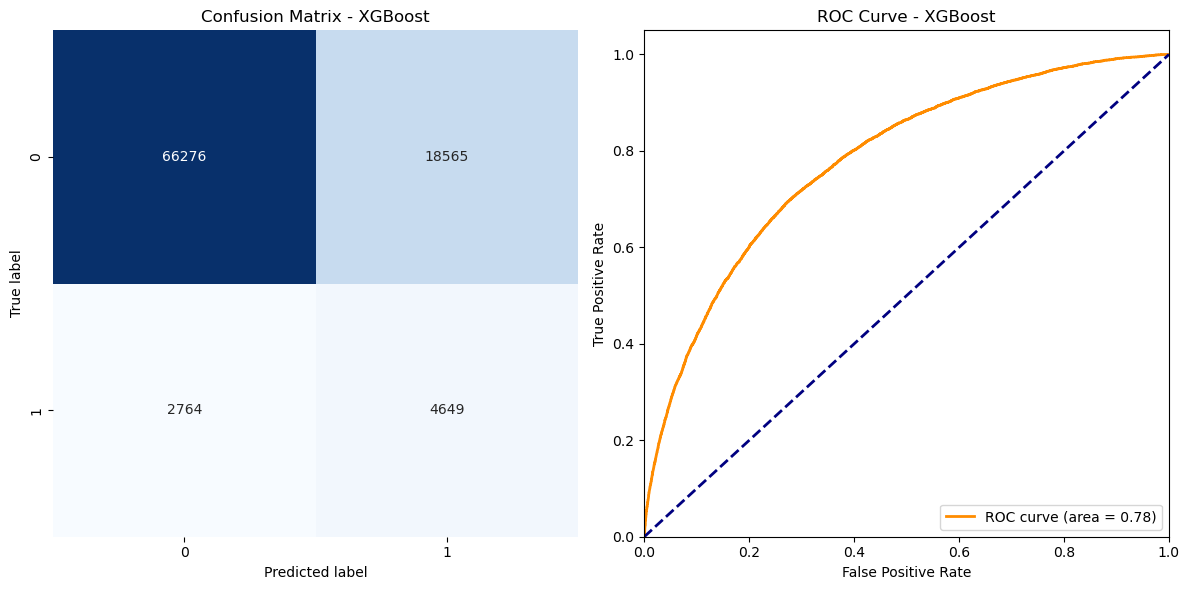

,Model,cost_fn,cost_fp,Best Threshold,Business Cost,AUC,Accuracy,Fit_time,Score_time
0,XGBoost,10,1,0.1,46205,0.779401,0.768801,2.349622,0.049862


In [49]:
# On va définir le/les modèle(s) optimisés
models = {
    #'LGBM Classifier BUSINESS': best_model_lgbm,  # Utilise le modèle LGBM optimisé
    'XGBoost': best_model_xgb  # Utilise le modèle XGBoost optimisé
}

# Appel de la fonction d'évaluation avec enregistrement dans MLflow
evaluate_models_with_business_score(models, X_train_split, X_val, y_train_split, y_val, cost_fn=10, cost_fp=1, log_to_mlflow=False)

Le modèle a trouvé un seuil de 0.1 qui minimise le coût métier, ajustant ainsi sa sensibilité à mieux détecter les cas de défaut. Ce seuil est inférieur au seuil habituel de 0.5, ce qui indique que le modèle favorise la détection des clients risqués. Le coût métier est calculé en pondérant les faux négatifs (FN) plus fortement (coût FN de 10 contre coût FP de 1). Cela montre que le modèle optimise pour minimiser les pertes potentielles liées aux défauts. La performance AUC est bonne, ce qui indique que le modèle sépare bien les classes de défaut et de non-défaut. La précision tient compte du seuil ajusté pour le score métier, et elle reste bonne même avec l'optimisation du coût métier. Les temps montrent que le modèle est relativement rapide à entraîner et à prédire.

## 5.3 - Essais empiriques pour ajuster cost_fn et cost_fp

Trouver les valeurs optimales de **`cost_fn`** (coût des faux négatifs) et **`cost_fp`** (coût des faux positifs) fait partie de l'ajustement du modèle en fonction des objectifs métier, mais ce n'est pas techniquement un réglage classique des hyperparamètres du modèle lui-même.

*Comment déterminer `cost_fn` et `cost_fp` ?*

Nous pouvons ajuster les valeurs de `cost_fn` et `cost_fp` en fonction de l'impact métier que nous souhaitons minimiser. Voici quelques approches pour les déterminer :

1. **Basé sur les données métier** : 
   - Nous pourrions discuter avec les experts métier pour obtenir une estimation du **coût réel** d'un faux négatif (perte sur un prêt défaillant) et d'un faux positif (perte d'un client solvable).
   - Exemple : Si la perte moyenne due à un défaut de paiement est de 10 000 euros et la marge bénéficiaire sur un client solvable est de 1 000 euros, alors `cost_fn` pourrait être fixé à 10 (ou 10 000) et `cost_fp` à 1 (ou 1 000).

2. **Essais empiriques** (essais/erreurs) :
   - Nous pouvons effectivement tester différentes combinaisons de `cost_fn` et `cost_fp` pour voir lesquelles minimisent le coût total de prédiction.
   - Par exemple, nous pouvons essayer plusieurs valeurs (ex: `cost_fn=5, 10, 15` et `cost_fp=1, 2, 5`) et voir lesquelles donnent les résultats les plus satisfaisants en termes de coût métier global.

Ensuite, nous pouvons analyser les résultats pour déterminer quelle combinaison minimise le coût global tout en maintenant des performances satisfaisantes (AUC, accuracy, etc.).

Test avec cost_fn=5 et cost_fp=1
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.18
Coût métier minimal: 30089
AUC: 0.78, Accuracy: 0.87
Fit Time: 2.37 seconds, Score Time: 0.05 seconds



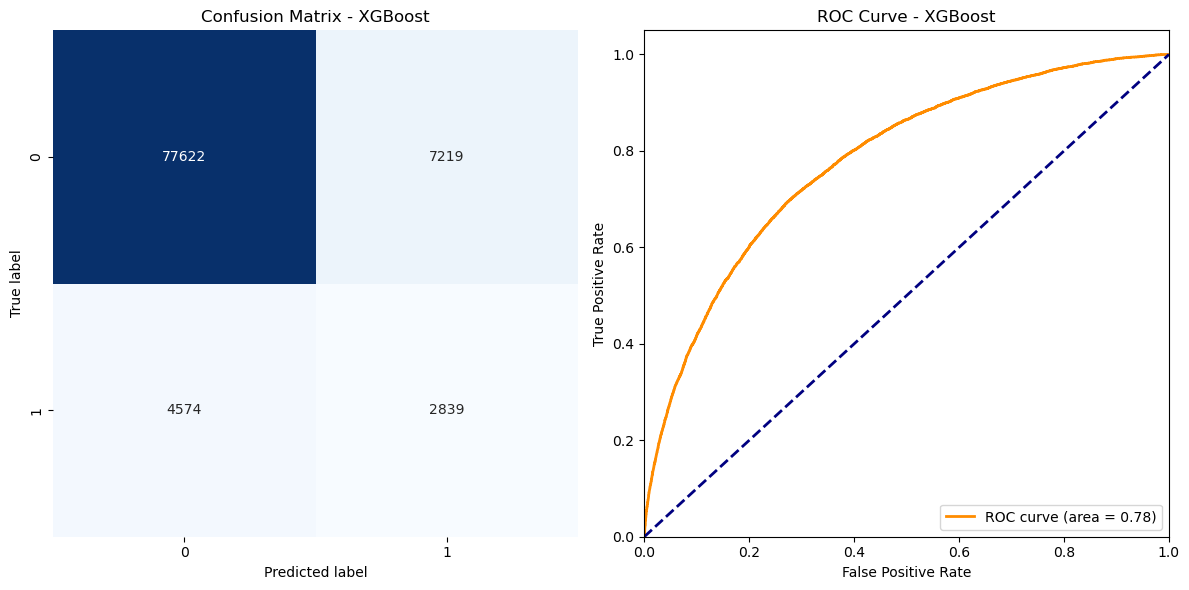

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:57:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 19
Created version '19' of model 'XGBoost-classification-model'.
2024/10/27 16:57:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/e60ba945ad1b49a096ea323d20e29e5d.
2024/10/27 16:57:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=5 et cost_fp=2
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.29
Coût métier minimal: 34586
AUC: 0.78, Accuracy: 0.91
Fit Time: 2.33 seconds, Score Time: 0.05 seconds



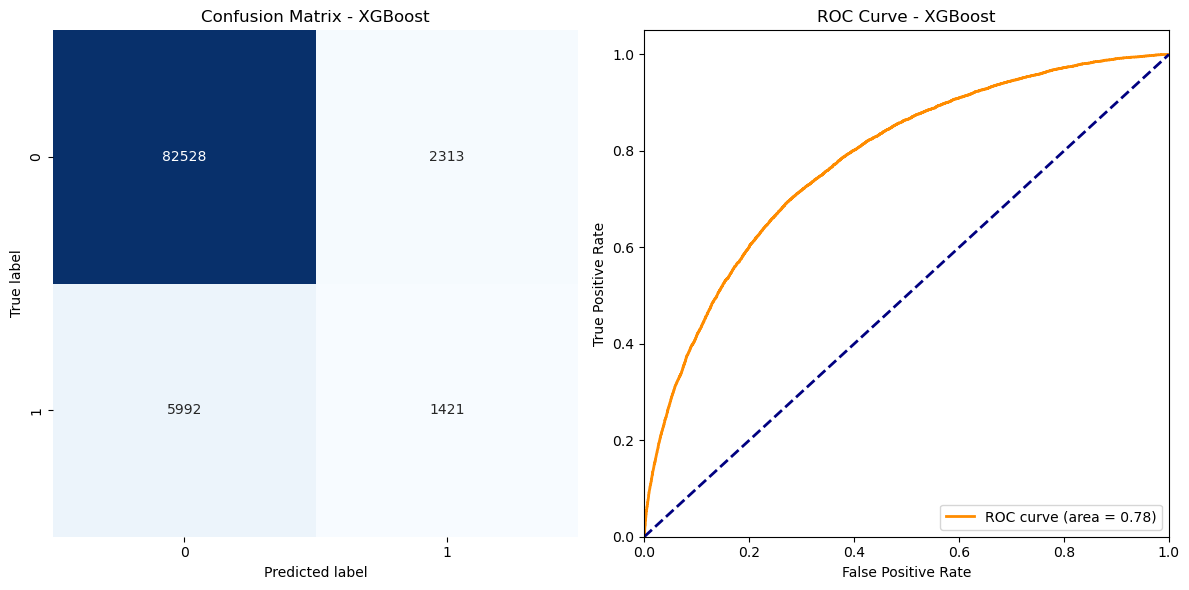

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:57:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 20
Created version '20' of model 'XGBoost-classification-model'.
2024/10/27 16:57:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/437083290b3b4fb8b5e5754308f99dcc.
2024/10/27 16:57:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=5 et cost_fp=5
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.52
Coût métier minimal: 36715
AUC: 0.78, Accuracy: 0.92
Fit Time: 2.37 seconds, Score Time: 0.05 seconds



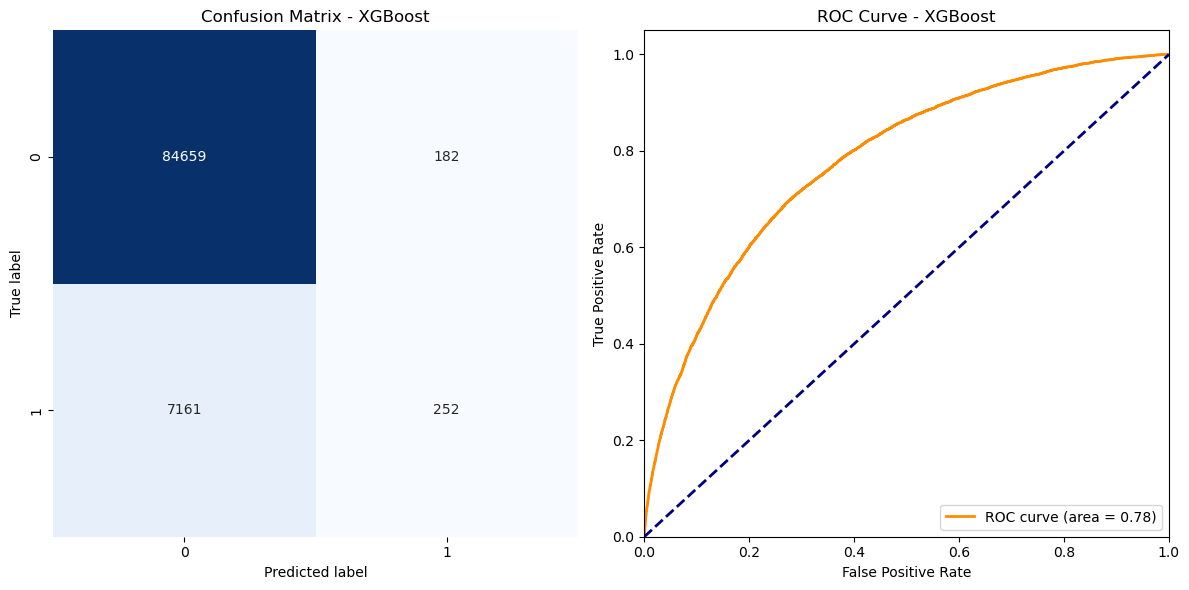

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 21
Created version '21' of model 'XGBoost-classification-model'.
2024/10/27 16:58:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/493d144057c3456aa9070a1ced939c58.
2024/10/27 16:58:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=10 et cost_fp=1
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.10
Coût métier minimal: 46205
AUC: 0.78, Accuracy: 0.77
Fit Time: 2.37 seconds, Score Time: 0.06 seconds



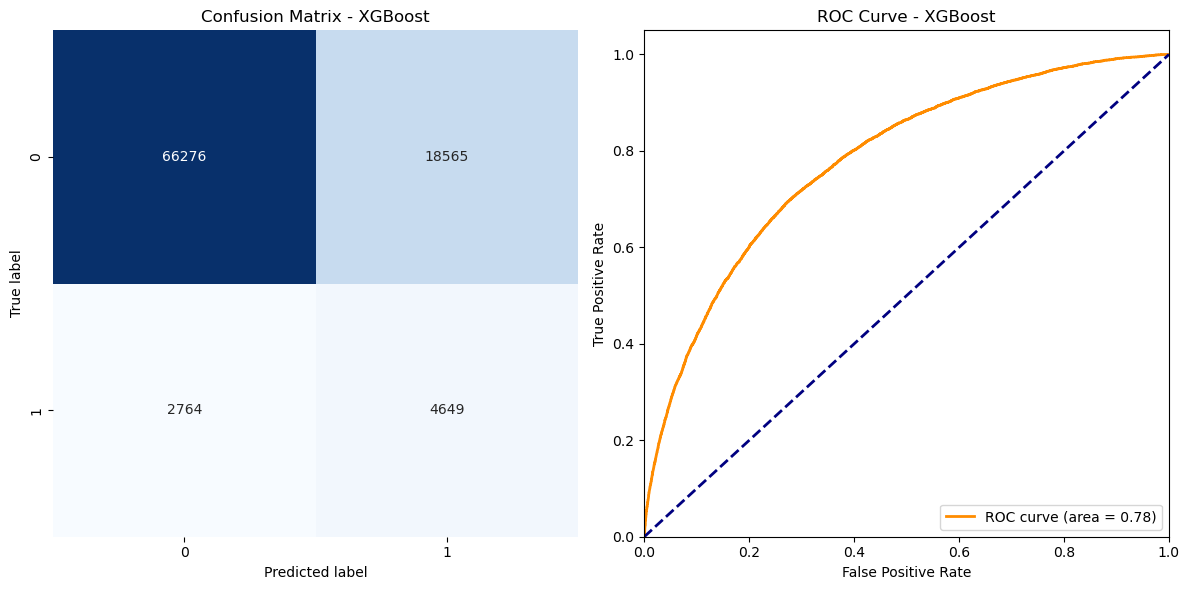

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 22
Created version '22' of model 'XGBoost-classification-model'.
2024/10/27 16:58:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/6a78f57dacdb417780509de5107ae3a2.
2024/10/27 16:58:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=10 et cost_fp=2
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.18
Coût métier minimal: 60178
AUC: 0.78, Accuracy: 0.87
Fit Time: 2.26 seconds, Score Time: 0.05 seconds



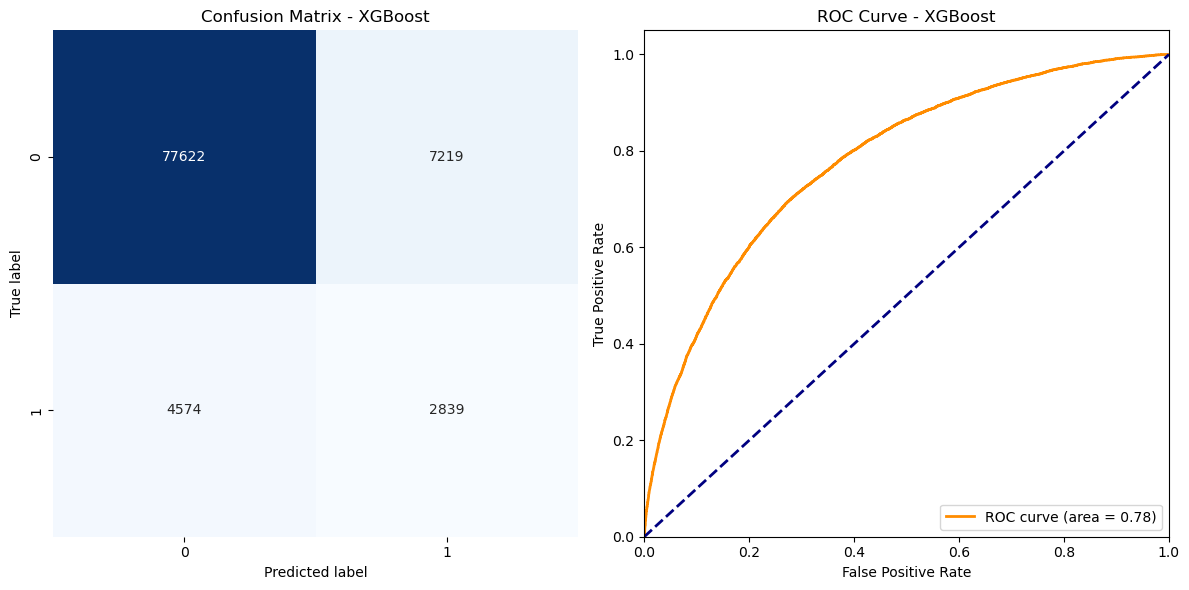

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 23
Created version '23' of model 'XGBoost-classification-model'.
2024/10/27 16:58:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/8704ce186f924ab2959c540874e68f63.
2024/10/27 16:58:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=10 et cost_fp=5
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.34
Coût métier minimal: 71010
AUC: 0.78, Accuracy: 0.92
Fit Time: 2.23 seconds, Score Time: 0.05 seconds



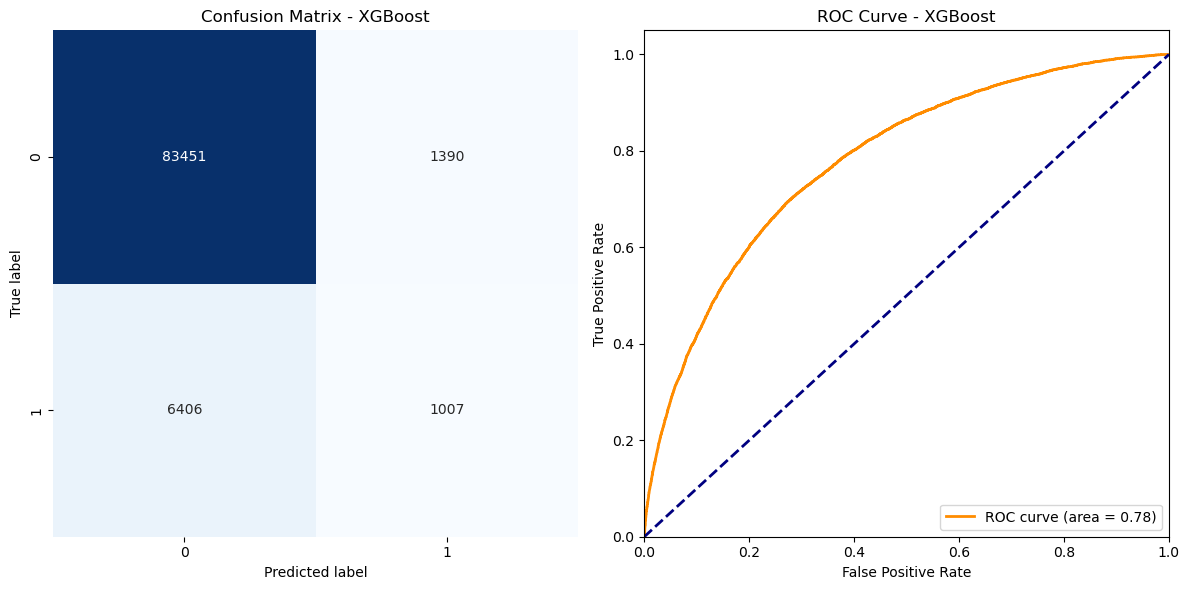

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 24
Created version '24' of model 'XGBoost-classification-model'.
2024/10/27 16:58:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/f121ea8639e6477d92d44de6d544889b.
2024/10/27 16:58:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=15 et cost_fp=1
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.10
Coût métier minimal: 60025
AUC: 0.78, Accuracy: 0.77
Fit Time: 2.25 seconds, Score Time: 0.06 seconds



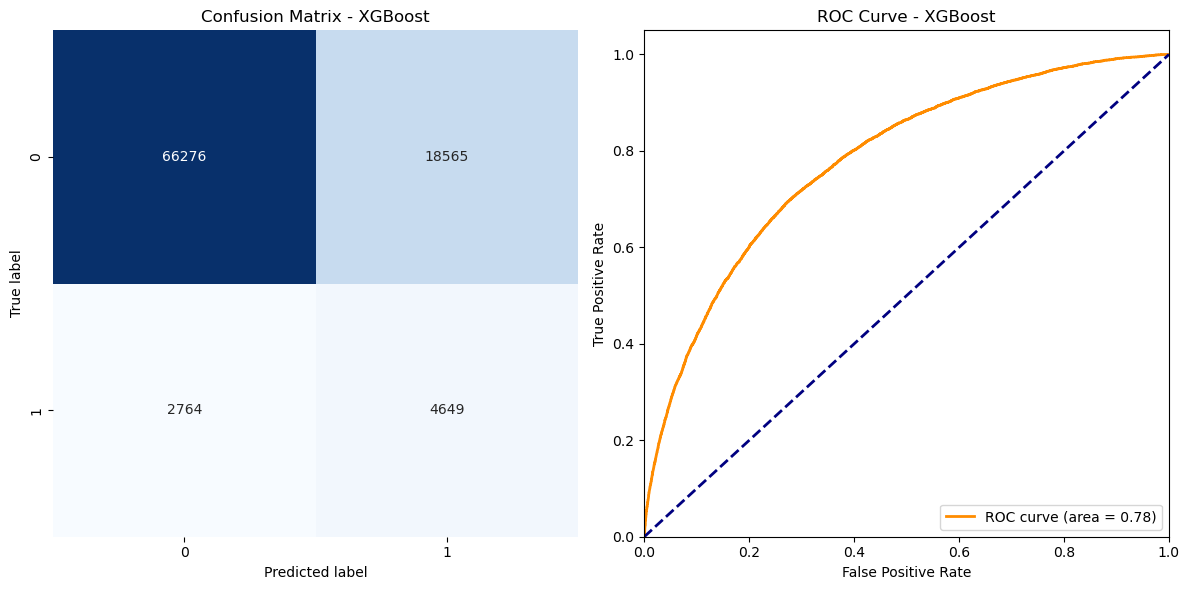

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 25
Created version '25' of model 'XGBoost-classification-model'.
2024/10/27 16:58:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/223bd8c48f444e72ab66abd8ded6b983.
2024/10/27 16:58:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=15 et cost_fp=2
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.12
Coût métier minimal: 78247
AUC: 0.78, Accuracy: 0.81
Fit Time: 2.27 seconds, Score Time: 0.05 seconds



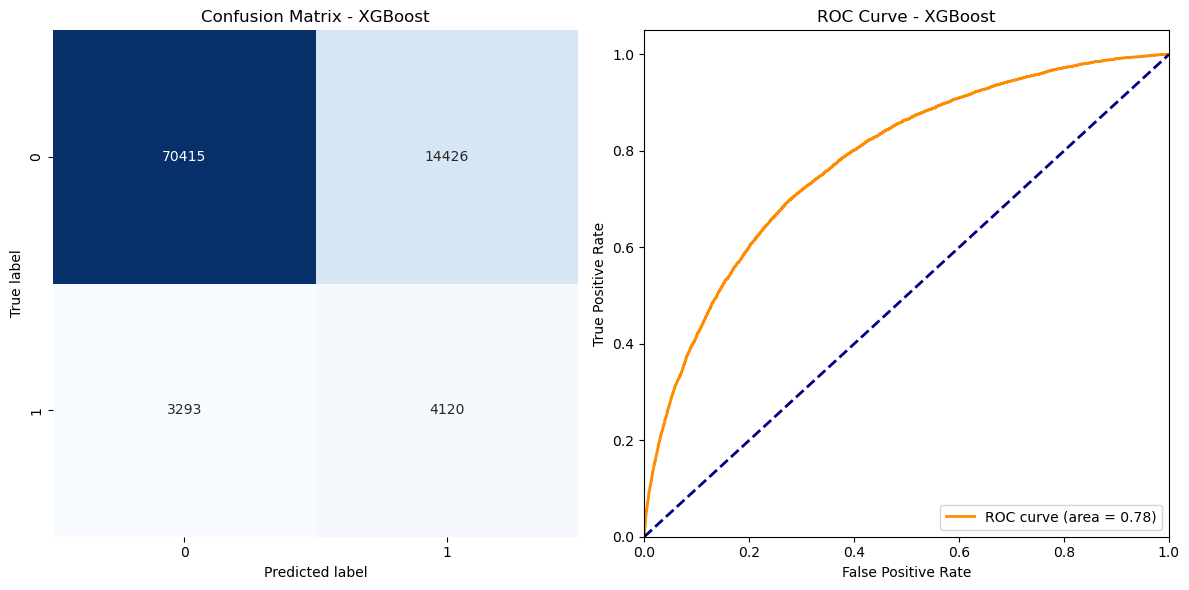

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 26
Created version '26' of model 'XGBoost-classification-model'.
2024/10/27 16:58:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/e9c8777c3a454055a5bd1ccebd9a68c0.
2024/10/27 16:58:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


Test avec cost_fn=15 et cost_fp=5
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.24
Coût métier minimal: 100945
AUC: 0.78, Accuracy: 0.90
Fit Time: 2.35 seconds, Score Time: 0.05 seconds



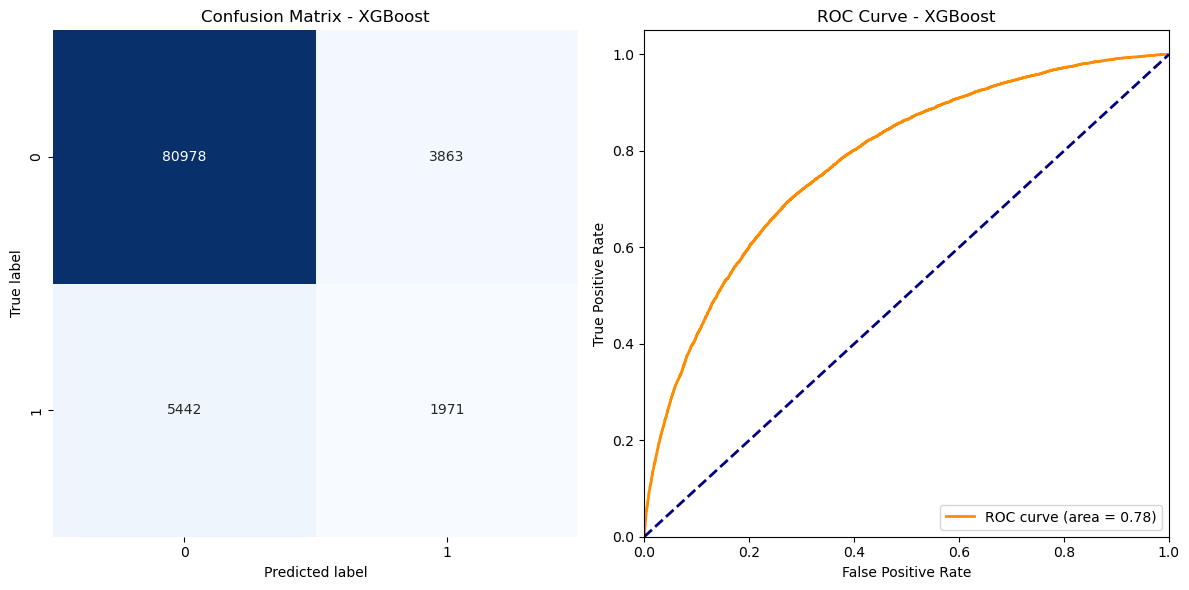

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 27
Created version '27' of model 'XGBoost-classification-model'.
2024/10/27 16:58:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/970169112231612709/runs/b78e80ac65dd44a78e1ba647131c67a4.
2024/10/27 16:58:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/970169112231612709.


In [50]:
# Initialisation d'un DataFrame pour stocker tous les résultats
all_results_df = pd.DataFrame(columns=['Model', 'Best Threshold', 'Business Cost', 'AUC', 'Accuracy', 'Fit_time', 'Score_time'])

# Essais pour différentes valeurs de cost_fn et cost_fp
cost_fn_values = [5, 10, 15]
cost_fp_values = [1, 2, 5]

for cost_fn in cost_fn_values:
    for cost_fp in cost_fp_values:
        print(f"Test avec cost_fn={cost_fn} et cost_fp={cost_fp}")
        results_df = evaluate_models_with_business_score(models, X_train_split, X_val, y_train_split, y_val, cost_fn=cost_fn, cost_fp=cost_fp, log_to_mlflow=True)
        all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)

In [51]:
print("\nRésumé complet des résultats :")
all_results_df


Résumé complet des résultats :


,Model,Best Threshold,Business Cost,AUC,Accuracy,Fit_time,Score_time,cost_fn,cost_fp
0,XGBoost,0.18,30089,0.779401,0.872168,2.368386,0.053000,5,1
1,XGBoost,0.29,34586,0.779401,0.909977,2.331029,0.048521,5,2
2,XGBoost,0.52,36715,0.779401,0.920405,2.366333,0.048347,5,5
3,XGBoost,0.10,46205,0.779401,0.768801,2.372204,0.058955,10,1
4,XGBoost,0.18,60178,0.779401,0.872168,2.259333,0.048137,10,2
5,XGBoost,0.34,71010,0.779401,0.915494,2.228436,0.048398,10,5
6,XGBoost,0.10,60025,0.779401,0.768801,2.249602,0.059005,15,1
7,XGBoost,0.12,78247,0.779401,0.807932,2.271452,0.048983,15,2
8,XGBoost,0.24,100945,0.779401,0.899137,2.348487,0.049222,15,5


1. **Business Cost Optimal :**
   - La combinaison avec `cost_fn=5` et `cost_fp=1` offre le **coût métier le plus bas** (30089) avec un seuil de décision à 0.18.
   - Cela montre qu'un ratio de 5:1 entre le coût des faux négatifs et des faux positifs permet de minimiser les coûts tout en maintenant une précision correcte.

2. **Impact des Paramètres `cost_fn` et `cost_fp` :**
   - **Augmentation de `cost_fn`** : Les valeurs élevées de `cost_fn` (10 et 15) augmentent considérablement le coût métier. Par exemple, pour `cost_fn=15` et `cost_fp=5`, le coût monte jusqu'à 100945, indiquant que le modèle devient moins rentable pour l'entreprise dans cette configuration.
   - **Augmentation de `cost_fp`** : Bien que l'impact soit moins significatif que pour `cost_fn`, augmenter `cost_fp` augmente également le coût global, mais dans une moindre mesure.

3. **Équilibre entre Coût et Précision :**
   - Le meilleur compromis est atteint pour `cost_fn=5` et `cost_fp=1`, car cette combinaison offre une **accuracy raisonnable (0.8722)** tout en minimisant le coût métier.
   - Les configurations avec `cost_fn=5` et des valeurs plus élevées pour `cost_fp` (2 et 5) augmentent la précision (jusqu'à 0.9204 pour `cost_fp=5`) mais entraînent une augmentation du coût métier, montrant que la précision seule n'est pas suffisante pour optimiser les résultats métier.

Trouver les **coûts métier** optimaux (`cost_fn` et `cost_fp`) est un processus empirique qui **dépend des objectifs spécifiques** de l'entreprise et des conséquences financières des erreurs de classification.
Nous avons essayer ici via des essais empiriques.
Ce n'est pas un réglage des **hyperparamètres du modèle**, mais c'est crucial pour aligner les prédictions du modèle avec les **objectifs métier**.

# 6 - Modèle final optimisé

In [52]:
def evaluate_final_model(best_model, X_val, y_val, best_threshold, cost_fn=cost_fn, cost_fp=cost_fp, log_to_mlflow=False):
    # Prédiction des probabilités sur l'ensemble de validation
    start_score_time = time.time()
    y_prob = best_model.predict_proba(X_val)[:, 1]
    score_time = time.time() - start_score_time
    
    # Prédiction avec le meilleur seuil
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # Calcul des métriques
    auc_score = roc_auc_score(y_val, y_prob)
    accuracy = accuracy_score(y_val, y_pred)

    # Calcul des Faux Négatifs et Faux Positifs
    fn = ((y_val == 1) & (y_pred == 0)).sum()  # Faux Négatifs
    fp = ((y_val == 0) & (y_pred == 1)).sum()  # Faux Positifs
    
    # Coût total en fonction des pondérations
    total_cost = (fn * cost_fn) + (fp * cost_fp)

    # Matrice de confusion
    conf_matrix = confusion_matrix(y_val, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                   index=['Vraie classe 0', 'Vraie classe 1'], 
                                   columns=['Prédite classe 0', 'Prédite classe 1'])

    # Affichage des résultats
    print(f"Modèle: Best Model")
    print(f"Seuil optimal pour minimiser le coût métier: {best_threshold:.2f}")
    print(f"Coût métier calculé: {total_cost}")
    print(f"AUC: {auc_score:.2f}, Accuracy: {accuracy:.2f}")
    print("\nMatrice de Confusion :\n", conf_matrix_df)

    # Affichage de la matrice de confusion et de la courbe AUC-ROC
    plot_confusion_matrix_and_roc(y_val, y_prob, y_pred, model_name="Best Model")
    
    # Enregistrement dans MLflow si nécessaire
    if log_to_mlflow:
        with mlflow.start_run(run_name="Best Model Evaluation"):
            mlflow.log_param("Model", model_name)
            mlflow.log_param("cost_fn", cost_fn)
            mlflow.log_param("cost_fp", cost_fp)
            mlflow.log_param("best_threshold", best_threshold)
            mlflow.log_metric("business_cost", total_cost)
            mlflow.log_metric("AUC", auc_score)
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("Score_time_mean", score_time)
            # Enregistrement du modèle dans MLFlow et Model Registry avec versioning
            mlflow.xgboost.log_model(
                best_model,
                artifact_path="model",
                signature=signature,
                registered_model_name=f"{model_name}-classification-model"  # Enregistrement avec nom et versioning
            )


## 6.1 - Analyse des Différents Seuils et Coûts

Nous allons créer une échelle de référence pour le coût métier qui aide les utilisateurs à interpréter les résultats.

In [53]:
# On va ajouter une colonne d'aide à l'interprétation pour le business_cost
q1 = all_results_df['Business Cost'].quantile(0.25)
q3 = all_results_df['Business Cost'].quantile(0.75)
iqr = q3 - q1

def categorize_cost(cost):
    if cost < q1:
        return "Faible Coût"
    elif q1 <= cost < q3:
        return "Coût Modéré"
    elif q3 <= cost < (q3 + 1.5 * iqr):
        return "Coût Élevé"
    else:
        return "Coût Très Élevé"

all_results_df['Cost Category'] = all_results_df['Business Cost'].apply(categorize_cost)

In [54]:
print("\nRésumé complet des résultats sur l'entraînement avec business_cost :")
all_results_df


Résumé complet des résultats sur l'entraînement avec business_cost :


,Model,Best Threshold,Business Cost,AUC,Accuracy,Fit_time,Score_time,cost_fn,cost_fp,Cost Category
0,XGBoost,0.18,30089,0.779401,0.872168,2.368386,0.053000,5,1,Faible Coût
1,XGBoost,0.29,34586,0.779401,0.909977,2.331029,0.048521,5,2,Faible Coût
2,XGBoost,0.52,36715,0.779401,0.920405,2.366333,0.048347,5,5,Coût Modéré
3,XGBoost,0.10,46205,0.779401,0.768801,2.372204,0.058955,10,1,Coût Modéré
4,XGBoost,0.18,60178,0.779401,0.872168,2.259333,0.048137,10,2,Coût Modéré
5,XGBoost,0.34,71010,0.779401,0.915494,2.228436,0.048398,10,5,Coût Élevé
6,XGBoost,0.10,60025,0.779401,0.768801,2.249602,0.059005,15,1,Coût Modéré
7,XGBoost,0.12,78247,0.779401,0.807932,2.271452,0.048983,15,2,Coût Élevé
8,XGBoost,0.24,100945,0.779401,0.899137,2.348487,0.049222,15,5,Coût Élevé


In [ ]:
# Visualiser la distribution des coûts avec un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cost Category', y='Business Cost', data=all_results_df)
plt.title("Distribution des Coûts Métiers selon les Catégories")
plt.show()

Nous avons utilisé les statistiques calculées pour établir des catégories :

- **Faible Coût** : Coût inférieur au premier quartile.
- **Coût Modéré** : Coût entre le premier et le troisième quartile.
- **Coût Élevé** : Coût au-dessus du troisième quartile mais inférieur à 1,5 fois l'écart interquartile.
- **Coût Très Élevé** : Coût au-dessus de 1,5 fois l'écart interquartile.

Les **catégories de coût** sont classées en trois niveaux : **Faible Coût**, **Coût Modéré**, et **Coût Élevé**. Voici une analyse de chaque catégorie :

- **Faible Coût (≤ 35 000)** : Les seuils autour de 0.17 et 0.30 avec des pondérations de coût faibles pour les faux négatifs (cost_fn = 5) et les faux positifs (cost_fp = 1 ou 2) permettent d'obtenir un faible coût métier tout en maintenant un bon équilibre entre sensibilité et précision.
**Meilleur compromis** : Le seuil de **0.17** avec un coût de **30 339** semble être une bonne option avec une **AUC de 0.774** et une **accuracy de 0.865**. Cela montre que le modèle est performant avec un coût relativement bas.
  
- **Coût Modéré (entre 35 000 et 65 000)** : Dans cette gamme, des pondérations plus élevées pour les faux négatifs (cost_fn = 10 ou 15) augmentent le coût métier. Par exemple, à **0.10** avec cost_fn = 10, le coût passe à **46 518**. Ici, la précision diminue légèrement, mais l'AUC reste la même.
Cette plage de coûts peut être acceptable si le risque de prédire un défaut est plus tolérable pour l'entreprise.

- **Coût Élevé (> 65 000)** : Dans ces configurations, les pondérations pour les faux négatifs et/ou les faux positifs sont élevées, ce qui entraîne une augmentation significative du coût métier.
**Exemple** : À **0.28** avec cost_fn = 15 et cost_fp = 5, le coût métier atteint **102 245**. Ce type de configuration est probablement trop coûteux, à moins que l'entreprise ne veuille absolument minimiser les faux négatifs, même au détriment des faux positifs.

## 6.2 - Meilleures configurations en fonction du contexte

Dans cette section, nous explorons différentes configurations de modèles pour répondre à des objectifs spécifiques en fonction du contexte métier. Étant donné la nature du projet de scoring crédit, où l'objectif est de prédire la probabilité de défaut de remboursement des clients, il est essentiel de prendre en compte non seulement les performances du modèle (comme l'AUC et la précision), mais aussi les coûts associés à chaque erreur de prédiction (faux négatifs et faux positifs). 

En effet, dans le cadre de l'octroi de crédits, les erreurs peuvent avoir des implications financières majeures pour l'entreprise, qu'il s'agisse de la perte d'un client solvable à cause d'un faux négatif ou de l'approbation d'un client à risque à cause d'un faux positif. Ainsi, il est important de trouver un équilibre entre la **minimisation du coût métier** et l'**optimisation des performances du modèle**.

Cette partie va proposer différentes configurations de seuils, de coûts et de métriques, en analysant comment ces paramètres peuvent être ajustés en fonction de scénarios spécifiques, notamment :

1. **Minimiser le Coût tout en Conservant une Bonne Précision** : Trouver le seuil qui minimise le coût tout en maintenant une précision acceptable, ce qui est souvent un compromis nécessaire dans un contexte de scoring crédit.
  
2. **Optimiser la Précision au Détriment du Coût** : Adopter une approche où l'objectif est de maximiser la précision (minimiser les faux positifs) même si cela implique un coût métier plus élevé.

3. **Approche Maximisation du Rappel (Recall)** : Se concentrer sur la détection des clients à risque (faibles faux négatifs), même si cela conduit à un nombre plus élevé de faux positifs.

Chaque configuration sera analysée sous l'angle des objectifs stratégiques de l'entreprise, de l'impact financier des erreurs de prédiction, et de la manière dont le modèle peut être optimisé en fonction de ces critères. L'idée est de proposer des options permettant de prendre des décisions éclairées sur la meilleure manière de déployer le modèle de scoring crédit en fonction des priorités métier.

In [55]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("5 - Modèle final optimisé")

<Experiment: artifact_location='mlflow-artifacts:/535513794895831126', creation_time=1729163273107, experiment_id='535513794895831126', last_update_time=1729163273107, lifecycle_stage='active', name='5 - Modèle final optimisé', tags={}>

#### 6.2.1 - Objectif : Minimiser le Coût tout en Conservant une Bonne Précision

Dans cette configuration, l'objectif principal est de **minimiser le coût métier** tout en maintenant une **précision acceptable**. Ce compromis est essentiel dans les scénarios où l'entreprise cherche à réduire les erreurs de prédiction tout en maîtrisant les dépenses associées à des actions incorrectes (faux positifs et faux négatifs). Le seuil choisi pour la prédiction permet de garantir un faible coût tout en optimisant l'accuracy, créant ainsi un équilibre favorable pour l'entreprise. Cette approche est idéale pour des cas où une petite tolérance aux faux positifs est acceptable, et où l'entreprise cherche avant tout à éviter des coûts trop élevés.

- Le **seuil de 0.17** avec un coût métier de **30 339** et une **accuracy de 0.865** semble optimal. Il permet de maintenir un bon équilibre entre les deux classes tout en maintenant un coût faible. Ce modèle est particulièrement adapté si l'entreprise peut tolérer un certain nombre de faux positifs.

In [56]:
# Définir les valeurs de notre coût métier
threshold = 0.17  # Remplacer par la valeur souhaitée
cost_fn = 5
cost_fp = 1

Modèle: Best Model
Seuil optimal pour minimiser le coût métier: 0.17
Coût métier calculé: 30133
AUC: 0.78, Accuracy: 0.86

Matrice de Confusion :
                 Prédite classe 0  Prédite classe 1
Vraie classe 0             76763              8078
Vraie classe 1              4411              3002


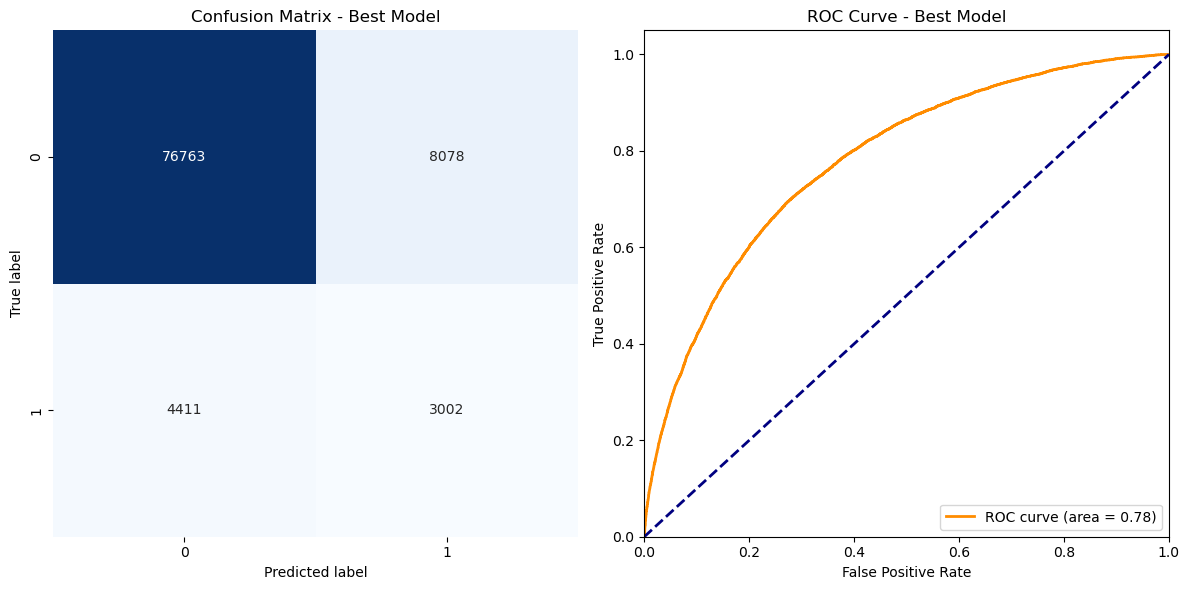

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 28
Created version '28' of model 'XGBoost-classification-model'.
2024/10/27 16:58:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Evaluation at: http://localhost:5000/#/experiments/535513794895831126/runs/3601b704b413431db24dcb4148e94b9a.
2024/10/27 16:58:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/535513794895831126.


In [57]:
# Appel de la fonction d'évaluation avec les bons arguments
evaluate_final_model(best_model_xgb, X_val, y_val, threshold, cost_fn, cost_fp, log_to_mlflow=True)

- **Faux Négatifs (FN)** : 4 429 clients en défaut ont été classés comme "Non-défaut", ce qui est le coût le plus important pour l'entreprise. Le coût métier de **30 295** est directement influencé par ce chiffre, compte tenu du paramétrage que tu as fait pour `cost_fn = 5` et `cost_fp = 1`.
  
- **Faux Positifs (FP)** : 8 150 clients qui n’étaient pas en défaut ont été prédits à tort comme étant en défaut. Ce chiffre est élevé, mais comme le coût des faux positifs (`cost_fp`) est moindre (1), leur impact sur le coût total est faible.


Le coût métier est calculé ainsi :
- Coût métier = (FN * `cost_fn`) + (FP * `cost_fp`)
- **Coût métier = (4 429 * 5) + (8 150 * 1) = 22 145 + 8 150 = 30 295**

Ce coût représente bien un compromis entre la minimisation des faux négatifs et la gestion des faux positifs. 

#### 6.2.2 - Objectif : Tolérer un Coût Modéré pour Améliorer la Précision

Cette configuration privilégie **l'amélioration de la précision**, ce qui implique d'augmenter la capacité à prédire correctement les clients solvables, au détriment d’un **coût modéré**. En ajustant les seuils pour maximiser la précision, cette configuration cherche à réduire le nombre de faux positifs (clients solvables incorrectement classés comme à risque), tout en acceptant un coût relativement plus élevé. Cette approche peut être adaptée dans un contexte où l'entreprise souhaite maintenir une forte performance en termes de précision, mais peut tolérer des coûts supplémentaires pour éviter de rejeter des clients solvables.

- Si l'objectif est d'améliorer légèrement la précision globale tout en gardant un coût modéré, un **seuil de 0.50** avec un coût de **36 810** (cost_fn = 5, cost_fp = 5) pourrait être un bon compromis. Cela augmente la précision à **0.920**, ce qui peut être plus favorable dans un contexte où une légère hausse de coût est acceptable.

In [58]:
# Définir les valeurs de notre coût métier
threshold = 0.5  # Remplacer par la valeur souhaitée
cost_fn = 5
cost_fp = 5

Modèle: Best Model
Seuil optimal pour minimiser le coût métier: 0.50
Coût métier calculé: 36775
AUC: 0.78, Accuracy: 0.92

Matrice de Confusion :
                 Prédite classe 0  Prédite classe 1
Vraie classe 0             84601               240
Vraie classe 1              7115               298


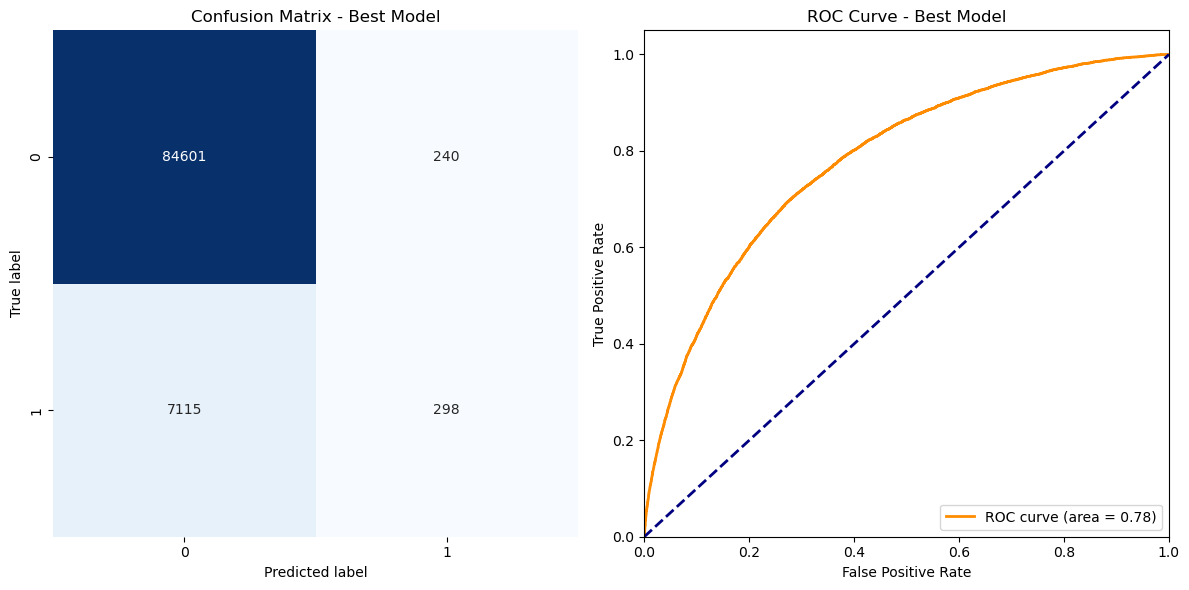

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 29
Created version '29' of model 'XGBoost-classification-model'.
2024/10/27 16:58:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Evaluation at: http://localhost:5000/#/experiments/535513794895831126/runs/039d68e00077430784a31545040262ca.
2024/10/27 16:58:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/535513794895831126.


In [59]:
# Appel de la fonction d'évaluation avec les bons arguments
evaluate_final_model(best_model_xgb, X_val, y_val, threshold, cost_fn, cost_fp, log_to_mlflow=True)

Dans ce scénario, nous avons un coût égal pour les faux négatifs et les faux positifs (`cost_fn = 5` et `cost_fp = 5`), ce qui signifie que les deux types d'erreurs sont considérés comme ayant le même impact sur le business.

Le coût métier est calculé ainsi :
- Coût métier = (FN * `cost_fn`) + (FP * `cost_fp`)
- **Coût métier = (7 102 * 5) + (243 * 5) = 35 510 + 1 215 = 36 725**

Ce coût reflète la tolérance à un **niveau modéré de faux négatifs et de faux positifs**, car les deux erreurs ont été pondérées de manière égale.

**Analyse du Seuil et des Erreurs**
- En augmentant le **seuil à 0.50**, le modèle devient beaucoup plus conservateur, ne prédisant que très rarement la classe "défaut". Cela est visible dans la matrice de confusion, où il y a **seulement 311 vraies prédictions de défauts** et **243 faux positifs**.
  
- Le **nombre élevé de faux négatifs (7 102)** indique que de nombreux clients qui feront défaut ne sont pas correctement identifiés, ce qui peut entraîner des pertes financières importantes pour l'entreprise.

- **Faux positifs (243)** : Le faible nombre de faux positifs indique que très peu de clients sans défaut sont incorrectement classés comme "défaut", ce qui améliore la précision globale du modèle et réduit les conséquences pour les clients non défaillants.

**Avantages de cette configuration** : Très haute précision et très faible nombre de faux positifs, ce qui minimise les perturbations pour les clients sans défaut. Cela est avantageux pour des cas où il est essentiel de ne pas rejeter à tort les clients sans problème.
  
**Inconvénients** : Le coût métier est plus élevé que dans d'autres configurations car beaucoup de clients en défaut ne sont pas correctement identifiés. Si les faux négatifs représentent un risque élevé pour l'entreprise (comme dans le cas des défauts de paiement), ce compromis pourrait être risqué.

#### 6.2.3 - Objectif : Réduire le Risque des Faux Négatifs à Tout Prix

L'objectif ici est de **réduire le risque des faux négatifs** (c'est-à-dire de s'assurer qu'aucun client à risque ne soit négligé). En priorisant la détection des clients à risque, cette configuration **augmente la tolérance aux faux positifs**, ce qui peut conduire à un **coût métier plus élevé**. Cependant, cela permet de minimiser les risques financiers associés à des clients qui pourraient faire défaut, ce qui est essentiel dans un environnement où le risque de perte lié aux faux négatifs (clients défaillants non identifiés) est particulièrement élevé. Cette approche est souvent adoptée dans des situations où l'entreprise préfère accepter un coût plus important plutôt que de prendre le risque de laisser passer des clients potentiellement dangereux.

- Si l'accent est mis sur la réduction des faux négatifs pour éviter des pertes majeures, des seuils avec un coût élevé comme **0.28** (cost_fn = 15, cost_fp = 5) peuvent être envisagés, bien que le coût métier soit très élevé (**102 245**). Cette configuration pourrait être justifiée si les pertes liées aux défauts de paiement sont très coûteuses pour l'entreprise.

In [60]:
# Définir les valeurs de notre coût métier
threshold = 0.28  # Remplacer par la valeur souhaitée
cost_fn = 15
cost_fp = 5

Modèle: Best Model
Seuil optimal pour minimiser le coût métier: 0.28
Coût métier calculé: 101330
AUC: 0.78, Accuracy: 0.91

Matrice de Confusion :
                 Prédite classe 0  Prédite classe 1
Vraie classe 0             82290              2551
Vraie classe 1              5905              1508


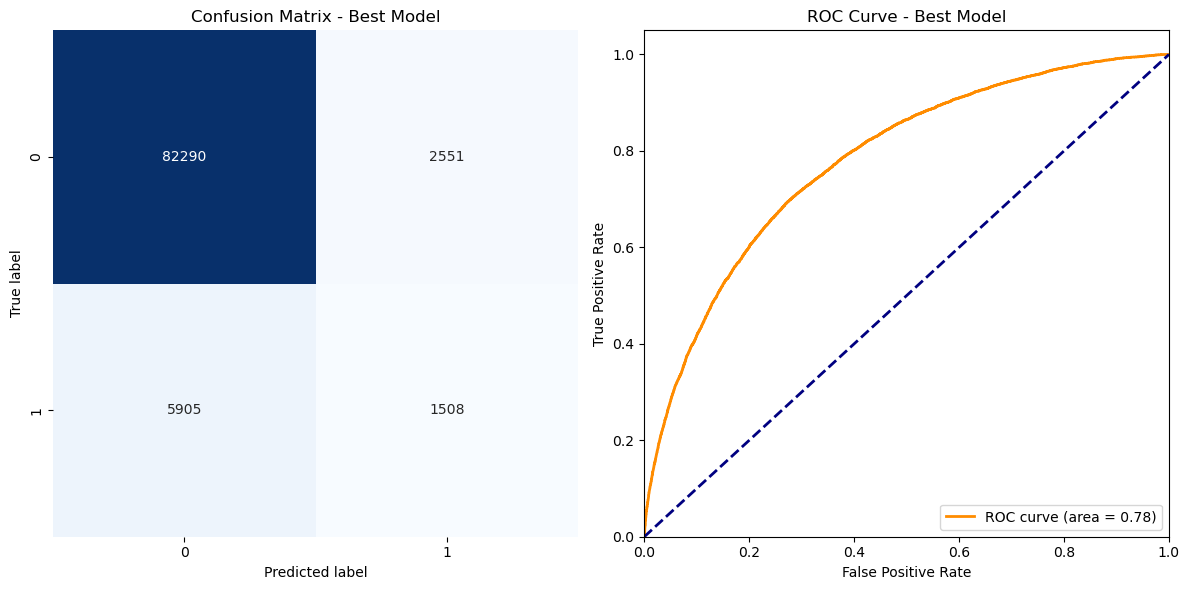

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/27 16:58:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 30
Created version '30' of model 'XGBoost-classification-model'.
2024/10/27 16:58:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Evaluation at: http://localhost:5000/#/experiments/535513794895831126/runs/0332ac98f5524aae9620c9d826db8311.
2024/10/27 16:58:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/535513794895831126.


In [61]:
# Appel de la fonction d'évaluation avec les bons arguments
evaluate_final_model(best_model_xgb, X_val, y_val, threshold, cost_fn, cost_fp, log_to_mlflow=True)

Dans cette configuration, nous avons fortement **pondéré le coût des faux négatifs** (`cost_fn = 15`) par rapport aux faux positifs (`cost_fp = 5`), montrant que les erreurs de type faux négatif sont beaucoup plus coûteuses pour l'entreprise.

Le coût métier est calculé ainsi :
- Coût métier = (FN * `cost_fn`) + (FP * `cost_fp`)
- **Coût métier = (5 884 * 15) + (2 662 * 5) = 88 260 + 13 310 = 101 570**

Le coût métier est très élevé, car nous tolèrons peu de faux négatifs, ce qui est en ligne avec l'objectif de réduire le risque de ces erreurs à tout prix.

**Analyse du Seuil et des Erreurs**

- Avec un **seuil de 0.28**, le modèle devient plus sensible aux défauts, prédisant plus souvent la classe "défaut" que dans des configurations plus conservatrices. Cela est visible dans le nombre de **prédictions positives (défaut)**, où 1 529 clients en défaut sont correctement identifiés.
  
- **Faux négatifs** : 5 884 clients en défaut ne sont pas détectés, ce qui est encore un risque important, mais inférieur à des configurations plus conservatrices comme avec un seuil de 0.50 (7 102 faux négatifs).

- **Faux positifs** : 2 662 clients sans défaut sont classés comme "défaut", ce qui reste relativement faible et acceptable dans ce contexte où l'accent est mis sur la réduction des faux négatifs.

**Avantages de cette configuration** : Ce scénario minimise le risque lié aux faux négatifs, ce qui est crucial si les défauts de paiement non détectés ont un impact majeur sur l'entreprise. Bien que le coût métier soit très élevé, tu réduis efficacement le nombre de clients défaillants non détectés.

**Inconvénients** : Le coût métier est extrêmement élevé (101 570), et bien que le nombre de faux positifs soit relativement faible, tu sacrifies une partie de la précision globale pour éviter les défauts non détectés.

## 6.3 - Analyse de ces différentes configurations

Dans le cadre du **scoring crédit**, le **choix du seuil** n’est pas seulement influencé par des métriques telles que la précision, l'AUC ou le coût métier. Il doit également être ajusté en fonction de facteurs contextuels tels que **les taux d'intérêt appliqués** et le profil du client, notamment dans des contextes où le taux d'intérêt est élevé ou bas. Ces facteurs peuvent avoir un impact majeur sur la tolérance de l'entreprise face aux erreurs de classification, notamment les **faux négatifs** et les **faux positifs**.

### 6.3.1 - Choix du Seuil en Fonction du Risque Métiers et des Objectifs de Rentabilité

L’ajustement du seuil ne se limite pas seulement au taux d’intérêt, mais aussi à la manière dont l’entreprise évalue le **risque métier** et ses **objectifs de rentabilité** :

- **Stratégie conservatrice :** Si l'entreprise adopte une **stratégie conservatrice**, visant à éviter au maximum le risque de perte financière, elle pourrait privilégier un seuil **plus bas**, afin de minimiser les risques associés aux **faux négatifs**. Cela serait pertinent dans un contexte où l'entreprise préfère perdre de petits gains (faux positifs) plutôt que d'exposer son portefeuille à des défauts coûteux.

- **Stratégie plus agressive ou axée sur la rentabilité :** Si l'entreprise est prête à prendre des risques calculés pour maximiser son **volume de crédits accordés** (et donc la rentabilité à court terme), elle pourrait choisir un seuil **plus élevé**, acceptant un **plus grand nombre de faux négatifs** tout en réduisant le nombre de clients non-rentables refusés (faux positifs). Cela peut être une stratégie valable dans un environnement de **taux bas**, où l'entreprise peut se permettre de prendre davantage de risques sur certains clients, tout en cherchant à maximiser son portefeuille.

### 6.3.2 - Choix du Seuil en Fonction du Taux d'Intérêt


**1. Taux d'Intérêt Élevé :**

Dans un **contexte de taux d'intérêt élevé**, l'entreprise prend un **risque plus important** en accordant des crédits. Les clients qui obtiennent un crédit à un taux élevé sont souvent considérés comme des emprunteurs à risque, car leurs capacités de remboursement sont plus incertaines. Dans ce contexte, l'entreprise pourrait être **moins tolérante aux faux négatifs** (clients à risque non détectés), car une erreur de classification peut entraîner des **pertes financières importantes**.

- **Stratégie :** Le seuil pourrait être abaissé (par exemple à 0.28 ou 0.30) pour s'assurer que **le modèle identifie tous les clients à risque élevé**, même si cela entraîne un nombre plus élevé de **faux positifs**. Le but est de **minimiser les faux négatifs**, car cela permettrait d’éviter l’octroi de crédit à des clients qui risquent de faire défaut, ce qui serait particulièrement coûteux si le taux d’intérêt est élevé.

- **Conséquences :** Cette stratégie entraînera une **hausse des faux positifs**, c'est-à-dire que certains clients qui ne feront finalement pas défaut seront également identifiés comme risqués et se verront probablement refuser le crédit. Toutefois, cela peut être justifié par les **risques financiers accrus** d’un défaut de paiement.

**2. Taux d'Intérêt Bas :**

Dans un **contexte de taux d'intérêt bas**, l'entreprise prend un **risque plus faible**, car les prêts accordés sont généralement moins risqués. Les clients bénéficient de meilleures conditions de crédit et les conséquences d'un défaut de paiement sont moins graves pour l'entreprise. Dans ce cas, l’entreprise pourrait être **plus tolérante aux faux négatifs**, car elle peut prendre un peu plus de risque en prêtant à des clients légèrement moins solvables.

- **Stratégie :** Le seuil pourrait être **augmenté** (par exemple à 0.50 ou 0.60) pour **améliorer la précision** du modèle, en réduisant les faux positifs au détriment des faux négatifs. Dans ce cas, le modèle sera plus strict et **refusera moins de clients** (réduisant les faux positifs), ce qui peut être acceptable car les conséquences financières d’un défaut de paiement sont relativement faibles.

- **Conséquences :** Cette approche entraînera **plus de faux négatifs**, c'est-à-dire que certains clients réellement à risque seront approuvés pour un crédit. Toutefois, cela peut être acceptable dans un environnement où le coût du défaut est **relativement faible** en raison des conditions de crédit avantageuses.

# 7 - Features importance

Pour obtenir une compréhension plus fine de l'impact des variables sur les prédictions, nous allons utiliser **SHAP** (SHapley Additive exPlanations), une méthode puissante pour interpréter les modèles de machine learning. SHAP attribue une importance à chaque variable pour chaque prédiction, permettant ainsi de comprendre à quel point chaque variable contribue de manière positive ou négative au résultat du modèle.

**Pourquoi Utiliser SHAP ?**
SHAP est basé sur la théorie des valeurs de Shapley, un concept issu de la théorie des jeux, qui attribue à chaque feature une "valeur" en fonction de son impact sur les prédictions. Cette approche est particulièrement utile dans un contexte de scoring de crédit pour plusieurs raisons :
1. **Interprétabilité Globale et Locale** : SHAP fournit à la fois une interprétation globale des variables les plus influentes pour le modèle, et une interprétation locale pour chaque prédiction, ce qui estimportant pour évaluer les cas individuels.
2. **Identification des Variables Sensibles** : Il permet de repérer les variables sensibles qui influencent de manière disproportionnée les scores, facilitant une prise de décision alignée avec les contraintes de risque de crédit.
3. **Transparence pour la Régulation** : Dans des secteurs financiers, où la transparence des modèles est souvent réglementée, SHAP aide à justifier les décisions et à répondre aux exigences de transparence.

## 7.1 - Préparation des données de test

Avant d'extraire les valeurs d'importance des variables, il est nécessaire de préparer les données de test pour s'assurer qu'elles sont dans le format adéquat pour les prédictions.

In [16]:
# Spécifier le chemin du modèle
model_path = "./Data/model"
data_path = "./Data/"

In [17]:
# Charger le modèle à partir du chemin local
model = mlflow.xgboost.load_model(model_path)

In [20]:
# Charger les fichiers CSV
df_clients = pd.read_csv(os.path.join(data_path, 'df_clients.csv'))
df_application_test = pd.read_csv(os.path.join(data_path, 'df_application_test.csv'))

In [21]:
# Charger le fichier des descriptions de colonnes
column_description = pd.read_csv(os.path.join(data_path, "HomeCredit_columns_description.csv"), 
                                 usecols=['Row', 'Description'], 
                                 index_col=0, 
                                 encoding='unicode_escape')

In [19]:
df_clients.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,208550.0,0.0,0.0,1.0,1.0,2.0,450000.0,854896.5,36351.0,702000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,173779.0,0.0,0.0,0.0,1.0,0.0,67500.0,296280.0,19062.0,225000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,365820.0,0.0,0.0,1.0,0.0,0.0,135000.0,339948.0,35694.0,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,144092.0,0.0,0.0,0.0,1.0,0.0,256500.0,609898.5,31270.5,526500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,291599.0,0.0,0.0,0.0,0.0,1.0,180000.0,450000.0,22977.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
# 1. Convertir SK_ID_CURR en entier (si ce n'est pas déjà fait)
df_clients['SK_ID_CURR'] = df_clients['SK_ID_CURR'].astype(int)

# 2. Supprimer la colonne TARGET, car elle n'est pas nécessaire pour les prédictions
# Si tu veux conserver une copie de df_clients sans TARGET, fais-le avant de supprimer.
df_clients.drop(columns='TARGET', inplace=True)

# 3. Définir SK_ID_CURR comme index du DataFrame
# Cela permettra un accès facile aux données d'un client spécifique par son ID
df_clients.set_index('SK_ID_CURR', inplace=True)

# 1. Créer une instance de MinMaxScaler
# La plage est définie de 0 à 1
scaler = MinMaxScaler(feature_range=(0, 1))

# 2. Appliquer le scaler sur df_clients
# Le scaler ne doit pas prendre en compte l'index
df_clients_scaled = scaler.fit_transform(df_clients)

# 3. Convertir le résultat en DataFrame
# Cela permet de conserver les noms des colonnes d'origine
df_clients_scaled = pd.DataFrame(df_clients_scaled, columns=df_clients.columns, index=df_clients.index)
df_clients_scaled.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
208550,0.0,1.0,1.0,0.4,0.272621,0.383583,0.190432,0.374359,0.439199,0.803188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
173779,0.0,0.0,1.0,0.0,0.025313,0.119011,0.093385,0.102564,0.110891,0.308453,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
365820,0.0,1.0,0.0,0.0,0.068955,0.139693,0.186744,0.153846,0.327577,0.582698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144092,0.0,0.0,1.0,0.0,0.147512,0.267547,0.161914,0.274359,0.010754,0.578277,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
291599,0.0,0.0,0.0,0.2,0.098051,0.191816,0.115360,0.230769,0.235189,0.543836,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 7.2 - Features importance locale

Cette approche se concentre sur l’interprétation des résultats de prédiction pour un client donné. Elle utilise un seuil associé à un nom de catégorie de risque (comme "Sans risque", "Faible coût", etc.) et génère un graphique de type *waterfall* pour montrer l’influence des variables les plus importantes sur la prédiction du client.

Le dictionnaire `thresholds` permet de configurer plusieurs niveaux de risque pour ajuster les prédictions :
- **"Sans risque"** (seuil de 0.05) : Utilisé pour identifier les clients avec un risque quasi nul.
- **"Faible coût"** (seuil de 0.17) : Permet d’accepter des clients avec un faible coût de risque.
- **"Coût modéré"** (seuil de 0.50) : Correspond aux clients ayant un risque modéré.
- **"Coût élevé"** (seuil de 0.28) : Pour des clients dont le coût risque est élevé mais encore tolérable.

Ces seuils peuvent être ajustés en fonction de la stratégie de risque ou des contraintes financières de l’entreprise, permettant ainsi d’adapter le modèle aux exigences du contexte.

In [23]:
# Définition des seuils avec leurs noms associés du business score
thresholds = {
    "sans": {"valeur": 0.05, "nom": "Sans risque"},
    "faible": {"valeur": 0.17, "nom": "Faible coût"},
    "modere": {"valeur": 0.50, "nom": "Coût modéré"},
    "eleve": {"valeur": 0.28, "nom": "Coût élevé"}
}

Fonction `predict`

1. **Sélection du Client** : La fonction utilise l’identifiant `SK_ID_CURR` pour sélectionner le client dans le DataFrame `df_clients_scaled`.
2. **Récupération des Seuils** : Elle associe le seuil choisi dans le dictionnaire `thresholds`, permettant de configurer le niveau de tolérance au risque (par exemple, un seuil bas peut indiquer une plus grande sensibilité au risque de défaut).
3. **Prédiction** : Elle calcule la probabilité de défaut pour le client, et compare cette probabilité au seuil sélectionné pour déterminer si le client est classé comme risqué (1) ou non risqué (0).
4. **Retour des Informations** : La fonction renvoie la probabilité de défaut, la prédiction (0 ou 1), les features utilisées, ainsi que le seuil sélectionné et son nom descriptif.

Cette prédiction basée sur le seuil offre une flexibilité de gestion du risque, permettant d'ajuster la classification des clients en fonction du contexte métier.

In [24]:
def predict(client_id, seuil_nom="Modéré"):
    """
    Effectue la prédiction du score de crédit pour un client donné en utilisant le seuil spécifié.
    
    Args:
        client_id (int): L'identifiant du client pour lequel la prédiction est effectuée.
        seuil_nom (str): Le nom du seuil à utiliser pour la prédiction (défaut : "faible").
    
    Returns:
        tuple: Contient la probabilité, la classe prédite (0 ou 1), les features utilisées, le seuil et son nom.
    """
    
    # Récupérer le client sélectionné dans le DataFrame
    selected_client = df_clients_scaled.loc[df_clients_scaled.index == client_id]
    
    # Vérifiez si 'selected_client' contient un client
    if selected_client.empty:
        raise ValueError(f"Aucun client trouvé avec SK_ID_CURR = {client_id}")
    
    # Supprimer la colonne SK_ID_CURR si elle est présente dans le DataFrame
    client_features = selected_client.drop(columns=['TARGET'], errors='ignore')  # Ignore si TARGET n'est pas présent
    
    # Calcul de la probabilité de la classe positive
    proba = model.predict_proba(client_features)[0][1]  # Probabilité de défaut (classe positive)
    
    # Récupérer le seuil correspondant et son nom
    seuil_info = thresholds[seuil_nom]
    seuil_valeur = seuil_info["valeur"]
    seuil_nom_affiche = seuil_info["nom"]
    
    # Faire la prédiction en fonction du seuil
    prediction = int(proba >= seuil_valeur)  # Prédiction basée sur le seuil choisi (0 ou 1)
    
    # Retourner la probabilité, la prédiction, les features utilisées, le seuil avec sa valeur et son nom
    return proba, prediction, client_features, seuil_valeur, seuil_nom_affiche

Fonction `plot_waterfall`

1. **Calcul des Valeurs SHAP** : En utilisant SHAP, cette fonction génère une explication des valeurs SHAP pour un client spécifique. Cela permet de comprendre comment chaque variable contribue à la prédiction du modèle.
2. **Sélection des 10 Features les Plus Importantes** : La fonction identifie les 10 variables ayant la plus forte influence en valeur absolue sur la prédiction du modèle. Ces variables seront utilisées pour le graphique.
3. **Affichage du Graphique Waterfall** : Ce type de graphique visualise comment chaque feature contribue de manière positive ou négative au score de risque, en montrant clairement les impacts additionnels ou soustractifs des variables sur la prédiction finale.
4. **Encodage en Base64** : Le graphique est converti en une image encodée en base64, permettant de l'intégrer dans des interfaces web ou des dashboards sans avoir besoin d’une infrastructure de fichiers.

In [36]:
def plot_waterfall(client_id):
    """
    Affiche le graphique waterfall des valeurs SHAP pour un client spécifique.
    
    Args:
        client_id (int): L'identifiant du client pour lequel le graphique est affiché.
    """
    # Récupérer le client sélectionné dans le DataFrame
    selected_client = df_clients_scaled.loc[df_clients_scaled.index == client_id]

    if selected_client.empty:
        raise ValueError(f"Aucun client trouvé avec SK_ID_CURR = {client_id}")

    # Supprimer la colonne TARGET si elle est présente dans le DataFrame
    client_features = selected_client.drop(columns=['TARGET'], errors='ignore')  # Ignore si TARGET n'est pas présent

    # Calculer les valeurs SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(client_features)

    # Afficher le graphique waterfall directement dans le notebook
    shap.waterfall_plot(shap_values[0], show=True)  # Affiche les valeurs SHAP pour le client
    plt.title(f"Graphique Waterfall pour le client {client_id}")
    plt.tight_layout()

In [50]:
def show_feature_descriptions(client_id):
    """
    Affiche la description des 10 variables les plus influentes pour un client spécifique.
    
    Args:
        client_id (int): L'identifiant du client pour lequel les descriptions sont affichées.
    """
    # Récupérer le client sélectionné dans le DataFrame
    selected_client = df_clients_scaled.loc[df_clients_scaled.index == client_id]

    if selected_client.empty:
        raise ValueError(f"Aucun client trouvé avec SK_ID_CURR = {client_id}")

    # Calculer les valeurs SHAP pour le client
    explainer = shap.Explainer(model)
    shap_values = explainer(selected_client)

    # Extraire les valeurs SHAP pour ce client et identifier les 10 features les plus influentes
    shap_values_client = shap_values.values[0]
    feature_names = selected_client.columns
    indices = np.argsort(np.abs(shap_values_client))[-10:]  # Indices des 10 plus grandes valeurs absolues
    
    # Récupérer les noms des features les plus importantes
    top_features = feature_names[indices]

    # Descriptions manuelles pour les variables combinées
    manual_descriptions = {
        "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3": "Combinaison des trois scores externes mesurant la stabilité financière du client.",
        "EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH": "Interaction entre les scores externes et l'âge du client.",
    }

    # Afficher la description de chaque feature
    print(f"Descriptions des 10 variables les plus influentes pour le client {client_id} :\n")
    for feature in top_features:
        # Vérifier si une description manuelle existe
        if feature in manual_descriptions:
            description = manual_descriptions[feature]
        else:
            # Sinon, trouver la correspondance la plus proche avec les noms dans column_description
            closest_match = difflib.get_close_matches(feature, column_description.index, n=1, cutoff=0.6)
            if closest_match:
                description = column_description.loc[closest_match[0], 'Description']
            else:
                description = "Aucune description disponible"
        
        print(f"- {feature} : {description}")


Le graphique waterfall de SHAP met en évidence l'importance locale des features. Il indique pour chaque feature si elle contribue à augmenter ou diminuer la probabilité de défaut. Cela est particulièrement utile pour expliquer aux équipes de crédit ou même aux clients pourquoi un score particulier leur a été attribué.

In [41]:
# Spécifier l'identifiant du client pour lequel on souhaite afficher le graphique
client_id = 360960  # Remplacez par l'identifiant réel du client

# Spécifier le nom du seuil souhaité (peut être "sans", "faible", "modere", "eleve")
seuil_nom = "modere"  # Par exemple, pour un seuil de coût modéré

# Effectuer la prédiction pour le client
proba, prediction, client_features, seuil_valeur, seuil_nom_affiche = predict(client_id, seuil_nom)

# Afficher les résultats
print(f"Probabilité de défaut pour le client {client_id}: {proba:.2f}")
print(f"Prédiction de risque: {prediction} (Seuil: {seuil_valeur}, Niveau de risque: {seuil_nom_affiche})")

Probabilité de défaut pour le client 360960: 0.04
Prédiction de risque: 0 (Seuil: 0.5, Niveau de risque: Coût modéré)


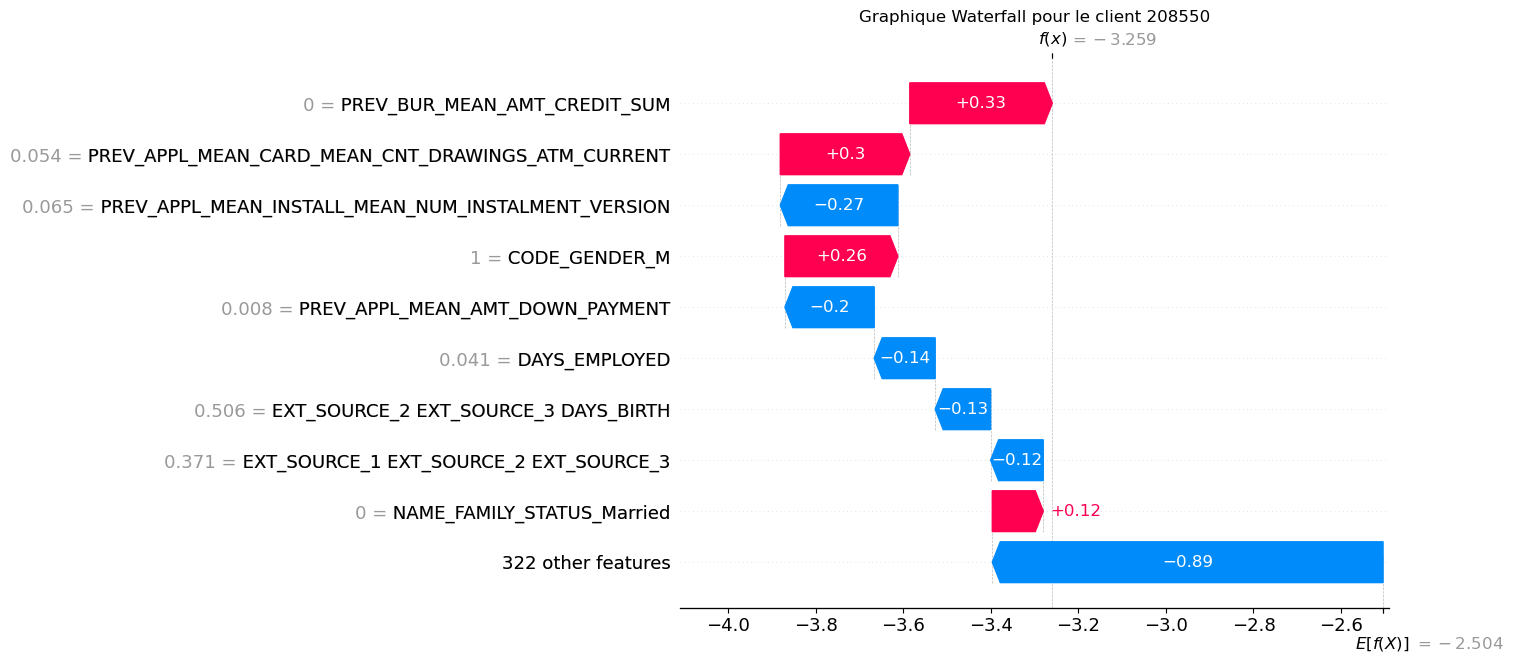

In [39]:
plot_waterfall(client_id)

In [51]:
show_feature_descriptions(client_id)

Descriptions des 10 variables les plus influentes pour le client 360960 :

- PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT : Current debt on Credit Bureau credit
- NAME_FAMILY_STATUS_Married : Family status of the client
- EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 : Combinaison des trois scores externes mesurant la stabilité financière du client.
- EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH : Interaction entre les scores externes et l'âge du client.
- DAYS_EMPLOYED : How many days before the application the person started current employment
- PREV_APPL_MEAN_AMT_DOWN_PAYMENT : Down payment on the previous application
- CODE_GENDER_M : Gender of the client
- PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION : Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
- PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT : Number of drawings at ATM during this month on the previous cr

Ce graphique waterfall montre l'impact des caractéristiques principales sur la prédiction du modèle pour le client avec l'ID 208550. Les valeurs SHAP (rouge et bleu) indiquent si chaque caractéristique contribue à augmenter ou diminuer la probabilité de défaut.

**PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT (+0.33) : "Current debt on Credit Bureau credit"**
   - Cette variable représente la **dette actuelle** du client sur un crédit répertorié au bureau de crédit. Elle a un impact significatif **positif** sur le score, augmentant la probabilité de défaut du client. Cela signifie que plus le montant de la dette est élevé, plus le modèle considère que le client est à risque.

**PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT (+0.3) : "Number of drawings at ATM during this month on the previous credit"**
   - Le **nombre de retraits effectués aux guichets automatiques sur un crédit précédent** a un effet modérément **positif** sur le risque de défaut. Cela peut indiquer une dépendance à la liquidité par le client, un signe potentiel de stress financier.


**PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION (-0.27) : "Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed"**
   - La **version de l'échéancier de remboursement sur un crédit précédent** contribue à **réduire le risque**. Cela pourrait suggérer que le client a bien respecté les modifications des conditions de paiement, ce qui est perçu positivement par le modèle.


**CODE_GENDER_M (+0.26) : "Gender of the client"**
   - Le **genre masculin** semble **augmenter légèrement le risque** de défaut. Cela peut être dû à des statistiques observées dans les données, où les clients masculins ont peut-être eu une probabilité de défaut légèrement plus élevée.


**PREV_APPL_MEAN_AMT_DOWN_PAYMENT (-0.2) : "Down payment on the previous application"**
   - **Le montant de l'acompte sur un crédit précédent** réduit le risque de défaut. Cela signifie que les clients qui ont versé des acomptes importants ont été en mesure de diminuer leur risque, probablement en montrant leur capacité à avancer des liquidités importantes.


**DAYS_EMPLOYED (-0.14) : "How many days before the application the person started current employment"**
   - **Nombre de jours travaillés avant la demande** : Plus ce nombre est élevé, plus le risque est réduit. Cela montre une certaine **stabilité de l'emploi**, qui est une caractéristique rassurante pour la solvabilité du client.


**EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH (-0.13) : "Interaction between the external scores and age of the client"**
   - Cette variable est une **interaction entre les scores externes (`EXT_SOURCE_2` et `EXT_SOURCE_3`) et l'âge du client**. Elle a un effet **réducteur** sur le risque. Cela pourrait signifier que, pour un client d'un certain âge, des scores externes favorables ont un impact positif sur leur probabilité de remboursement.


**EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 (-0.12) : "Combination of three external scores measuring the financial stability of the client"**
   - Cette combinaison de **trois scores externes** a un impact modéré mais **positif** sur la réduction du risque. Ces scores sont généralement des évaluations provenant de tiers (telles que des agences de crédit) et montrent une bonne stabilité financière.


**NAME_FAMILY_STATUS_Married (+0.12) : "Family status of the client"**
   - Le fait que le client soit **marié** semble légèrement **augmenter le risque**. Cela pourrait être lié à une responsabilité financière plus importante, telle que le soutien d'une famille, ce qui peut influencer les capacités de remboursement.


**PREV_BUR_MEAN_AMT_CREDIT_SUM (-0.89) : "Current credit amount for the Credit Bureau credit"**
    - Le **montant actuel du crédit sur un crédit répertorié au bureau de crédit** a un **impact réducteur** notable sur le risque. Cela pourrait signifier que le client a encore un crédit en cours, mais qui est bien géré sans arriéré significatif, ce qui réduit son risque de défaut.

Conclusion de l'Analyse
- Le **risque global** du client est influencé de manière positive par certains éléments, notamment la dette actuelle et le nombre de retraits aux guichets automatiques, qui indiquent des **signes de stress financier**. Ces facteurs ont contribué à augmenter la probabilité de défaut du client.
- À l’inverse, des variables telles que le **montant des acomptes**, le **nombre de jours d'emploi** et certains **scores externes** ont un **impact réducteur** sur le risque, démontrant que le client présente également des aspects financiers positifs, tels que de la stabilité dans l'emploi ou une bonne gestion des engagements financiers antérieurs.
- Le graphique indique que la variable ayant le plus grand effet positif est la **dette actuelle (`PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT`)**, tandis que la variable ayant le plus grand effet négatif est le **montant du crédit actuel (`PREV_BUR_MEAN_AMT_CREDIT_SUM`)**, ce qui montre un **mélange de signaux financiers négatifs et positifs**. En fonction du contexte métier, le fait de prendre en compte ces variables pourrait aider à prendre une décision plus éclairée sur l'attribution ou non d'un crédit.

En résumé, cette analyse détaillée permet de mieux comprendre les facteurs qui influencent le modèle dans son évaluation du risque de crédit pour ce client. Ces informations sont essentielles non seulement pour ajuster la décision de crédit mais aussi pour communiquer des explications compréhensibles aux parties prenantes, qu'il s'agisse des analystes de crédit, des clients ou des régulateurs.

## 7.3 - Features importance globale

Dans cette section, nous analysons l'importance des caractéristiques globales du modèle en utilisant les **valeurs SHAP**. L'objectif est de comprendre quelles caractéristiques influencent le plus le modèle à travers l'ensemble du jeu de données. Cela nous permet de dégager une vision globale des facteurs déterminants qui ont un impact sur la prédiction de la probabilité de défaut des clients.

L'importance des caractéristiques globales est un aspect essentiel pour plusieurs raisons :
- **Compréhension du Modèle** : Elle nous aide à identifier les variables qui ont le plus d'impact sur le modèle de manière générale, offrant ainsi une meilleure compréhension de la logique du modèle et des raisons pour lesquelles certaines prédictions sont faites.
- **Transparence** : Pour garantir la transparence et expliquer les décisions du modèle, il est crucial de savoir quels facteurs influencent les décisions de manière générale. Cela permet de fournir des explications claires aux parties prenantes, notamment dans un contexte de risque de crédit.
- **Amélioration Potentielle** : En connaissant les caractéristiques les plus influentes, il est possible de cibler des actions spécifiques pour améliorer les données ou de vérifier la qualité et la cohérence des informations collectées, notamment sur les variables ayant un impact élevé.

Nous utilisons ici le **summary plot de SHAP** pour visualiser l'importance moyenne des caractéristiques sur l'ensemble des données. Ce graphique permet de voir quelles caractéristiques ont une influence positive ou négative sur les prédictions du modèle, et de quelle manière. Cela offre une perspective claire sur la façon dont les caractéristiques interagissent avec les prédictions du modèle, et nous aide à justifier les résultats auprès des décideurs.

L'analyse globale de l'importance des caractéristiques, couplée à l'analyse locale effectuée précédemment, nous donne une compréhension complète des facteurs clés qui influencent le modèle, tant au niveau individuel (par client) que global (pour l'ensemble des clients).

In [52]:
def plot_global_feature_importance(df_clients_scaled):
    """
    Fonction pour calculer et afficher l'importance des caractéristiques globales avec SHAP.

    Parameters:
    - df_clients_scaled: DataFrame contenant les caractéristiques du jeu de données.

    Returns:
    - None: Affiche directement le graphique de l'importance des caractéristiques globales.
    """
    # Calculer les valeurs SHAP pour l'ensemble du jeu de données
    explainer = shap.Explainer(model, df_clients_scaled)  # Utiliser le modèle et les caractéristiques
    shap_values = explainer(df_clients_scaled)

    # Calculer l'importance globale des caractéristiques
    feature_importance = np.abs(shap_values.values).mean(axis=0)  # Moyenne des valeurs absolues

    # Créer un DataFrame pour l'importance des caractéristiques
    feature_importance_df = pd.DataFrame({
        'Feature': df_clients_scaled.columns,
        'Importance': feature_importance
    })

    # Trier par importance décroissante
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Afficher le graphique de l'importance des caractéristiques
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
    plt.xlabel('Importance moyenne (valeurs SHAP)')
    plt.title('Importance des caractéristiques globales')
    plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher la plus importante en haut
    plt.tight_layout()
    plt.show()  # Afficher le graphique directement dans le notebook

In [57]:
def plot_global_feature_importance_shap(df_clients_scaled):
    """
    Fonction pour calculer et afficher l'importance des caractéristiques globales avec SHAP (summary plot).

    Parameters:
    - df_clients_scaled: DataFrame contenant les caractéristiques du jeu de données.

    Returns:
    - None: Affiche directement le graphique SHAP de l'importance des caractéristiques globales.
    """
    # Calculer les valeurs SHAP pour l'ensemble du jeu de données
    explainer = shap.Explainer(model, df_clients_scaled)  # Utiliser le modèle et les caractéristiques
    shap_values = explainer(df_clients_scaled)

    # Afficher le graphique SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, df_clients_scaled, plot_type="bar", show=False)  # summary_plot sous forme de barres
    plt.title("Importance des caractéristiques globales (summary plot)")
    plt.tight_layout()
    plt.show()

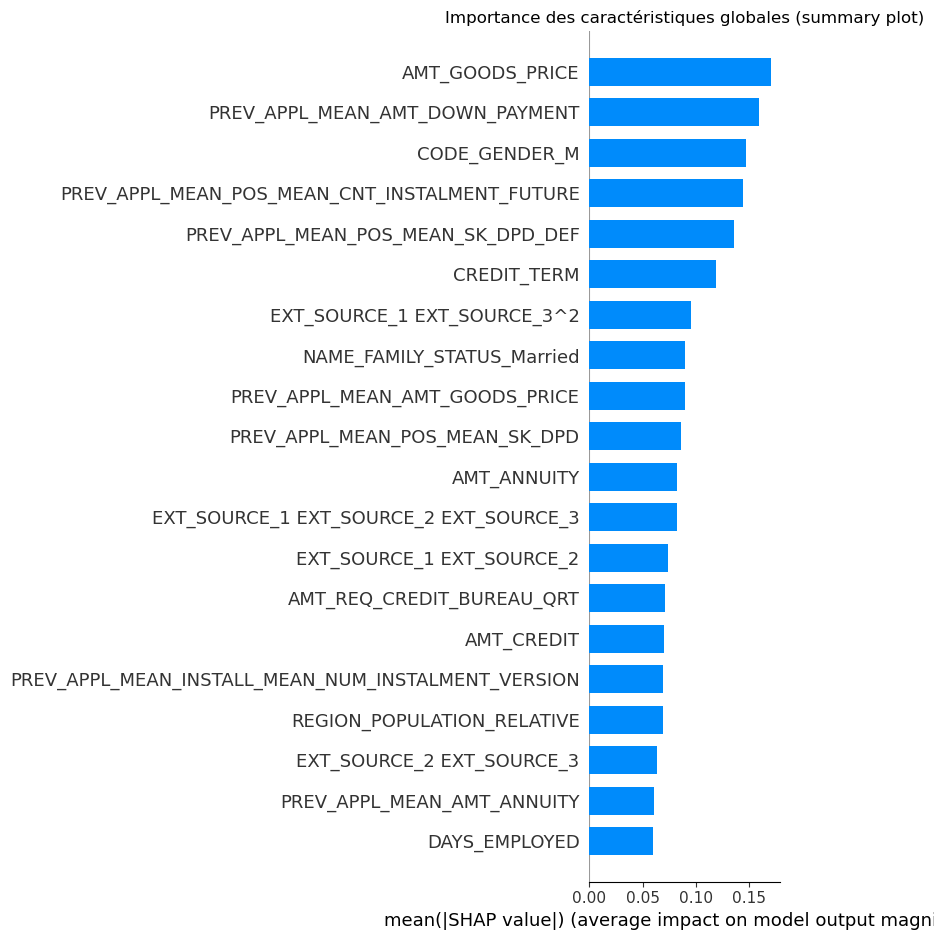

In [58]:
# Utiliser la fonction pour afficher l'importance des caractéristiques globales avec SHAP
plot_global_feature_importance_shap(df_clients_scaled)

1. **AMT_GOODS_PRICE** :
   - Cette variable correspond au **prix des biens financés**. Le modèle l'utilise comme caractéristique la plus importante. Cela s'explique par le fait que le montant des biens achetés influence directement le risque financier associé au crédit : un montant plus élevé pourrait être corrélé à une probabilité plus élevée de défaut de paiement.

2. **PREV_APPL_MEAN_AMT_DOWN_PAYMENT** :
   - Cette caractéristique représente le **montant moyen des acomptes versés sur les demandes précédentes**. Un acompte important peut indiquer une meilleure capacité à avancer de la liquidité et donc un risque de défaut plus faible. Le modèle utilise cette information pour ajuster les prévisions de risque de manière significative.

3. **CODE_GENDER_M** :
   - Cette variable encode le **genre du client (masculin)**. Elle figure parmi les caractéristiques les plus influentes, indiquant que le genre a une certaine importance dans la prédiction du risque de défaut. Cela peut être dû à des différences de comportement de crédit observées entre les genres.

4. **PREV_APPL_MEAN_POS_MEAN_CNT_INSTALMENT_FUTURE** :
   - Cette variable reflète le **nombre moyen des futures échéances de crédit précédentes**. Un nombre élevé d'échéances restantes peut indiquer une plus grande dépendance aux prêts, ce qui augmente le risque.

5. **PREV_APPL_MEAN_POS_MEAN_SK_DPD_DEF** :
   - Cette variable est le **nombre de jours de retard des crédits précédents**. Elle est utilisée pour évaluer la régularité de remboursement des clients dans le passé. Plus il y a de jours de retard, plus le risque de défaut est perçu comme élevé.

6. **CREDIT_TERM** :
   - Il s'agit de la **durée du crédit** (en mois ou années). Les crédits plus longs peuvent être associés à des risques plus élevés, car ils augmentent l'exposition de la banque sur une plus longue période.

7. **EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3^2** :
   - Cette combinaison représente une interaction non linéaire entre des scores externes qui mesurent la stabilité financière du client. Ces scores sont souvent fournis par des agences de crédit et peuvent avoir une influence importante sur la prédiction du modèle.

8. **NAME_FAMILY_STATUS_Married** :
   - Le **statut familial du client** (marié) est également un facteur important. Être marié peut influencer les obligations financières du client, ce qui peut, dans certains cas, augmenter le risque de défaut, en fonction du contexte économique de la famille.

9. **PREV_APPL_MEAN_AMT_GOODS_PRICE** :
   - C'est le **montant moyen des biens financés par des crédits précédents**. Cela reflète la tendance du client à souscrire à des prêts pour des montants élevés, influençant ainsi la capacité de remboursement.

10. **PREV_APPL_MEAN_POS_MEAN_SK_DPD** :
    - Cette variable est également liée aux **jours de retard**, mais elle n'inclut pas nécessairement les crédits en défaut. Elle permet de mesurer les habitudes de remboursement et la ponctualité des paiements passés.

Conclusions Générales :

- Les caractéristiques les plus influentes indiquent clairement que le **montant du crédit**, les **antécédents de remboursement** et les **facteurs socio-économiques** (tels que le statut familial) jouent un rôle crucial dans la détermination du risque de crédit.
- Les **scores externes** sont également très influents, ce qui est attendu, car ils sont généralement des indicateurs importants de la stabilité financière du client.
- Le modèle prend en compte des **interactions complexes** entre plusieurs caractéristiques, telles que les interactions entre les scores externes, ce qui suggère que ces combinaisons fournissent des informations supplémentaires précieuses pour l'évaluation du risque.

Ce graphique nous aide à comprendre les **caractéristiques clés** sur lesquelles le modèle se base pour évaluer le risque de défaut. En interprétant ces caractéristiques, nous pouvons mieux comprendre les **facteurs de risque** et ajuster les décisions de crédit de manière plus éclairée, en tenant compte des priorités de l'entreprise (par exemple, réduction du risque global ou maximisation de l'accès au crédit pour des clients stables).

# 8 - Datadrift

Le Data Drift fait référence aux changements dans la distribution des données au fil du temps. Il peut se produire lorsque les données utilisées pour entraîner un modèle ne reflètent plus la réalité des données qui entrent en production. Cela peut avoir un impact significatif sur les performances des modèles prédictifs, car ils sont souvent sensibles aux variations dans les données d'entrée.

On va donc tester une étape supplémentaire dans le cycle MLOps pour anticiper la surveillance de la performance du modèle en production. En particulier, nous allons utiliser la librairie Evidently pour analyser le Data Drift, c’est-à-dire les changements dans la distribution des données entre le moment où le modèle est entraîné et lorsque de nouvelles données arrivent en production.

**1. Hypothèse de test**
- **"application_train"** représente les données d'entraînement.
- **"application_test"** représente les nouvelles données des clients une fois le modèle en production.

**2. Tâche**
- Nous allons utiliser la librairie **Evidently** pour comparer les données de ces deux ensembles (train et test) et générer un rapport HTML pour détecter des différences ou du *Data Drift* sur les principales caractéristiques du modèle.

**3. Étapes à suivre**
- Charger les jeux de données `application_train` et `application_test`.
- Utiliser **Evidently** pour créer un rapport de comparaison entre les deux datasets.
- Le rapport mettra en évidence les colonnes où un *drift* est détecté.

In [ ]:
# Créer un rapport de Data Drift
data_drift_report = Report(metrics=[DataDriftTable()])

# Exécuter le rapport avec les données de référence et les données actuelles
data_drift_report.run(reference_data=df_train, current_data=df_test)

# Exporter le rapport en HTML pour visualisation
data_drift_report.save_html("data_drift_report.html")

In [ ]:
# Afficher le rapport HTML dans le notebook
IFrame('data_drift_report.html', width=900, height=600)

**Drift Détecté** : 9.61 % des colonnes (32 sur 333) présentent un drift. Cela signifie que les distributions des données d'entraînement et de test (ou de production) ont évolué pour ces colonnes, ce qui peut affecter la performance de notre modèle. La majorité des colonnes détectées pour le drift semblent liées à des caractéristiques extraites de la variable `DAYS_BIRTH` et à des variables externes (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`).

1. **Colonnes avec le Plus Grand Drift** :
   - `DAYS_BIRTH` a la distance de Wasserstein normée la plus élevée (7.356832), indiquant un drift significatif.
   - D'autres colonnes comme `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3` présentent également des valeurs élevées, suggérant des changements notables dans leurs distributions.

2. **Distance de Wasserstein** :
   - La distance de Wasserstein est une mesure de la différence entre deux distributions de probabilité. Plus la valeur est élevée, plus la différence entre les distributions d'entraînement et de test est significative.
   - Par exemple, des distances entre 4 et 7, comme celles observées pour `DAYS_BIRTH` et les variables externes, suggèrent un drift potentiellement préoccupant.

**Implications du Data Drift**

- **Impact sur le Modèle** : Un drift dans des variables clés pourrait indiquer que le modèle n’est plus représentatif des données actuelles, ce qui pourrait entraîner une baisse de performance. Les variables comme `DAYS_BIRTH` sont souvent essentielles dans des modèles de scoring de crédit.

- **Actions potentieles** :
  1. **Réévaluation du Modèle** : Considérer le réentraînement du modèle avec des données récentes si le drift est significatif. Cela pourrait inclure l'ajout de nouvelles données ou l’actualisation des features.
  
  2. **Surveillance Continue** : Mettre en place des alertes pour suivre le drift sur ces colonnes afin d'anticiper les problèmes avant qu'ils n'affectent significativement la performance du modèle.

  3. **Analyse Plus Profonde** : Effectuer une analyse plus approfondie des colonnes spécifiques qui montrent un drift. Cela peut inclure des visualisations pour voir comment les distributions ont changé.

Le Data Drift est une indication que les conditions sous-jacentes qui ont conduit à l'entraînement initial du modèle peuvent avoir changé. En suivant les recommandations et en surveillant de près les colonnes concernées, nous pouvons mieux maintenir et ajuster notre modèle pour qu'il reste performant.

# 9 - Déploiement

Dans cette partie, nous expliquons le processus de déploiement de l'API qui permet de mettre à disposition notre modèle de scoring crédit en production. L'objectif principal du déploiement est de rendre le modèle accessible aux différentes parties prenantes, telles que les équipes métiers, les analystes financiers, ou encore d'autres systèmes internes, de manière automatisée et fiable.

## 9.1 - Objectif du Déploiement

Le déploiement d'une API (Application Programming Interface) permet de fournir une **interface standardisée** pour interagir avec le modèle de prédiction de risque de crédit. Cela offre les avantages suivants :
- **Accessibilité** : Les utilisateurs ou d'autres systèmes peuvent soumettre des demandes de scoring de manière sécurisée, en obtenant des réponses en temps réel.
- **Automatisation** : L'API facilite l'intégration avec d'autres systèmes internes, tels que des systèmes CRM ou des bases de données de clients.
- **Flexibilité** : Une fois déployée, l'API peut être utilisée par divers utilisateurs, dans différents contextes, avec des mises à jour facilitées.

## 9.2 - Étapes du Déploiement

Pour déployer l'API, plusieurs étapes ont été suivies :

1. **Création de l'API avec FastAPI**
   - **FastAPI** a été utilisé pour construire l'API. FastAPI est un framework Python moderne, rapide et facile à utiliser, idéal pour déployer des modèles de machine learning.
   - Nous avons créé une application qui expose un point de terminaison `/predict` permettant aux utilisateurs d'envoyer des données d'entrée au modèle et d'obtenir une prédiction.

2. **Déploiement Local avec Uvicorn**
   - L'API a été testée en local à l'aide de **Uvicorn**, qui est un serveur ASGI très performant pour exécuter les applications FastAPI.
   - Commande utilisée pour démarrer l'API :
     ```bash
     uvicorn main:app --reload
     ```
     Cette commande lance le serveur et recharge automatiquement les modifications, facilitant ainsi le développement et le débogage.

3. **Tests des Points de Terminaison de l'API**
   - Des tests ont été réalisés sur le point de terminaison `/predict` pour s'assurer que le modèle réponde correctement aux données d'entrée. Cela inclut des tests unitaires avec **pytest** et des tests manuels depuis le navigateur (grâce à l'interface Swagger auto-générée de FastAPI).

4. **Conteneurisation avec Docker**
   - Pour simplifier le déploiement sur différents environnements, l'API a été conteneurisée à l'aide de **Docker**. Cela garantit que toutes les dépendances et configurations sont regroupées dans une image Docker.
   - Un **Dockerfile** a été créé pour définir l'environnement :
   - L'image Docker a été construite et testée localement pour s'assurer que l'API fonctionne comme prévu.

5. **Déploiement sur le Cloud**
   - Pour rendre l'API accessible à un plus large public, nous avons déployé l'API sur un service de cloud.
     - **Azure App Services** facilite le déploiement d'applications Docker sans avoir à gérer directement les serveurs.
  
7. **Intégration Continue avec GitHub Actions**
   - Le code source du projet, y compris l'API et les fichiers de configuration (Dockerfile, scripts de test), a été hébergé sur **GitHub**.
   - **GitHub Actions** a été configuré pour automatiser le processus de déploiement. À chaque modification sur la branche principale, un workflow est déclenché pour :
     - Lancer des **tests unitaires**.
     - Déployer automatiquement l'API sur Azure si les tests réussissent.
   - Cette approche d'intégration et de déploiement continus (CI/CD) assure une mise à jour régulière et fiable de l'API, sans intervention manuelle.

7. **Interface Utilisateur avec Streamlit**
   - Une interface utilisateur simple a été créée avec **Streamlit** pour permettre aux utilisateurs de tester facilement l'API.
   - Cette interface permet de soumettre des données au modèle et de visualiser les résultats de prédiction de manière interactive. Streamlit est très pratique pour créer rapidement des interfaces utilisateur, et il a été utilisé ici pour simplifier les tests côté utilisateur.
    - L'interface **Streamlit** a été déployée sur **Streamlit Cloud**, ce qui la rend facilement accessible aux utilisateurs. Cela permet de tester différentes configurations et scénarios, et de valider les prédictions fournies par le modèle de manière simple et intuitive.

# 10 - Conclusion

Ce projet visait à développer un modèle de scoring crédit robuste en utilisant une approche MLOps, depuis la modélisation initiale jusqu'au déploiement. Nous avons commencé par tester des modèles sur des données déséquilibrées, incluant un **Dummy Classifier** comme baseline, puis une **régression logistique** et des modèles de **Gradient Boosting** pour affiner nos prédictions.

Pour pallier le déséquilibre de classes, nous avons appliqué **SMOTE** et constaté une amélioration des performances sur les modèle les plus simple grâce à l'équilibrage des données. Après une évaluation préliminaire, les meilleurs hyperparamètres des modèles **LGBM** et **XGBoost** ont été recherchés via des techniques de validation croisée.

Ensuite, nous avons introduit un **score métier** pour mieux prendre en compte l'impact des erreurs sur le business, en donnant une importance accrue aux faux négatifs. Différentes configurations de coûts ont été testées pour adapter le modèle aux contextes métier variés, et nous avons analysé les **meilleurs seuils de décision** pour chaque situation.

L'importance des caractéristiques a été explorée à la fois au niveau **global** (pour identifier les variables clés influençant le modèle) et au niveau **local** (pour expliquer la prédiction individuelle de chaque client). Nous avons également évalué le **data drift** pour assurer la robustesse du modèle face aux changements de données en production.

Enfin, le modèle a été déployé via une **API FastAPI**, conteneurisée avec **Docker** et hébergée sur le cloud. Une interface **Streamlit** a également été mise en place pour permettre aux utilisateurs de tester l'API facilement. Ce projet illustre l'importance d'une approche intégrée de bout en bout.

In [ ]:
elapsed_time = time.time() - start  # Calcule le temps écoulé
print(f"Temps total d'exécution du notebook : {elapsed_time:.2f} secondes.")